# Scraping web articles
In the previous notebook, I created a large dataset of multilingual claims, each containing a link to a debunking (or supporting) article. For the purpose of our automated fact checking system, we will need to have both the claim and the complete article (plus its stance), so I will now proceed to scrape each of these websites to get them.

## Import

Google Colab only!

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = "https://drive.google.com/file/d/1BjvuTvCklagYACO4ZFHbiWCoCyQEpNQR/view?usp=sharing"
id = "1BjvuTvCklagYACO4ZFHbiWCoCyQEpNQR" 
name = "factcheck.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
drive_service = build('drive', 'v3')

def save_file_to_drive(name, path):
  file_metadata = {
    'name': name,
    'mimeType': 'application/octet-stream'
  }

  media = MediaFileUpload(path, mimetype='application/octet-stream', resumable=True)

  created = drive_service.files().create(body=file_metadata, media_body=media, fields='id').execute()

  print('File ID: {}'.format(created.get('id')))

  return created

In [ ]:
!mkdir Articles

In [ ]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import time
import re
import random
import seaborn as sns
import matplotlib.pyplot as plt
import shutil

HEADERS = {'User-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}

In [ ]:
df_claims = pd.read_csv('factcheck.csv')
df_claims.head()

claim  ... publisherSite
0  Joe Biden s'est assoupi pendant une interview ...  ...  20minutes.fr
1  Annastacia Palaszczuk, première ministre du Qu...  ...  20minutes.fr
2  Mary Anne Trump aurait déclaré : " Yes he's an...  ...  20minutes.fr
3  La statue de George Orwell située devant la Br...  ...  20minutes.fr
4  Une pétition, signée des milliers de fois, a é...  ...  20minutes.fr

[5 rows x 10 columns]

## Selecting the websites
There are around 90 unique websites in this dataset. For the moment I'll limit myself to scraping only the ones with most claims.

In [ ]:
print("Number of publishers: ", len(df_claims['publisherSite'].unique()))
df_claims['publisherSite'].unique()

Number of publishers:  94


array(['20minutes.fr', 'aajtak.in', 'abc.net.au', 'africacheck.org',
       'altnews.in', 'animalpolitico.com', 'verificado.mx',
       'aosfatos.org', 'apublica.org', 'bbc.co.uk', 'bbc.com',
       'boatos.org', 'bol.uol.com.br', 'noticias.uol.com.br',
       'boomlive.in', 'bangla.boomlive.in', 'br.de', 'butac.it',
       'cbsnews.com', 'vox.com', 'cekfakta.tempo.co', 'channel4.com',
       'checamos.afp.com', 'periksafakta.afp.com', 'factuel.afp.com',
       'factual.afp.com', 'semakanfakta.afp.com', 'sprawdzam.afp.com',
       'fakty.afp.com', 'factcheck.afp.com', 'checkyourfact.com',
       'chequeado.com', 'colombiacheck.com', 'newtral.es',
       'correctiv.org', 'derstandard.at', 'dpa-factchecking.com',
       'efe.com', 'facta.news', 'factcheck.aap.com.au',
       'factcheckthailand.afp.com', 'factcheck.org', 'politifact.com',
       'washingtonpost.com', 'nytimes.com', 'leadstories.com',
       'factcheck.thedispatch.com', 'factcrescendo.com', 'factly.in',
       'factscan.ca

In [ ]:
df_claims.groupby(by='publisherSite').count().sort_values(by='claim', ascending=False)['claim']

publisherSite
piaui.folha.uol.com.br        4328
vishvasnews.com               3359
altnews.in                    3340
factcheck.afp.com             2735
fullfact.org                  2709
                              ... 
comprovem.afp.com                1
hoax-alert.leadstories.com       1
newsweek.com                     1
oglobo.globo.com                 1
vox.com                          1
Name: claim, Length: 94, dtype: int64

In [ ]:
df_claims.groupby(by='publisherSite').count().describe()

claim     claimant    claimDate          url  reviewTitle  \
count    94.000000    94.000000    94.000000    94.000000    94.000000   
mean    650.680851   542.797872   547.765957   650.680851   641.617021   
std     884.550882   787.511605   817.125139   884.550882   884.519007   
min       1.000000     0.000000     0.000000     1.000000     0.000000   
25%      38.500000    17.750000    17.750000    38.500000    26.500000   
50%     255.500000   161.500000   149.000000   255.500000   237.000000   
75%     940.750000   869.500000   775.250000   940.750000   940.500000   
max    4328.000000  3636.000000  4328.000000  4328.000000  4328.000000   

        reviewDate       Rating  languageCode  publisherName  
count    94.000000    94.000000     94.000000      94.000000  
mean    633.468085   650.680851    650.680851     630.329787  
std     878.860647   884.550882    884.550882     846.822034  
min       1.000000     1.000000      1.000000       1.000000  
25%      37.750000    38.500000     38.500000      30.250000  
50%     242.000000   255.500000    255.500000     252.500000  
75%     922.750000   940.750000    940.750000     940.750000  
max    4328.000000  4328.000000   4328.000000    4328.000000

The first step will be to remove websites that contain less than 1000 articles. This will cut the namber of publisher by a rough 75% while retaining 70% of the articles. Later, if we're not satisfied with the results, we might scrape the remaining websites as well.

In [ ]:
df_claims_by_publisher = df_claims.groupby(by='publisherSite').count().sort_values(by='claim', ascending=False)
df_claims_by_publisher = df_claims_by_publisher.drop(df_claims_by_publisher.columns.difference(['claim']), axis=1)
df_claims_by_publisher = df_claims_by_publisher.rename(columns={'claim':'num_claims'})

In [ ]:
THRESHOLD = 900
total_claims = len(df_claims)
cut_claims = len(df_claims[df_claims['publisherSite'].isin(df_claims_by_publisher[df_claims_by_publisher['num_claims'] >= THRESHOLD].index)])
perc = cut_claims * 100 / total_claims

print("Publishers with more than 100 articles: ",len(df_claims_by_publisher[df_claims_by_publisher['num_claims'] >= THRESHOLD]))
print("Articles from those publisher: ", cut_claims)
print("Total number of articles: ", total_claims)
print("We are mantaining: {:.2f}% of the total articles".format(perc))

Publishers with more than 100 articles:  26
Articles from those publisher:  46646
Total number of articles:  61164
We are mantaining: 76.26% of the total articles


In [ ]:
df_claims_by_publisher[df_claims_by_publisher['num_claims'] >= THRESHOLD]

num_claims
publisherSite                      
piaui.folha.uol.com.br         4328
vishvasnews.com                3359
altnews.in                     3340
factcheck.afp.com              2735
fullfact.org                   2709
leadstories.com                2568
factly.in                      2537
poligrafo.sapo.pt              2193
snopes.com                     1926
misbar.com                     1829
factcheck.org                  1813
newtral.es                     1626
factual.afp.com                1610
factuel.afp.com                1437
checkyourfact.com              1239
pagellapolitica.it             1209
aosfatos.org                   1150
boatos.org                     1116
washingtonpost.com             1089
politifact.com                 1043
politica.estadao.com.br        1019
chequeado.com                  1000
boomlive.in                     991
indiatoday.in                   945
polygraph.info                  928
correctiv.org                   907

## Scraping the websites
We will now scrape the websites one by one.

In [ ]:
#Utility function to clean the html
def cleanhtml(raw_html):
    cleanr = re.compile('\n|\u200a|\u200b|\u200c|\r|\xa0')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

Here's the function to scrape articles out of every different website

In [ ]:
WAITING_TIME = 2

#Scrapes article content
def scrape_article(row):
    
    #Info from the row
    claim = row['claim']
    url = row['url']
    lang = row['languageCode']
    publisher_site = row['publisherSite']
    publisher_name = row['publisherName']
    
    #Request to the website
    r = requests.get(url=url, headers=HEADERS)
    time.sleep(WAITING_TIME)
    if(r.status_code != 200):
        print("Error!")
        print(r.content)
        return 0
        
    #Scrape the content
    content_text, content_img_url = scrape_content(r.content, publisher_site, rowNumber = row['row'])
    
    #Save data
    data = {}
    data['claim'] = claim
    data['url'] = url
    data['lang'] = lang
    data['publisher_site'] = publisher_site
    data['publisher_name'] = publisher_name
    data['articleBody'] = content_text
    data['imageUrl'] = content_img_url

    #Some exceptions for some publishers
    if publisher_site == 'pagellapolitica.it':
      data['claim'] = pagella_claim_titles[row['row']]
    
    #Write on file (name of the file is the first part of the website)
    filename = "./Articles/" + publisher_site.split(".")[0] + '.txt'
    with open(filename, "a", encoding='utf8') as f:
        f.write(str(data))
        f.write("\n")
    
    perc_complete = (row['row'] + 1) * 100 / row['tot']
    print("Row {} extracted ({:.2f}%); written on {}".format(row['row'], perc_complete, filename))
    return 1

#Based on the name of the publisher, we adapt the scraping
def scrape_content(html_content, publisher, rowNumber=None):
    
    #Parse the html
    soup = BeautifulSoup(html_content, 'html.parser')
    
    #The scraping is different for every news website
    #Out of each of these blocks, we get two variables:
    # - coverpage_content_text: text of the article
    # - coverpage_content_img: an array of html elements 'img' present in the main section of the page
    
    #Uol
    if publisher == "piaui.folha.uol.com.br":
        coverpage_content = soup.find_all('div', class_='post-inner')
        coverpage_content_text = cleanhtml(coverpage_content[0].get_text())
        coverpage_content_img = coverpage_content[0].findAll('img')
    
    #Vishvanews
    if publisher == "vishvasnews.com":
        coverpage_content = soup.find_all('div', class_='lhs-area')
        coverpage_content_img = coverpage_content[0].findAll('img')
        coverpage_content_text = ''
        for paragraph in coverpage_content[0].find_all('p'):
            coverpage_content_text += paragraph.get_text()

            #This term signals this is the last paragraph
            if ("निष्कर्ष:" in paragraph.get_text()):
                break
        
    #Altnews
    if publisher == "altnews.in":
        coverpage_content = soup.find_all('div', class_='entry-content herald-entry-content')
        coverpage_content_img = coverpage_content[0].findAll('img')
        coverpage_content_text = ''
        for paragraph in coverpage_content[0].find_all('p'):
            #This term signals this is the last paragraph
            if ("Donate Now" in paragraph.get_text()):
                break
            
            coverpage_content_text += paragraph.get_text()
            
    #AFP News
    if publisher == 'factcheck.afp.com':
        coverpage_content = soup.find_all('div', class_='article-entry clearfix')
        coverpage_content_text = re.sub(re.compile('\n|\xa0'), '', coverpage_content[0].get_text())
        coverpage_content_img = coverpage_content[0].findAll('img')
        #In this website, images have relative paths
        if len(coverpage_content_img) != 0:
            coverpage_content_img[0]['src'] += "http://factcheck.afp.com/"
        
    #Full fact
    if publisher == 'fullfact.org':
        coverpage_content = soup.find_all('div', class_='col-sm-12 col-md-7 article-post-content')
        divs = coverpage_content[0].find_all('div')
        coverpage_content_text = ''
        for div in divs:
            if div.get('class') == None:
                for p in div.find_all('p'):
                    if p.get('class') != None:
                        break
                    coverpage_content_text += p.get_text()
        coverpage_content_img = coverpage_content[0].find_all('img')
        
    #Leadstories
    if publisher == 'leadstories.com':
        coverpage_content = soup.find_all('div', class_='mod-full-article-content')
        coverpage_content_text = re.sub('\n+', '\n', coverpage_content[0].get_text())
        coverpage_content_img = coverpage_content[0].find_all('img')

    #Factly.in
    if publisher == 'factly.in':
      coverpage_content = soup.find_all('div', class_='post-content description ')
      coverpage_content_text = coverpage_content[0].get_text()
      coverpage_content_img = coverpage_content[0].find_all('img')

    #Poligrafo.sapo.pt
    if publisher == 'poligrafo.sapo.pt':
      coverpage_content_text = ''
      for p in soup.find_all('p'):
        if 'Nota editorial:' in p.get_text():
          break
        coverpage_content_text += p.get_text()
      coverpage_content_figure = soup.find('figure', class_='article-image')
      if coverpage_content_figure != None:
        coverpage_content_img = coverpage_content_figure.find_all('source')
      else:
        coverpage_content_img = []
      if len(coverpage_content_img) != 0:
        coverpage_content_img = [{'src': coverpage_content_img[0]['data-srcset']}]

    #Snopes.com
    if publisher == 'snopes.com':
      coverpage_content = soup.find_all('div', class_='content')
      coverpage_content_text = ''
      for p in coverpage_content[0].find_all('p'):
        coverpage_content_text += p.get_text()
      coverpage_content_img = coverpage_content[0].find_all('img')

    #misbar.com
    if publisher == 'misbar.com':
      coverpage_content = soup.find_all('div', class_='deep-dive--article_analysis')
      coverpage_content_text = ''
      for p in coverpage_content[0].find_all('p'):
          coverpage_content_text += p.get_text()
      coverpage_content_img = coverpage_content[0].find_all('img')
      if len(coverpage_content_img) == 0:
        coverpage_content_img = coverpage_content[0].find_all('amp-img')

    #factcheck.org
    if publisher == 'factcheck.org':
      coverpage_content = soup.find_all('div', class_='entry-content')
      coverpage_content_img = []
      coverpage_content_text = ''
      for elem in coverpage_content[0].findChildren():
          if elem.name == 'h5' and elem.get_text() == 'Sources':
              break
          if elem.name == 'p':
              coverpage_content_text += elem.get_text()
          if elem.name == 'img':
              coverpage_content_img.append(elem)

    #Newtral.es
    if publisher == 'newtral.es':
      coverpage_content = soup.find_all('div', class_='entry-content')
      coverpage_content_text = ''
      for p in coverpage_content[0].find_all('p'):
          if 'Fuentes' in p.get_text():
              break
          coverpage_content_text += p.get_text()

      coverpage_content_dup = soup.find_all('div', class_='entry-aside')
      coverpage_content_img = coverpage_content_dup[0].find_all('img')

    #factual.afp.com
    if publisher == 'factual.afp.com' or publisher == 'factuel.afp.com':

      #Updating the reviewTitle
      if publisher == 'factual.afp.com':
        global factual_review_titles
        title = soup.find('h1', class_='content-title').get_text()
        factual_review_titles[rowNumber] = title
      else:
        global factuel_review_titles
        title = soup.find('h1', class_='content-title').get_text()
        factuel_review_titles[rowNumber] = title

      #Retrieving the article body
      coverpage_content = soup.find_all('div', class_='article-entry clearfix')
      coverpage_content_text = ''
      for elem in coverpage_content[0].findChildren():
        if elem.name == 'h3':
          coverpage_content_text += elem.get_text()
        if elem.name == 'p':
          coverpage_content_text += elem.get_text()

      #Retrieving the main image url
      scripts = soup.find_all('script')
      script_img = ''
      for script in scripts:
          if "afp_blog_theme" in str(script):
              script_img = script
      if script_img != '':
        coverpage_content_img_url = "https://" + publisher + "/sites" + str(script_img).split("srcset=")[1].split(" ")[0].split("sites")[1].replace("\\", "")
      else:
        coverpage_content_img_url = 'None'
      
      return coverpage_content_text, coverpage_content_img_url

    #checkyourfact.com
    if publisher == 'checkyourfact.com':
      coverpage_content = soup.find('div', id='ob-read-more-selector')
      coverpage_content_text = ''
      for p in coverpage_content.find_all('p'):
          coverpage_content_text += p.get_text()
      if len(soup.find_all('photo')) != 0:
        coverpage_content_img = [{'src': soup.find('photo')['style'].split("url(")[1]}]
      else:
        coverpage_content_img = []

    #pagellapolitica.it
    if publisher == 'pagellapolitica.it':
      global pagella_claim_links
      global pagella_claim_titles
      coverpage_content = soup.find('div', class_='col-lg-9 mb-9 mb-lg-0')

      #Retrieve article body and actual claim
      coverpage_content_text = ''
      for elem in coverpage_content.findChildren():
          if elem.name == 'p':
              if elem.has_attr('class') and elem['class'] == ['lead', 'px-3', 'py-3', 'bg-light', 'g-brd-around', 'g-brd-lightblue']:
                  pagella_claim_titles[rowNumber] = elem.get_text()
              if elem.has_attr('class') == False:
                  coverpage_content_text += elem.get_text()

      #Retrieve link to original claim
      link_claim = soup.find_all('a', class_='u-link-muted', target="_blank")
      if len(link_claim) != 0:
        pagella_claim_links[rowNumber] = link_claim[0]['href']
      
      #Retrieve image
      coverpage_content_img = coverpage_content.find_all('img')

    #aosfatos.org
    if publisher == 'aosfatos.org':
      coverpage_content = soup.find('article')
      coverpage_content_text = ''
      for p in coverpage_content.find_all('p'):
          if p.has_attr('class'):
              continue
          if 'Referências:' in p.get_text():
              break
          coverpage_content_text += p.get_text()
      coverpage_content_img = []

    #boatos.org
    if publisher == 'boatos.org':
      coverpage_content = soup.find('div', class_='entry-content clearfix')
      coverpage_content_text = ''
      for p in coverpage_content.find_all('p'):
          if p.has_attr('style') and p['style'] == 'text-align: center;':
              continue
          if "Ps.: Esse artigo é uma sugestão de leitores do Boatos.org" in p.get_text():
              break
          coverpage_content_text += p.get_text()

      coverpage_content_img_container = soup.find('div', class_='featured-image')
      if coverpage_content_img_container is not None:
        coverpage_content_img = soup.find('div', class_='featured-image').find_all('img')
      else:
        coverpage_content_img = []

    #politica.estadao.com.br
    if publisher == 'politica.estadao.com.br':
      coverpage_content = soup.find('div', class_='n--noticia__content content')
      coverpage_content_text = ''
      for p in coverpage_content.find_all('p'):
          if p.has_attr('class') and p['class'] == ['wp-caption-text']:
              continue
          if "Este boato foi checado" in p.get_text():
              break
          coverpage_content_text += p.get_text()
          
      coverpage_content_img = coverpage_content.find_all('img')

    #chequeado.com
    if publisher == 'chequeado.com':
      coverpage_content = soup.find('article', class_='content')
      coverpage_content_text = ''
      for p in coverpage_content.find_all('p'):
          if "Equipo de Chequeado" in p.get_text():
              continue
          if "Si querés estar mejor informado" in p.get_text():
              break
          if "¿Te gustó esta nota?" in p.get_text():
              break
          coverpage_content_text += p.get_text()
          
      coverpage_content_img_container = soup.find('div', class_='helper image')
      coverpage_content_img = coverpage_content_img_container.find_all('img')

    if publisher == 'politifact.com':
      global politifact_review_titles
      global politifact_review_dates
    
      #Review Date
      reviewDate = soup.find('div', class_='m-statement__desc')
      politifact_review_dates[rowNumber] = reviewDate.get_text()
    
      #Review Title
      reviewDate = soup.find('h2', class_='c-title c-title--subline')
      politifact_review_titles = reviewDate.get_text()

      #Text
      coverpage_content = soup.find('article', class_='m-textblock')
      coverpage_content_text = ""
      for p in coverpage_content.find_all('p'):
        coverpage_content_text += p.get_text()

      #Image
      coverpage_content_img = soup.find('img', wibbitz='embed-main-image', class_='c-image__original lozad')
      if coverpage_content_img is None:
        coverpage_content_img = []
      else:
        coverpage_content_img = [{'src': coverpage_content_img['data-src']}]


    #boomlive.in
    if publisher == 'boomlive.in':
      coverpage_content = soup.find('div', class_='story')
      if coverpage_content != None:
        coverpage_content_text = ''
        for p in coverpage_content.find_all('p'):
            coverpage_content_text += p.get_text()
        coverpage_content_img = coverpage_content.find_all('h-img')
      else:
        coverpage_content = soup.find('div', class_='entry-content clearfix')
        coverpage_content_text = coverpage_content.find_all('p')[1].get_text()
        coverpage_content_img = coverpage_content.find_all('img')
    
    
    #Check if there's any main image in the article
    if len(coverpage_content_img) != 0:
        coverpage_content_img_url = coverpage_content_img[0]['src']
    else:
        coverpage_content_img_url = 'None'
        
    return coverpage_content_text, coverpage_content_img_url

### Uol
Universo Online. This is the website with the biggest number of claims. It comes from Brazil and is the 5th most visited website in the country according to Wikipedia statistics. Here's some info:
 - Language: Portugues
 - Website: piaui.folha.uol.com.br (Copy paste on your browser)
 - Wikipedia page: https://en.wikipedia.org/wiki/Universo_Online
 - Number of articles: 4328

Let's try to scrape the first article

In [ ]:
df_claims[df_claims['publisherSite'] == 'piaui.folha.uol.com.br']['url'][0:1].values

array(['https://piaui.folha.uol.com.br/lupa/2020/09/04/verificamos-governo-federal-kit-contra-covid-19/'],
      dtype=object)

In [ ]:
df_claims[df_claims['publisherSite'] == 'piaui.folha.uol.com.br'][0:1]

claim          claimant  \
44312  Esse KIT foi disponibilizado pelo GOVERNO FEDE...  Post no Facebook   

                       claimDate  \
44312  2020-09-04 20:20:53+00:00   

                                                     url  \
44312  https://piaui.folha.uol.com.br/lupa/2020/09/04...   

                                             reviewTitle  \
44312  #Verificamos: É falso que governo federal forn...   

                      reviewDate Rating languageCode publisherName  \
44312  2020-09-04 20:20:53+00:00  Falso           pt           Uol   

                publisherSite  
44312  piaui.folha.uol.com.br

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'piaui.folha.uol.com.br'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Pela primeira vez em 20 anos o orçamento anual saiu do vermelho. Bem vindo a nova era! Parabéns à equipe responsável
Melhor desinfetante é o VINAGRE!!! Não usem álcool gel para se protegerem do coronavírus ... É um grande negócio !! Partilhem o mais possível ... o mundo precisa saber disto
Fui ministro da Educação por sete anos, gerenciei R$ 100 bilhões ao ano
A ministra Luciana Lóssio pode antecipar voto no processo de cassação de Temer
Portal da Transparência! Óbitos por pneumonia em 2019: 97.091. Óbitos por insuficiência respiratória em 2019: 41.220. Entendeu onde está as 100 mil mortes? Renomearam pneumonia e insuficiência respiratória para Covid-19

Review titles:
#Verificamos: É falso que Bolsonaro tenha tirado contas públicas 'do vermelho' | Agência Lupa
#Verificamos: É falso que vinagre é mais eficiente que álcool gel na proteção contra o novo coronavírus | Agência Lupa
No SBT, Haddad erra ao falar de orçamento de ministério e porcentagem de presos por

Response: The 5 claims and titles correspond to the actual claims and titles of the articles

In [ ]:
r1 = requests.get(url='https://piaui.folha.uol.com.br/lupa/2020/09/04/verificamos-governo-federal-kit-contra-covid-19/')
coverpage = r1.content

In [ ]:
soup1 = BeautifulSoup(coverpage, 'html.parser')
coverpage_news = soup1.find_all('h2', class_='bloco-title')
coverpage_news[0].get_text()

' #Verificamos: É falso que governo federal fornece kit contra Covid-19 a estados e municípios'

In [ ]:
coverpage_content = soup1.find_all('div', class_='post-inner')
coverpage_content[0].get_text()

'\nCircula pelas redes sociais a foto de um kit de medicamentos contra a Covid-19 que, segundo a legenda, estaria sendo fornecido pelo governo federal a estados e municípios. Nele estariam incluídos azitromicina (500 miligramas – 5 comprimidos) e sulfato de hidroxicloroquina (400 miligramas – 6 comprimidos), além de vitamina C (500 miligramas), vitamina D (400 UI) e zinco (20 comprimidos). Por meio do \u200bprojeto de verificação de notícias\u200b, usuários do Facebook solicitaram que esse material fosse analisado. Confira a seguir o trabalho de verificação da Lupa\u200b:\n\n“Esse KIT foi disponibilizado pelo GOVERNO FEDERAL e se não chegou nas suas mãos, saiba que seu GOVERNADOR & seu PREFEITO tem culpa no cartório por esse fato. Lembre-se deles e seus partidos nas próximas eleições”\nTexto em post publicado no Facebook que, até as 19h30 de 4 de setembro de 2020, tinha 332 compartilhamentos\nFALSO\nA informação analisada pela Lupa é falsa. A assessoria de imprensa do Ministério da Saú

In [ ]:
cleanhtml(coverpage_content[0].get_text())

'Circula pelas redes sociais a foto de um kit de medicamentos contra a Covid-19 que, segundo a legenda, estaria sendo fornecido pelo governo federal a estados e municípios. Nele estariam incluídos azitromicina (500 miligramas – 5 comprimidos) e sulfato de hidroxicloroquina (400 miligramas – 6 comprimidos), além de vitamina C (500 miligramas), vitamina D (400 UI) e zinco (20 comprimidos). Por meio do projeto de verificação de notícias, usuários do Facebook solicitaram que esse material fosse analisado. Confira a seguir o trabalho de verificação da Lupa:“Esse KIT foi disponibilizado pelo GOVERNO FEDERAL e se não chegou nas suas mãos, saiba que seu GOVERNADOR & seu PREFEITO tem culpa no cartório por esse fato. Lembre-se deles e seus partidos nas próximas eleições”Texto em post publicado no Facebook que, até as 19h30 de 4 de setembro de 2020, tinha 332 compartilhamentosFALSOA informação analisada pela Lupa é falsa. A assessoria de imprensa do Ministério da Saúde informou, em nota, que não 

Looks like it is working. We can also retrieve the url of the image contained in the article (could be useful for other purposes)

In [ ]:
coverpage_content_img = coverpage_content[0].find('img')
coverpage_content_img_url = coverpage_content_img['src']
print(coverpage_content_img_url)

https://piaui.folha.uol.com.br/lupa/wp-content/uploads/2020/09/kit-remedios-governo-federal-covid-19.jpg


In [ ]:
dict_prova = {'claim':df_claims['claim'][0:1].values[0], 'text': cleanhtml(coverpage_content[0].get_text())}

In [ ]:
dict_prova

{'claim': "Joe Biden s'est assoupi pendant une interview avec la chaîne KBAK",
 'text': 'Circula pelas redes sociais a foto de um kit de medicamentos contra a Covid-19 que, segundo a legenda, estaria sendo fornecido pelo governo federal a estados e municípios. Nele estariam incluídos azitromicina (500 miligramas – 5 comprimidos) e sulfato de hidroxicloroquina (400 miligramas – 6 comprimidos), além de vitamina C (500 miligramas), vitamina D (400 UI) e zinco (20 comprimidos). Por meio do projeto de verificação de notícias, usuários do Facebook solicitaram que esse material fosse analisado. Confira a seguir o trabalho de verificação da Lupa:“Esse KIT foi disponibilizado pelo GOVERNO FEDERAL e se não chegou nas suas mãos, saiba que seu GOVERNADOR & seu PREFEITO tem culpa no cartório por esse fato. Lembre-se deles e seus partidos nas próximas eleições”Texto em post publicado no Facebook que, até as 19h30 de 4 de setembro de 2020, tinha 332 compartilhamentosFALSOA informação analisada pela L

Now we can repeat the process for all of the articles

In [ ]:
WAITING_TIME = 1

#Scrapes article content
def scrape_article(row):
    
    #Info from the row
    claim = row['claim']
    url = row['url']
    lang = row['languageCode']
    publisher_site = row['publisherSite']
    publisher_name = row['publisherName']
    
    #Request to the website
    r = requests.get(url=url)
    time.sleep(WAITING_TIME)
    if(r.status_code != 200):
        print("Error!")
        print(r.content)
        return 0
        
    #Scrape the content
    coverpage = r.content
    soup = BeautifulSoup(coverpage, 'html.parser')
    coverpage_content = soup.find_all('div', class_='post-inner')
    coverpage_content_text = cleanhtml(coverpage_content[0].get_text())
    coverpage_content_img = coverpage_content[0].findAll('img')
    if len(coverpage_content_img) != 0:
        coverpage_content_img_url = coverpage_content[0].find('img')['src']
    else:
        coverpage_content_img_url = 'None'
    
    #Save data
    data = {}
    data['claim'] = claim
    data['url'] = url
    data['lang'] = lang
    data['publisher_site'] = publisher_site
    data['publisher_name'] = publisher_name
    data['articleBody'] = coverpage_content_text
    data['imageUrl'] = coverpage_content_img_url
    with open("Uol.txt", "a", encoding='utf8') as f:
        f.write(str(data))
        f.write("\n")
    
    perc_complete = (row['row'] + 1) * 100 / row['tot']
    print("Row {} extracted ({:.2f}%)".format(row['row'], perc_complete))
    return 1

In [ ]:
uol_claims = df_claims[df_claims['publisherSite'] == 'piaui.folha.uol.com.br']
uol_claims['row'] = range(0,len(uol_claims))
uol_claims['tot'] = len(uol_claims)
uol_claims['is_successful'] = uol_claims.apply(scrape_article, axis=1)

c:\users\stefyx\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\stefyx\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Row 0 extracted (0.02%)
Row 1 extracted (0.05%)
Row 2 extracted (0.07%)
Row 3 extracted (0.09%)
Row 4 extracted (0.12%)
Row 5 extracted (0.14%)
Row 6 extracted (0.16%)
Row 7 extracted (0.18%)
Row 8 extracted (0.21%)
Row 9 extracted (0.23%)
Row 10 extracted (0.25%)
Row 11 extracted (0.28%)
Row 12 extracted (0.30%)
Row 13 extracted (0.32%)
Row 14 extracted (0.35%)
Row 15 extracted (0.37%)
Row 16 extracted (0.39%)
Row 17 extracted (0.42%)
Row 18 extracted (0.44%)
Row 19 extracted (0.46%)
Row 20 extracted (0.49%)
Row 21 extracted (0.51%)
Row 22 extracted (0.53%)
Row 23 extracted (0.55%)
Row 24 extracted (0.58%)
Row 25 extracted (0.60%)
Row 26 extracted (0.62%)
Row 27 extracted (0.65%)
Row 28 extracted (0.67%)
Row 29 extracted (0.69%)
Row 30 extracted (0.72%)
Row 31 extracted (0.74%)
Row 32 extracted (0.76%)
Row 33 extracted (0.79%)
Row 34 extracted (0.81%)
Row 35 extracted (0.83%)
Row 36 extracted (0.85%)
Row 37 extracted (0.88%)
Row 38 extracted (0.90%)
Row 39 extracted (0.92%)
Row 40 ext

c:\users\stefyx\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### Vishvanews
Vishvanews. Indian newspaper and second website in terms of number of claims, publishing in Hindi.
 - Language: Various, mainly Hindi
 - Website: https://www.vishvasnews.com/english/ 
 - Number of articles: 3359

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'vishvasnews.com']['url'].tolist()[70])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'vishvasnews.com']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'vishvasnews.com']))

One article from this website:  https://www.vishvasnews.com/society/fact-check-old-pictures-of-waterlogging-are-being-viral-by-saying-recent-exam-centers/
Languages spoken:  ['hi', 'ur', 'en', 'mr', 'ta', 'pa', 'ml', 'te', 'bn', 'gu', 'or']
Number of articles:  3359


In [ ]:
df_claims[df_claims['publisherSite'] == 'vishvasnews.com'][0:1]

claim  ...    publisherSite
56703  दिल्ली का पुल जो 450 करोड़ का बनना था और केजरीव...  ...  vishvasnews.com

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'vishvasnews.com'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
ہندو سمراٹ کا نیا اوتار۔ میڈیا اس تصویر کو کیوں نہیں دکھا رہی ہے
فوج کی جانب سے کشمیریوں پر ظلم
विश्व स्वास्थ्य संगठन (डब्ल्यूएचओ) लोगों को वर्क फ्रॉम होम ऑफर कर रहा है।नौकरी के लिए अनुभव की आवश्यकता नहीं है
नक्कली सेनेताईज़र बना के देश कि सेवा करते हुवे देश प्रेमी मोलवी ।।अब घिन आने लगी है इन हरामियो से.. और फिर कहते हे मिडीया वाले बदनाम करते हे
காட்டு யானை கேரளாவின் மல்லபுரத்தில் உள்ள ஏபிஎல் அருகிலுள்ள கிராமத்திற்குள் காடுகளை விட்டு உணவு தேடி வெளியேறியது. அது தெருக்களில் நடந்து செல்லும்போது, ​​உள்ளூர் மக்களால் பட்டாசு தினித்த அன்னாசிப்பழம் வழங்கப்பட்டது. காயமடைந்த விலங்கு வெல்லியார் நதி வரை நடந்து சென்று நின்றது. அவள் நின்று இறந்தாள்

Review titles:
فیکٹ چیک: پی ایم مودی نے نہیں پہنا تھا سعودی کا رویاتی کافیہ، یہ تصویر ایڈٹ کی گئی ہے
فیکٹ چیک: پاکستانی فوج کر رہی تھی ظلم، پاکستان کے صحافی نے کشمیر کا بتا کر کیا وائرل
No, this viral job advert is not issued by World Health Organization (WHO)
Fact Check: बांग्लादेश में पकड़े गए नकली सेनेटाइजर बेचने वालों की तस्

Response: The 5 claims and titles correspond to the ones in the articles, except one of the title which is reported in English instead than Hindi

In [ ]:
r1 = requests.get(url='https://www.vishvasnews.com/politics/quick-fact-check-pothole-of-lucknow-bridge-is-again-being-passed-of-as-delhis/')
coverpage = r1.content
soup1 = BeautifulSoup(coverpage, 'html.parser')
coverpage_content = soup1.find_all('div', class_='lhs-area')

In [ ]:
for paragraph in coverpage_content[0].find_all('p'):
    print(paragraph.get_text())
        
    #This term signals this is the last paragraph
    if ("निष्कर्ष:" in paragraph.get_text()):
        break

नई दिल्‍ली (विश्‍वास न्‍यूज)। सोशल मीडिया पर आजकल फिर से लोग एक पुराने पोस्ट को शेयर कर रहे हैं, जिसमें एक ब्रिज पर हुए गढ्ढे की तस्वीर देखी जा सकती है। पोस्ट में क्लेम किया जा रहा है कि ये तस्वीर दिल्ली की है। हमने इस पोस्ट की पहले भी पड़ताल की थी। तब हमने पाया था कि ये दावा गलत है। असल में ये तस्वीर 2016 लखनऊ की है, जब गोमतीनगर पर बने लोहिया पुल का एक हिस्सा ढह गया था।
क्या है वायरल पोस्ट में?
वायरल पोस्ट में एक ब्रिज पर हुए गढ्ढे की तस्वीर देखी जा सकती है। पोस्ट के साथ डिस्क्रिप्शन में लिखा है : “दिल्ली का पुल जो 450 करोड़ का बनना था और केजरीवाल ने 250 करोड़ में बनाया और 250 करोङ भी बेकार हो गऐ 😡😡😡😡.”
इस पोस्ट के आर्काइव्ड वर्जन को यहां देखा जा सकता है।
पड़ताल
विश्वास न्यूज़ ने इस पोस्ट की पहले भी पड़ताल की थी।  उस समय हमने पाया था कि यह तस्वीर लखनऊ की है। यह हादसा लखनऊ में 2016 में हुआ था।गोमतीनगर रिवर फ्रंट परियोजना का काम देख रहे सिंचाई विभाग के ठेकेदार की गलत खुदाई के चलते हादसा हुआ था।
पूरी पड़ताल यहाँ पढ़ें। 
इस पोस्ट को Kumar Vijay नाम के फेसबुक यूजर ने 9 अगस्त को शेयर किया था। यूजर

In [ ]:
coverpage_content_img = coverpage_content[0].find('img')
coverpage_content_img_url = coverpage_content_img['src']
print(coverpage_content_img_url)

https://www.vishvasnews.com/wp-content/uploads/2020/09/Fake_News_September7_4.jpg


This time scraping the website was fairly easy. We can proceed to scrape all the 3000 articles. I'm going to reorganize the function scrape_article so that it doesn't need to be copied every time.

In [ ]:
vishva_claims = df_claims[df_claims['publisherSite'] == 'vishvasnews.com']
vishva_claims['publisherName'] = vishvas_claims['publisherName'].apply(lambda row: row if not pd.isna(row) else 'vishvasnews') #Some rows are missing this value
vishva_claims['row'] = range(0,len(vishva_claims))
vishva_claims['tot'] = len(vishva_claims)
vishva_claims['is_successful'] = vishva_claims.apply(scrape_article, axis=1)

c:\users\stefyx\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\stefyx\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Row 0 extracted (0.03%); written on ./Articles/vishvasnews.txt
Row 1 extracted (0.06%); written on ./Articles/vishvasnews.txt
Row 2 extracted (0.09%); written on ./Articles/vishvasnews.txt
Row 3 extracted (0.12%); written on ./Articles/vishvasnews.txt
Row 4 extracted (0.15%); written on ./Articles/vishvasnews.txt
Row 5 extracted (0.18%); written on ./Articles/vishvasnews.txt
Row 6 extracted (0.21%); written on ./Articles/vishvasnews.txt
Row 7 extracted (0.24%); written on ./Articles/vishvasnews.txt
Row 8 extracted (0.27%); written on ./Articles/vishvasnews.txt
Row 9 extracted (0.30%); written on ./Articles/vishvasnews.txt
Row 10 extracted (0.33%); written on ./Articles/vishvasnews.txt
Row 11 extracted (0.36%); written on ./Articles/vishvasnews.txt
Row 12 extracted (0.39%); written on ./Articles/vishvasnews.txt
Row 13 extracted (0.42%); written on ./Articles/vishvasnews.txt
Row 14 extracted (0.45%); written on ./Articles/vishvasnews.txt
Row 15 extracted (0.48%); written on ./Articles/vi

ConnectionError: HTTPSConnectionPool(host='www.vishvasnews.com', port=443): Max retries exceeded with url: /viral/fact-check-of-tejswai-yadav-tweet/ (Caused by NewConnectionError("<urllib3.connection.HTTPSConnection object at 0x000001F297DE8B08>: Failed to establish a new connection: [WinError 10060] Impossibile stabilire la connessione. Risposta non corretta della parte connessa dopo l'intervallo di tempo oppure mancata risposta dall'host collegato"))

In [ ]:
vishva_claims = df_claims[df_claims['publisherSite'] == 'vishvasnews.com'][1680:]
vishva_claims['row'] = range(1680,len(vishva_claims)+1680)
vishva_claims['tot'] = len(vishva_claims) + 1680
vishva_claims['is_successful'] = vishva_claims.apply(scrape_article, axis=1)

Row 1680 extracted (50.04%); written on ./Articles/vishvasnews.txt
Row 1681 extracted (50.07%); written on ./Articles/vishvasnews.txt
Row 1682 extracted (50.10%); written on ./Articles/vishvasnews.txt
Row 1683 extracted (50.13%); written on ./Articles/vishvasnews.txt
Row 1684 extracted (50.16%); written on ./Articles/vishvasnews.txt
Row 1685 extracted (50.19%); written on ./Articles/vishvasnews.txt
Row 1686 extracted (50.22%); written on ./Articles/vishvasnews.txt
Row 1687 extracted (50.25%); written on ./Articles/vishvasnews.txt
Row 1688 extracted (50.28%); written on ./Articles/vishvasnews.txt
Row 1689 extracted (50.31%); written on ./Articles/vishvasnews.txt
Row 1690 extracted (50.34%); written on ./Articles/vishvasnews.txt
Row 1691 extracted (50.37%); written on ./Articles/vishvasnews.txt
Row 1692 extracted (50.40%); written on ./Articles/vishvasnews.txt
Row 1693 extracted (50.43%); written on ./Articles/vishvasnews.txt
Row 1694 extracted (50.46%); written on ./Articles/vishvasnews

### Altnews
Altnews is an Indian newspaper dedicated to fact checking, publishing in Hindi, English and other languages.
 - Language: Portugues
 - Website: https://www.altnews.in/
 - Number of articles: 3359
 - Wikipedia page: https://en.wikipedia.org/wiki/Alt_News

In [ ]:
df_claims[df_claims['publisherSite'] == 'altnews.in']['url'][0:1].tolist()

['https://www.altnews.in/old-vandalism-video-of-footballs-in-switzerland-revived-as-muslims-rioting-in-sweden/']

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'altnews.in'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
हैदराबाद बलात्कार मामले के तीन आरोपी नाबालिग है
Hindu woman lynched in Madhya Pradesh for attending church
Mumbai Police commissioner. Total Mumbai under terrorist attack.
इटली के कोरोना वायरस संक्रमित डॉक्टर कपल
A 26-member Muslim family in Jahangirpuri tested for coronavirus

Review titles:
नहीं, हैदराबाद बलात्कार मामले के आरोपी नाबालिग नहीं थे जिन्हें पुलिस ने काल्पनिक हिन्दू नाम दिए
Old video from Guatemala shared as Hindu woman lynched in MP for attending church prayer meet
No, this is not Mumbai police commissioner warning about terrorist attacks
कोरोना वायरस : ये तस्वीर इटली के संक्रमित डॉक्टर कपल की नहीं बल्कि बार्सिलोना एयरपोर्ट की है
Fact-check: Did a 26-member Muslim family test positive in Delhi's Jahangirpuri?

Language:
hi
en
en
hi
en

Urls:
https://www.altnews.in/hindi/no-the-accused-in-hyderabad-gang-rape-case-are-not-minors/
https://www.altnews.in/old-video-from-guatemala-shared-as-hindu-woman-lynched-in-mp-for-attending-church-prayer-meet/
ht

Response: The 5 claims/titles seem to correspond

In [ ]:
r1 = requests.get(url='https://www.altnews.in/old-vandalism-video-of-footballs-in-switzerland-revived-as-muslims-rioting-in-sweden/')
coverpage = r1.content
soup1 = BeautifulSoup(coverpage, 'html.parser')
coverpage_content = soup1.find_all('div', class_='entry-content herald-entry-content')

In [ ]:
for paragraph in coverpage_content[0].find_all('p'):
    print(paragraph.get_text())
        
    #This term signals this is the last paragraph
    if ("निष्कर्ष:" in paragraph.get_text()):
        break

A video that shows rioters attacking cars on a street has emerged on social media with the claim that it’s from Sweden. From the Twitter account @cbpunjabi, the clip has drawn 2,500 retweets and close to 50,000 views as of this writing. The video carries an emoji of a pig as a derogatory expression used for the Muslim community.
ये स्वीडन ही है, कोई फ़िल्म नहीं! pic.twitter.com/UH3oJVnlyV
— सी बी पंजाबी (@cbpunjabi) September 1, 2020
The end of August witnessed violent protests in Sweden after a copy of the Quran, the holy book of Islam, was burned in Malmo by members of the far-right Danish party Stram Kurs (Hard Line). Party leader Rasmus Paludan was earlier denied permission to attend a Quran-burning rally where he would hold a meeting on “Islamization in the Nordic countries”. Paludan is a hardliner who has also been convicted of promoting racism on YouTube, including videos where he wrapped the Quran in bacon and burned the holy book of Islam.
In the backdrop of anti-Islam protest

In [ ]:
coverpage_content_img = coverpage_content[0].find('img')
coverpage_content_img_url = coverpage_content_img['src']
print(coverpage_content_img_url)

https://i2.wp.com/www.altnews.in/wp-content/uploads/2020/09/germanheadline.jpg?resize=658%2C606


In [ ]:
altnews_claims = df_claims[df_claims['publisherSite'] == 'altnews.in']
altnews_claims['row'] = range(0,len(altnews_claims))
altnews_claims['tot'] = len(altnews_claims)
altnews_claims['is_successful'] = altnews_claims.apply(scrape_article, axis=1)

c:\users\stefyx\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\stefyx\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Row 0 extracted (0.03%); written on ./Articles/altnews.txt
Row 1 extracted (0.06%); written on ./Articles/altnews.txt
Row 2 extracted (0.09%); written on ./Articles/altnews.txt
Row 3 extracted (0.12%); written on ./Articles/altnews.txt
Row 4 extracted (0.15%); written on ./Articles/altnews.txt
Row 5 extracted (0.18%); written on ./Articles/altnews.txt
Row 6 extracted (0.21%); written on ./Articles/altnews.txt
Row 7 extracted (0.24%); written on ./Articles/altnews.txt
Row 8 extracted (0.27%); written on ./Articles/altnews.txt
Row 9 extracted (0.30%); written on ./Articles/altnews.txt
Row 10 extracted (0.33%); written on ./Articles/altnews.txt
Row 11 extracted (0.36%); written on ./Articles/altnews.txt
Row 12 extracted (0.39%); written on ./Articles/altnews.txt
Row 13 extracted (0.42%); written on ./Articles/altnews.txt
Row 14 extracted (0.45%); written on ./Articles/altnews.txt
Row 15 extracted (0.48%); written on ./Articles/altnews.txt
Row 16 extracted (0.51%); written on ./Articles/al

c:\users\stefyx\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### AFP Factcheck
AFP factcheck. A fact-checking agency based in France, with worldwide fact-checking articles. Publishes mainly in English.

 - Language: Mainly English
 - Website: https://factcheck.afp.com/


In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'factcheck.afp.com']['url'].tolist()[70])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'factcheck.afp.com']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'factcheck.afp.com']))

One article from this website:  https://factcheck.afp.com/taking-your-temperature-infrared-thermometer-does-not-damage-pineal-gland
Languages spoken:  ['ar', 'en', 'nl', 'es', 'id', 'bn', 'si', 'te', 'zh']
Number of articles:  2735


In [ ]:
df_claims[df_claims['publisherSite'] == 'factcheck.afp.com'][70:71]

claim          claimant  \
16033  Infrared thermometer guns cause damage to the ...  Multiple sources   

                       claimDate  \
16033  2020-07-25 00:00:00+00:00   

                                                     url  \
16033  https://factcheck.afp.com/taking-your-temperat...   

                                             reviewTitle  \
16033  Taking your temperature with an infrared therm...   

                      reviewDate Rating languageCode   publisherName  \
16033  2020-08-25 09:22:00+00:00  False           en  AFP Fact Check   

           publisherSite  
16033  factcheck.afp.com

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'factcheck.afp.com'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Thai king chanting Islamic invocation to get rid of coronavirus
وفاة القاضي محمد شيرين فهمي في حادث سير
This video shows bodies being removed from a hospital in Iran during the novel coronavirus, COVID-19, pandemic.
Snow falls in Kenya?
35 million people voted in the 2019 Canadian federal elections

Review titles:
This video has circulated in reports about the Thai king attending a celebration of the Prophet Muhammad's birthday in April 2019
خطأ، القاضي محمد شيرين فهمي ما زال على قيد الحياة
This video has circulated in reports about people who died during the Hajj pilgrim to Saudi Arabia's Grand Mosque in August 2019
Images claiming to show recent snowfall in Kenya are old and actually depict hail
Canadian elections 2019: 35 million ballots printed, not votes counted

Language:
en
ar
en
en
en

Ratings:
False
خطأ
False
False
False

Urls:
https://factcheck.afp.com/video-has-circulated-reports-about-thai-king-attending-celebration-propet-muhammads-birthday-april


Response: Everything looks fine

In [ ]:
r = requests.get(url='https://factcheck.afp.com/taking-your-temperature-infrared-thermometer-does-not-damage-pineal-gland')
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')
coverpage_content = soup.find_all('div', class_='article-entry clearfix')

In [ ]:
cleantext = re.sub(re.compile('\n|\xa0'), '', coverpage_content[0].get_text())
print(cleantext)

A Facebook post shared thousands of times claims that taking aperson’s temperature with an infrared thermometer near theirhead risks damaging thepineal gland, which is located in the brain. This is false, saidneuroscience experts, who explained that this type of thermometer does not emit infrared radiationbut captures wavelengths from the body.A Facebook post from July 25, 2020, and shared more than 2,000 times claims to be written by an unnamed Australian nurse whowarns about the purported dangers of infrared thermometer guns.“Are we being desensitized to be targeted at the head and also causing potential health issues by aiming an infrared ray to the pineal gland?” part of it reads. A screenshot taken on August 21, 2020 of the misleading Facebook postIt adds that as a medical professional, they “refuse to directly target the pineal gland which is located directly in the center of the forehead, with an infrared ray. However, most people agree to go through this several times a day! Ou

In [ ]:
coverpage_content_img = coverpage_content[0].find('img')
coverpage_content_img_url = "http://factcheck.afp.com/" + coverpage_content_img['src']
print(coverpage_content_img_url)

http://factcheck.afp.com//sites/default/files/styles/list_xs/public/medias/factchecking/south_africa/post_2k_marked.png?itok=mf41YVcm


In [ ]:
afp_claims = df_claims[df_claims['publisherSite'] == 'factcheck.afp.com']
afp_claims['row'] = range(0,len(afp_claims))
afp_claims['tot'] = len(afp_claims)
afp_claims['is_successful'] = afp_claims.apply(scrape_article, axis=1)

c:\users\stefyx\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\stefyx\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Row 0 extracted (0.04%); written on ./Articles/factcheck.txt
Row 1 extracted (0.07%); written on ./Articles/factcheck.txt
Row 2 extracted (0.11%); written on ./Articles/factcheck.txt
Row 3 extracted (0.15%); written on ./Articles/factcheck.txt
Row 4 extracted (0.18%); written on ./Articles/factcheck.txt
Row 5 extracted (0.22%); written on ./Articles/factcheck.txt
Row 6 extracted (0.26%); written on ./Articles/factcheck.txt
Row 7 extracted (0.29%); written on ./Articles/factcheck.txt
Row 8 extracted (0.33%); written on ./Articles/factcheck.txt
Row 9 extracted (0.37%); written on ./Articles/factcheck.txt
Row 10 extracted (0.40%); written on ./Articles/factcheck.txt
Row 11 extracted (0.44%); written on ./Articles/factcheck.txt
Row 12 extracted (0.48%); written on ./Articles/factcheck.txt
Row 13 extracted (0.51%); written on ./Articles/factcheck.txt
Row 14 extracted (0.55%); written on ./Articles/factcheck.txt
Row 15 extracted (0.59%); written on ./Articles/factcheck.txt
Row 16 extracted (

c:\users\stefyx\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


### fullfact.org
Full Fact. A fact-checking agency based in Britain. Publishes in English.

 - Language: Mainly English
 - Website: https://fullfact.org/
 - Wikipedia: https://en.wikipedia.org/wiki/Full_Fact

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'fullfact.org']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'fullfact.org']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'fullfact.org']))

One article from this website:  https://fullfact.org/health/non-covid-deaths/
Languages spoken:  ['en']
Number of articles:  2709


In [ ]:
df_claims[df_claims['publisherSite'] == 'fullfact.org'][0:1]

claim claimant claimDate  \
28047  1,295 died of a stroke in England in one day.      NaN       NaN   

                                                 url  \
28047  https://fullfact.org/health/non-covid-deaths/   

                                             reviewTitle  \
28047  These figures for non-Covid deaths aren’t accu...   

                      reviewDate  \
28047  2020-09-04 00:00:00+00:00   

                                                  Rating languageCode  \
28047  This is likely not true. Stroke death figures ...           en   

      publisherName publisherSite  
28047     Full Fact  fullfact.org

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'fullfact.org'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
More people from deprived backgrounds are going to university than ever before.
Free movement of people across the EU means that migrants now fill one in nine jobs in Britain.
According to the Lisbon Treaty, in 2022 we become an EU state.
There will be 50,000 more nurses going into the NHS.
Former Labour government minister Shahid Malik said it was his desire for Labour’s Muslim MPs to take over parliament and the country and replace British Christian culture with Sharia law.

Review titles:
Social mobility and universities
Are one in nine UK workers migrants?
Most of these claims about the EU aren’t true and have nothing to do with the Lisbon Treaty
Boris Johnson’s first interview of 2020: fact checked
Former Labour minister didn’t call for Sharia law

Language:
en
en
en
en
en

Ratings:
Correct. In 2016 the proportion of 18 year-olds living in the most disadvantaged areas going to university was the highest on record for England, Scotland and Wales. It’s the 

Response: claims are correctly taken, as are article titles and ratings. Unfortunately the ratings cannot be used easily as they are more comments than truthfulness values. Also some review titles are common to more than one claim, so maybe the best thing is to use claim + rating as a dataset of itself and ignore the titles.

In [ ]:
r = requests.get(url='https://fullfact.org/health/non-covid-deaths/')
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
coverpage_content = soup.find_all('div', class_='col-sm-12 col-md-7 article-post-content')
divs = coverpage_content[0].find_all('div')

In [ ]:
for div in divs:
    if div.get('class') == None:
        for p in div.find_all('p'):
            if p.get('class') != None:
                break
            print(p.get_text())

A Facebook post that makes claims about the number of non-Covid-19 deaths in a single day has been shared over one thousand times.
However, there are numerous inaccuracies with the post. 
Firstly it’s unclear what day these figures are meant to be referring to - the earliest version of the post found by Full Fact comes from the 13 August, but versions of the post in the days and weeks since then continue to use the time phrase “yesterday.” 
The post claims that 18 people died of Covid-19 in one day in England. On 13 August this was the number of deaths reported of people who had tested positive for Covid-19 and died within 28 days. Since then, this figure has generally been decreasing. 
This isn’t the same as the number of people that actually died on that day, the last time there was a day when 18 people died of Covid-19 in England was 17 July.
Also we don’t know how many of these people died of Covid-19 as opposed to with Covid-19, or even after having recovered from it.
It should al

In [ ]:
full_claims = df_claims[df_claims['publisherSite'] == 'fullfact.org'][2615:]
full_claims['row'] = range(2615,len(full_claims)+2615)
full_claims['tot'] = len(full_claims)+2615
full_claims['is_successful'] = full_claims.apply(scrape_article, axis=1)

Row 2615 extracted (96.57%); written on ./Articles/fullfact.txt
Row 2616 extracted (96.60%); written on ./Articles/fullfact.txt
Row 2617 extracted (96.64%); written on ./Articles/fullfact.txt
Row 2618 extracted (96.68%); written on ./Articles/fullfact.txt
Row 2619 extracted (96.71%); written on ./Articles/fullfact.txt
Row 2620 extracted (96.75%); written on ./Articles/fullfact.txt
Row 2621 extracted (96.79%); written on ./Articles/fullfact.txt
Row 2622 extracted (96.83%); written on ./Articles/fullfact.txt
Row 2623 extracted (96.86%); written on ./Articles/fullfact.txt
Row 2624 extracted (96.90%); written on ./Articles/fullfact.txt
Row 2625 extracted (96.94%); written on ./Articles/fullfact.txt
Row 2626 extracted (96.97%); written on ./Articles/fullfact.txt
Row 2627 extracted (97.01%); written on ./Articles/fullfact.txt
Row 2628 extracted (97.05%); written on ./Articles/fullfact.txt
Row 2629 extracted (97.08%); written on ./Articles/fullfact.txt
Row 2630 extracted (97.12%); written on 

### leadstories.com
Lead stories. A fact-checking agency based in the US. Publishes in English.

 - Language: English
 - Website: https://leadstories.com/

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'leadstories.com']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'leadstories.com']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'leadstories.com']))
df_claims[df_claims['publisherSite'] == 'leadstories.com'][0:1]

One article from this website:  https://leadstories.com/hoax-alert/2018/10/fake-news-macomb-county-fears-vigilante-serial-killer-after-third-pedophile-murdered-in-1-week.html
Languages spoken:  ['en']
Number of articles:  2568


claim  ...    publisherSite
20484  Macomb County fears ‘vigilante’ serial killer ...  ...  leadstories.com

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'leadstories.com'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Hobby Lobby CEO Claims To Not Own Slaves Violates His Religious Freedom
Chihuahuas are actually a large rodent bred to look like dogs
SATELLITE DATA SHOWS ATMOSPHERIC SIGNS OF WUHAN MASS CREMATION EMISSIONS BURNING OF BODIES
U.S. State Department Tied To Child Trafficking Operation With Epstein
Young Boy Joshua Collins Missing And Feared Lost, His Parents Are Asking You To ‘Share’

Review titles:
Fact Check: Hobby Lobby CEO NEVER Claimed Not Being Able To Own Slaves Violates His Religious Freedom
Fact Check: No DNA Study Found That Chihuahuas Are Not Dogs, But Are Large Rodents
Fake News: Data From Windy.com Does NOT Show Massive Release Of Sulfur Dioxide Gas Near Wuhan
Fake News: US State Department NOT Tied To Child Trafficking Operation With Epstein
Fake News: Young Boy NO LONGER Missing And Feared Lost, His Parents Are NOT Asking You To 'Share'

Language:
en
en
en
en
en

Ratings:
He Didn't Say
Just Tiny Dogs
False
False
False

Urls:
https://leadstories.com

Response: everything is fine, though sometimes the ratings are not just true/false.

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'leadstories.com']['url'].tolist()[0]
r = requests.get(url=url_article)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
coverpage_content = soup.find_all('div', class_='mod-full-article-content')
print(re.sub('\n+', '\n', coverpage_content[0].get_text()))
coverpage_content_img = coverpage_content[0].find('img')
print("Link to image in the article: ", coverpage_content_img['src'])


Is a serial killer on the loose and did he murder three pedophiles in one week? And did this happen in Macomb County, Michigan or Longview, Texas? No, that's not true: a network of fake news sites is simply recycling the same fake story using different locations again, and we expect this hoax to surface in other towns soon. None of it is real
An example of the story appeared in an article published on October 1, 2018 on nbc9news.com (which is not affiliated with the actual NBC News) titled "Macomb County fears 'vigilante' serial killer after third pedophile murdered in 1 week" (archived here) which opened:
Law enforcement officials in Michigan's Macomb County have held a press conference to announce they believe a vigilante targeting pedophiles is on the loose, with reports that three local offenders have been found dead over the past week.
Authorities are appealing for any information regarding the murders, which have claimed the lives of three men on the Michigan Sex Offender Regist

In [ ]:
leadstories_claims = df_claims[df_claims['publisherSite'] == 'leadstories.com'][881:]
leadstories_claims['row'] = range(881,len(leadstories_claims)+881)
leadstories_claims['tot'] = len(leadstories_claims)+881
leadstories_claims['is_successful'] = leadstories_claims.apply(scrape_article, axis=1)

Row 881 extracted (34.35%); written on ./Articles/leadstories.txt
Row 882 extracted (34.38%); written on ./Articles/leadstories.txt
Row 883 extracted (34.42%); written on ./Articles/leadstories.txt
Row 884 extracted (34.46%); written on ./Articles/leadstories.txt
Row 885 extracted (34.50%); written on ./Articles/leadstories.txt
Row 886 extracted (34.54%); written on ./Articles/leadstories.txt
Row 887 extracted (34.58%); written on ./Articles/leadstories.txt
Row 888 extracted (34.62%); written on ./Articles/leadstories.txt
Row 889 extracted (34.66%); written on ./Articles/leadstories.txt
Row 890 extracted (34.70%); written on ./Articles/leadstories.txt
Row 891 extracted (34.74%); written on ./Articles/leadstories.txt
Row 892 extracted (34.77%); written on ./Articles/leadstories.txt
Row 893 extracted (34.81%); written on ./Articles/leadstories.txt
Row 894 extracted (34.85%); written on ./Articles/leadstories.txt
Row 895 extracted (34.89%); written on ./Articles/leadstories.txt
Row 896 ex

In [ ]:
save_file_to_drive("leadstories.txt", './Articles/leadstories.txt')

File ID: 1Sz3AHVjpBKIbyhABiBXhWI08Sq0BA0nb


{'id': '1Sz3AHVjpBKIbyhABiBXhWI08Sq0BA0nb'}

### factly.in
Factly. A fact-checking agency based in India. Publishes in English.

 - Language: Mainly English
 - Website: https://factly.in/

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'factly.in']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'factly.in']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'factly.in']))
df_claims[df_claims['publisherSite'] == 'factly.in'][0:1]

One article from this website:  https://factly.in/telugu-sharukh-khan-did-not-donate-45-crores-to-pakistan/
Languages spoken:  ['te', 'en']
Number of articles:  2537


claim  ... publisherSite
21646  బాలీవుడ్ నటుడుషారుఖ్ ఖాన్ పాకిస్తాన్ దేశానికి ...  ...     factly.in

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'factly.in'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Video of the baby born with three eyes
India Climbed to 8th rank in FDI Confidence Index
108-feet tall Shiva lingam is located in Sri Lanka.
Central government (Modi) declared that WhatsApp will be off from 11:30 pm to 6:00 am daily.
మోడీ మరియు అమిత్ షా, సభలో అద్వానీని అగౌరవపరిచిన వీడియో.

Review titles:
An edited video falsely shared as a video of 'Baby born with three eyes' - FACTLY
Fact Check: India's standing in Global Indices
The Shiva lingam in the photo is neither located in Sri Lanka nor is 108-ft tall.
Modi government is not shutting down WhatsApp from 11:30 pm to 6:00 am daily. It's an old hoax
ఆ వీడియోలో మోడీ మరియు అమిత్ షా అద్వానీని అగౌరవ పరచలేదు

Language:
en
en
en
en
te

Ratings:
FALSE
TRUE
FASLE
FALSE
MISLEADING

Urls:
https://factly.in/an-edited-video-falsely-shared-as-a-video-of-baby-born-with-three-eyes/
https://factly.in/fact-check-indias-standing-global-indices/
https://factly.in/the-shiva-lingam-in-the-photo-is-neither-located-in-sri-lanka

Response: everything is fine

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'factly.in']['url'].tolist()[0]
headers = {'User-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36'}
r = requests.get(url=url_article, headers=headers)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
coverpage_content = soup.find_all('div', class_='post-content description ')
print(coverpage_content[0].get_text())
coverpage_content_img = coverpage_content[0].find('img')
print("Link to image in the article: ", coverpage_content_img['src'])

పాకిస్తాన్ దేశానికి షారుఖ్ ఖాన్ 45 కోట్ల సాయం చేసినందుకు గాను ఆయన నటిస్తున్న ‘పఠాన్’ అనే చిత్రాన్ని మనం బహిష్కరించి బుద్ధిచేప్పాలంటూ షేర్ చేస్తున్న ఒక పోస్ట్ సోషల్ మీడియాలో వైరల్ అవుతుంది. ఆ పోస్టులో ఎంతవరకు నిజముందో చూద్దాం.     ఈ పోస్ట్ యొక్క ఆర్కైవ్డ్ వెర్షన్ ఇక్కడ చూడవచ్చు.క్లెయిమ్: బాలీవుడ్ నటుడుషారుఖ్ ఖాన్ పాకిస్తాన్ దేశానికి 45 కోట్ల సాయం అందించారు.ఫాక్ట్ (నిజం): పాకిస్తాన్ లో జరిగిన ఒక ఆయిల్ టాంకర్ ప్రమాదంలో మరణించినవారికి షారుఖ్ ఖాన్ 45 కోట్ల సాయం అందించాడని వస్తున్న వార్తలు తప్పు అని ‘INDIA TV’ ఛానల్ వారు తమ యూట్యూబ్ ఛానెల్లో ఒక వీడియో పోస్ట్ చేసారు. కావున, పోస్టులో చేసిన క్లెయిమ్ తప్పు.పోస్టులో చేస్తున్న క్లెయిమ్ గురించి గూగుల్ లో వెతకగా, ఈ క్లెయిమ్ కు సంబంధించి ‘INDIA TV’ వారు ‘4 జూలై 2014’ నాడు తమ యూట్యూబ్ ఛానెల్లో పోస్ట్ చేసిన ఒక వీడియో దొరికింది. పాకిస్తాన్ లో జరిగిన ఒక ఆయిల్ టాంకర్ ప్రమాదంలో క్షతగాత్రులు అయిన వారికి షారుఖ్ ఖాన్ 45 కోట్ల సాయం అందిస్తున్నారని వస్తున్న న్యూస్ తప్పు అని అందులో తెలిపారు. ఈ విషయానికి సంబంధించి ‘INDIA TV’ రిపోర్టర్ షారుఖ్ ఖాన్ మీడియా టీం ని సం

In [ ]:
factly_claims = df_claims[df_claims['publisherSite'] == 'factly.in'][274:]
factly_claims['row'] = range(274,len(factly_claims)+274)
factly_claims['tot'] = len(factly_claims)+274
factly_claims['is_successful'] = factly_claims.apply(scrape_article, axis=1)

Row 274 extracted (10.84%); written on ./Articles/factly.txt
Row 275 extracted (10.88%); written on ./Articles/factly.txt
Row 276 extracted (10.92%); written on ./Articles/factly.txt
Row 277 extracted (10.96%); written on ./Articles/factly.txt
Row 278 extracted (11.00%); written on ./Articles/factly.txt
Row 279 extracted (11.04%); written on ./Articles/factly.txt
Row 280 extracted (11.08%); written on ./Articles/factly.txt
Row 281 extracted (11.12%); written on ./Articles/factly.txt
Row 282 extracted (11.15%); written on ./Articles/factly.txt
Row 283 extracted (11.19%); written on ./Articles/factly.txt
Row 284 extracted (11.23%); written on ./Articles/factly.txt
Row 285 extracted (11.27%); written on ./Articles/factly.txt
Row 286 extracted (11.31%); written on ./Articles/factly.txt
Row 287 extracted (11.35%); written on ./Articles/factly.txt
Row 288 extracted (11.39%); written on ./Articles/factly.txt
Row 289 extracted (11.43%); written on ./Articles/factly.txt
Row 290 extracted (11.47

In [ ]:
save_file_to_drive("factly.txt", './Articles/factly.txt')

File ID: 1tOHZPxg4Dmz61lsjD4EoKsoFwgOtxc3w


{'id': '1tOHZPxg4Dmz61lsjD4EoKsoFwgOtxc3w'}

### poligrafo.sapo.pt
Poligrafo. A newspaper based in Portugal that also does fact-checkin. Publishes in Portuguese

 - Language: Portuguese
 - Website: https://poligrafo.sapo.pt/

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'poligrafo.sapo.pt']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'poligrafo.sapo.pt']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'poligrafo.sapo.pt']))
df_claims[df_claims['publisherSite'] == 'poligrafo.sapo.pt'][0:1]

One article from this website:  https://poligrafo.sapo.pt/fact-check/fernando-nobre-escreveu-um-texto-negacionista-da-covid-19
Languages spoken:  ['pt', 'pt-pt', 'es']
Number of articles:  2193


claim  ...      publisherSite
48645  Recusa em submeter-se a "testes nada fiáveis",...  ...  poligrafo.sapo.pt

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'poligrafo.sapo.pt'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Uma notícia colocada a circular por um "site" que se apresentava como......
A publicação de uma entrevista a uma conceituada cardiologista portug......
Era uma canção inacabada e Bruce julgava não ter ainda a coragem para......
Uma das lendas mais antigas do universo de entretenimento conta que W......
O primeiro-ministro António Costa é o alvo de mais um "meme" viral na......

Review titles:
Notícia falsa sobre Alexandre Soares dos Santos anuncia investimento que não existe
Médica portuguesa descobriu a cura para todos os problemas nas articulações?
MUSIC-CHECK: “Because The Night” é uma canção de Bruce Springsteen?
Walt Disney foi congelado depois de morrer?
Milhares de recém-nascidos continuam a não ter médico de família apesar de ser obrigatório por lei desde 2016?

Language:
pt
pt
pt
pt
pt

Ratings:
Falso
Pimenta na Língua
Verdadeiro
Pimenta na Língua
Verdadeiro, mas...

Urls:
https://poligrafo.sapo.pt/fact-check/noticia-falsa-sobre-alexandre-soares-dos-s

Response: In general it's fine, but the claims are cut. We should scrape them again.

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'poligrafo.sapo.pt']['url'].tolist()[0]
r = requests.get(url=url_article)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
for p in soup.find_all('p'):
    if 'Nota editorial:' in p.get_text():
        break
    print(p.get_text())
coverpage_content_img = soup.find('figure', class_='article-image').find_all('source')
print("Link to image in the article: ", coverpage_content_img[0]['data-srcset'])

Fernando Nobre, presidente da Assistência Médica Internacional (AMI), está a ser identificado como autor de um texto negacionista da Covid-19. O post tem sido partilhado nas redes sociais e foi reportado ao Facebook e ao Polígrafo como sendo potencialmente falso. 
Neste, defende-se a necessidade de "parar a loucura em curso, com o último coronavírus, sustentado por uma desinformação e manipulação gigantescas desde há muitos meses". Considera-se ainda que existe uma suposta política de "silenciamento (medo, acomodação, subornos e/ou conflitos de interesse insanáveis?) a todos os níveis de classes profissionais determinantes nesta circunstância e supostamente bem informadas e esclarecidas neste assunto”.
Nas publicações, pode ler-se que o médico  se recusa a “ser ‘testado’ por testes nada fiáveis”, “a andar açaimado durante horas num avião” e “a participar nesta verdadeira fantochada macabra e de todo injustificável”. O autor vai mais longe e afirma que não aceita tomar “a dita vacina co

In [ ]:
poligrafo_claims = df_claims[df_claims['publisherSite'] == 'poligrafo.sapo.pt'][547:]
poligrafo_claims['row'] = range(547,len(poligrafo_claims)+547)
poligrafo_claims['tot'] = len(poligrafo_claims)+547
poligrafo_claims['is_successful'] = poligrafo_claims.apply(scrape_article, axis=1)

Row 547 extracted (24.99%); written on ./Articles/poligrafo.txt
Row 548 extracted (25.03%); written on ./Articles/poligrafo.txt
Row 549 extracted (25.08%); written on ./Articles/poligrafo.txt
Row 550 extracted (25.13%); written on ./Articles/poligrafo.txt
Row 551 extracted (25.17%); written on ./Articles/poligrafo.txt
Row 552 extracted (25.22%); written on ./Articles/poligrafo.txt
Row 553 extracted (25.26%); written on ./Articles/poligrafo.txt
Row 554 extracted (25.31%); written on ./Articles/poligrafo.txt
Row 555 extracted (25.35%); written on ./Articles/poligrafo.txt
Row 556 extracted (25.40%); written on ./Articles/poligrafo.txt
Row 557 extracted (25.44%); written on ./Articles/poligrafo.txt
Row 558 extracted (25.49%); written on ./Articles/poligrafo.txt
Row 559 extracted (25.54%); written on ./Articles/poligrafo.txt
Row 560 extracted (25.58%); written on ./Articles/poligrafo.txt
Row 561 extracted (25.63%); written on ./Articles/poligrafo.txt
Row 562 extracted (25.67%); written on .

In [ ]:
save_file_to_drive("poligrafo.txt", './Articles/poligrafo.txt')

During a later analysis of the dataset, I found out that some of the claims weren't correctly retrieved. I'm going to write here the code to retrieve those claims from scraping, but I'm applying it to the final dataset, so it should be readapted in case anyone is trying to repeat my same steps to build this dataset

In [ ]:
link = "https://drive.google.com/file/d/1CWpJGqP3CHC1v2-N5YCGddz7C-4m2L3b/view?usp=sharing"
id = "1CWpJGqP3CHC1v2-N5YCGddz7C-4m2L3b" 
name = "clean_final_factcheck_articles.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name) 
df = pd.read_csv("clean_final_factcheck_articles.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df[df['publisherSite'] == 'poligrafo.sapo.pt']['claim'][0:5].tolist()

['Recusa em submeter-se a "testes nada fiáveis", a "andar açaimado dura......',
 'Estudos publicados recentemente encontraram a presença de ACE-2 – o r......',
 'O Bloco de Esquerda tem exigido ao supervisor da banca que divulgue u......',
 'Tornou-se viral uma alegada cópia do burofax enviado pelo internacion......',
 'Em publicação que se propagou pelas redes sociais garante-se que a Fu......']

In [ ]:
df[df['publisherSite'] == 'poligrafo.sapo.pt']['reviewTitle'][0:5].tolist()

['Fernando Nobre escreveu um texto negacionista da Covid-19?',
 'Região nasal responsável pelo olfato é uma porta de entrada para o novo coronavírus?',
 'BE diz que Centeno se refugia nas burocracias do Banco de Portugal que prometeu combater. A acusação é verd...',
 'Carta de rescisão de Messi com o Barcelona a circular nas redes sociais é verdadeira?',
 'Estado continua a pagar uma renda pelo aluguer do edifício da Fundação Mário Soares?']

What we could here is the following: using what is now the reviewTitle as claim and change the reviewTitle with the text contained in the 'clearfix' div inside the webpage

In [ ]:
WAITING_TIME = 1
counter = 0
def scrapePoligrafo(row):

  if row['publisherSite'] != 'poligrafo.sapo.pt':
    return row['claim'], row['reviewTitle']

  global counter
  counter = counter + 1
  print("Row {0} extracted ({1:.2f}%)".format(counter, counter/21.93))

  url = row['url']

  #Request to the website
  r = requests.get(url=url, headers=HEADERS)
  time.sleep(WAITING_TIME)
  if(r.status_code != 200):
      print("Error!")
      print(r.content)
      return row['claim'], row['reviewTitle']

  #Parse the html
  soup = BeautifulSoup(r.content, 'html.parser')

  #Retrieve claim
  claim = soup.find('h1', id='article-title').get_text()

  #Retrieve title
  reviewTitle = soup.find('div', class_='[ clearfix ]').get_text()

  return claim, reviewTitle

df['newClaim'], df['newReviewTitle'] = zip(*df.apply(scrapePoligrafo, axis=1))

Row 1 extracted (0.05%)
Row 2 extracted (0.09%)
Row 3 extracted (0.14%)
Row 4 extracted (0.18%)
Row 5 extracted (0.23%)
Row 6 extracted (0.27%)
Row 7 extracted (0.32%)
Row 8 extracted (0.36%)
Row 9 extracted (0.41%)
Row 10 extracted (0.46%)
Row 11 extracted (0.50%)
Row 12 extracted (0.55%)
Row 13 extracted (0.59%)
Row 14 extracted (0.64%)
Row 15 extracted (0.68%)
Row 16 extracted (0.73%)
Row 17 extracted (0.78%)
Row 18 extracted (0.82%)
Row 19 extracted (0.87%)
Row 20 extracted (0.91%)
Row 21 extracted (0.96%)
Row 22 extracted (1.00%)
Row 23 extracted (1.05%)
Row 24 extracted (1.09%)
Row 25 extracted (1.14%)
Row 26 extracted (1.19%)
Row 27 extracted (1.23%)
Row 28 extracted (1.28%)
Row 29 extracted (1.32%)
Row 30 extracted (1.37%)
Row 31 extracted (1.41%)
Row 32 extracted (1.46%)
Row 33 extracted (1.50%)
Row 34 extracted (1.55%)
Row 35 extracted (1.60%)
Row 36 extracted (1.64%)
Row 37 extracted (1.69%)
Row 38 extracted (1.73%)
Row 39 extracted (1.78%)
Row 40 extracted (1.82%)
Row 41 ex

In [ ]:
df['claim'] = df['newClaim']
df['reviewTitle'] = df['newReviewTitle']

In [ ]:
df.to_csv('clean_final_factcheck_articles.csv', index=False)

In [ ]:
save_file_to_drive('clean_final_factcheck_articles.csv', 'clean_final_factcheck_articles.csv')

File ID: 1h9kJCJu7JaW6jdtA7pWsO85r9rprluZJ


### snopes.com
One of the most famous fact-checking websites in the world. Based in 
the US.

 - Language: English
 - Website: https://www.snopes.com/
 - Wikipedia: https://en.wikipedia.org/wiki/Snopes

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'snopes.com']['url'].tolist()[1])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'snopes.com']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'snopes.com']))
df_claims[df_claims['publisherSite'] == 'snopes.com'][1:2]

One article from this website:  https://www.snopes.com/fact-check/did-trump-call-mccain-a-loser/
Languages spoken:  ['en']
Number of articles:  1926


claim  ... publisherSite
54201  U.S. President Donald Trump called U.S. Sen. J...  ...    snopes.com

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'snopes.com'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Pope Francis compared U.S. President Donald Trump to King Herod.
Ukraine donated more money than any other country to the Clinton Foundation.
Women need more sleep than men because their brains get more use on a day-to-day basis.
A machine-shop worker tore his scrotum in a piece of machinery and then stapled it back together.
In June 2019, J.K. Rowling definitively confirmed her antipathy towards trans women and/or opposition to trans inclusion.

Review titles:
Did Pope Francis Compare President Trump to King Herod?
Did Ukraine Donate More Than Any Country to the Clinton Foundation?
FACT CHECK: Women Need More Sleep Than Men Because Their Brains Work Harder?
FACT CHECK: Scrotum Self-Repair?
Did JK Rowling 'Confirm Her Stance Against Transgender Women'?

Language:
en
en
en
en
en

Ratings:
Mixture
False
Mostly False
True
Mixture

Urls:
https://www.snopes.com/fact-check/pope-francis-trump-king-herod/
https://www.snopes.com/fact-check/ukraine-clinton-foundation/
h

Response: Everything is good

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'snopes.com']['url'].tolist()[1]
r = requests.get(url=url_article)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
coverpage_content = soup.find_all('div', class_='content')
coverpage_content_text = ''
for p in coverpage_content[0].find_all('p'):
  coverpage_content_text += p.get_text() + '\n'
#coverpage_content_text = coverpage_content[0].get_text()
print(coverpage_content_text)
coverpage_content_img = coverpage_content[0].find_all('img')
if(len(coverpage_content_img) != 0):
    print("Link to image in the article: ", coverpage_content_img[0]['src'])

On Sept. 3, 2020, The Atlantic published an article entitled “Trump: Americans Who Died in War Are ‘Losers’ and ‘Suckers,’” which detailed numerous derogatory remarks U.S. President Donald Trump allegedly made at the expense of members of the armed services.
For example, reporter Jeffrey Goldberg wrote that Trump was furious when flags were lowered at half-staff to honor McCain after his death in August 2018, saying: “What the fuck are we doing that for? Guy was a fucking loser.”
As the article spread on social media, President Trump took to Twitter to issue a denial, and said that he never called McCain a loser:

While Trump writes that he “never called John [McCain] a loser,” this simply isn’t true. In fact, Trump himself once tweeted an article quoting Trump saying that McCain was a loser.

The article Trump shared in July 2015 was referring to an appearance then-candidate Trump made at the Family Leadership Summit in Iowa. Conservative pollster Frank Luntz asked Trump if it was app

In [ ]:
snopes_claims = df_claims[df_claims['publisherSite'] == 'snopes.com']
snopes_claims['row'] = range(0,len(snopes_claims))
snopes_claims['tot'] = len(snopes_claims)
snopes_claims['is_successful'] = snopes_claims.apply(scrape_article, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Row 0 extracted (0.05%); written on ./Articles/snopes.txt
Row 1 extracted (0.10%); written on ./Articles/snopes.txt
Row 2 extracted (0.16%); written on ./Articles/snopes.txt
Row 3 extracted (0.21%); written on ./Articles/snopes.txt
Row 4 extracted (0.26%); written on ./Articles/snopes.txt
Row 5 extracted (0.31%); written on ./Articles/snopes.txt
Row 6 extracted (0.36%); written on ./Articles/snopes.txt
Row 7 extracted (0.42%); written on ./Articles/snopes.txt
Row 8 extracted (0.47%); written on ./Articles/snopes.txt
Row 9 extracted (0.52%); written on ./Articles/snopes.txt
Row 10 extracted (0.57%); written on ./Articles/snopes.txt
Row 11 extracted (0.62%); written on ./Articles/snopes.txt
Row 12 extracted (0.67%); written on ./Articles/snopes.txt
Row 13 extracted (0.73%); written on ./Articles/snopes.txt
Row 14 extracted (0.78%); written on ./Articles/snopes.txt
Row 15 extracted (0.83%); written on ./Articles/snopes.txt
Row 16 extracted (0.88%); written on ./Articles/snopes.txt
Row 17 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
save_file_to_drive("snopes.txt", './Articles/snopes.txt')

File ID: 1H7ItrlehVZ2zNzJSage5u8CRNN8VqoY1


{'id': '1H7ItrlehVZ2zNzJSage5u8CRNN8VqoY1'}

### misbar.com
Misbar. A fact-checking agency that publishes in arabic.

 - Language: English and Arabic
 - Website: https://misbar.com/

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'misbar.com']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'misbar.com']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'misbar.com']))
df_claims[df_claims['publisherSite'] == 'misbar.com'][0:1]

One article from this website:  https://misbar.com/en/factcheck/2020/09/06/covid-19-is-real
Languages spoken:  ['en', 'ar']
Number of articles:  1829


claim  ... publisherSite
36697  COVID-19 is not real. It is part of a program ...  ...    misbar.com

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'misbar.com'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
عاجل بالفيديو: أميركا تعترف بخطاياها وتُعلن التوبة بعد انتشار كورونا.
مقطع فيديو لزلزال يضرب الصين ويدمر جُزءاً كبيراً منها بعد الانتهاء من كورونا.
نُقل 24 نائباً عراقياً على متن طائرة خاصة إلى عمّان بعد إصابتهم بفايروس كورونا.
رسالة من رئيس وزراء المملكة المتحدة، بوريس جونسون، يدعو فيها الشعب البريطاني للإدلاء برأيهم حول إلزام جميع أفراد الشعب بارتداء رقاقات تتبع تحت الجلد.
نهب وانفلات أمني في تركيا، واشتباكات للمتظاهرين مع الشرطة.

Review titles:
أميركا تعترف بخطاياها وتطلب المغفرة بعد انتشار كورونا.. ما قصة الفيديو؟ | فحص الحقائق | مسبار
زلزال يضرب الصين بعد الانتهاء من كورونا.. فيديو مضلل | فحص الحقائق | مسبار
ليس صحيحاً أنّ 24 نائباً عراقياً أصيبوا بـ كورونا فنُقلوا إلى عمّان | فحص الحقائق | مسبار
لم يوجّه بوريس جونسون رسالة إلى البريطانيين حول رقاقات للتتبّع | فحص الحقائق | مسبار
ما حقيقة فيديو اشتباك متظاهرين في تركيا مع الشرطة؟ | فحص الحقائق | مسبار

Language:
ar
ar
ar
ar
ar

Ratings:
مضلل
مضلل
زائف
زائف
مضلل

Urls:
https://misbar.com/factcheck/2020/04

Response: everything is good. Maybe we could remove the part preceding the | (means verification or fact check)

In [ ]:
#We need to do this little trick to access the articles' body
misbar_claims = df_claims[df_claims['publisherSite'] == 'misbar.com']
misbar_claims['url'] = misbar_claims['url'].apply(lambda url: url.replace('misbar.com', 'seo.misbar.com'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
url_article = misbar_claims['url'].tolist()[0]
r = requests.get(url=url_article, headers = HEADERS)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
url_article

'https://seo.misbar.com/en/factcheck/2020/09/06/covid-19-is-real'

In [ ]:
coverpage_content = soup.find_all('div', class_='deep-dive--article_analysis')
for p in coverpage_content[0].find_all('p'):
    print(p.get_text())
coverpage_content_img = coverpage_content[0].find_all('img')
if (len(coverpage_content_img) != 0):
    print("Link to image in the article: ", coverpage_content_img[0]['src'])
else:
    coverpage_content_img = coverpage_content[0].find_all('amp-img')
    if (len(coverpage_content_img) != 0):
        print("Link to image in the article: ", coverpage_content_img[0]['src'])

Misbar's investigation found a lot of false information in the claim. COVID-19 is real, according to the World Health Organization. It is a “disease caused by a new strain of coronavirus. ’CO' stands for corona, 'VI' for the virus and 'D' for the disease. Formerly, this disease was referred to as '2019 novel coronavirus' or '2019-nCoV.’”

WHO also verified that COVID-19 is a naturally occurring virus. According to CNN, “The countries that are ever so slowly climbing their way past coronavirus share one key trait: widespread testing.” According to Nature, testing, contact tracing, and household quarantine concluded that these strategies are effective in slowing down COVID-19. 
Moreover, the US Department of Health and Human Services said: “Vaccines are safe and effective. Because vaccines are given to millions of healthy people – including children – to prevent serious diseases, they’re held to very high safety standards.”

Link to image in the article:  https://images-prod.misbar.com/a

In [ ]:
misbar_claims['row'] = range(0,len(misbar_claims))
misbar_claims['tot'] = len(misbar_claims)
misbar_claims['is_successful'] = misbar_claims.apply(scrape_article, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Row 0 extracted (0.05%); written on ./Articles/misbar.txt
Row 1 extracted (0.11%); written on ./Articles/misbar.txt
Error!
b'<!DOCTYPE html>\n<html lang="en">\n    <head>\n        <meta charset="utf-8">\n        <meta name="viewport" content="width=device-width, initial-scale=1">\n\n        <title>Server Error</title>\n\n        <!-- Fonts -->\n        <link rel="dns-prefetch" href="//fonts.gstatic.com">\n        <link href="https://fonts.googleapis.com/css?family=Nunito" rel="stylesheet">\n\n        <!-- Styles -->\n        <style>\n            html, body {\n                background-color: #fff;\n                color: #636b6f;\n                font-family: \'Nunito\', sans-serif;\n                font-weight: 100;\n                height: 100vh;\n                margin: 0;\n            }\n\n            .full-height {\n                height: 100vh;\n            }\n\n            .flex-center {\n                align-items: center;\n                display: flex;\n                jus

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
print("Unsuccesful imports: {:.2f}%".format(len(misbar_claims[misbar_claims['is_successful'] == 0]) * 100 / len(misbar_claims)))

Unsuccesful imports: 15.14%


In [ ]:
save_file_to_drive("misbar.txt", './Articles/misbar.txt')

File ID: 1y8Nix9bN4Mf4aLE67OMTXeWJeeBdjn3b


{'id': '1y8Nix9bN4Mf4aLE67OMTXeWJeeBdjn3b'}

### factcheck.org
Full Fact. A fact-checking agency based in the US. Publishes in English.

 - Language: Mainly English
 - Website: https://www.factcheck.org/
 - Wikipedia: https://en.wikipedia.org/wiki/FactCheck.org

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'factcheck.org']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'factcheck.org']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'factcheck.org']))
df_claims[df_claims['publisherSite'] == 'factcheck.org'][0:1]

One article from this website:  https://www.factcheck.org/2020/09/california-bill-doesnt-make-pedophilia-legal/
Languages spoken:  ['en']
Number of articles:  1813


claim  ...  publisherSite
18846  "PEDOPHILIA is now LEGAL in California!"  ...  factcheck.org

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'factcheck.org'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
"Buffalo protester shoved by Police could be an ANTIFA provocateur" who was trying to "black out" police equipment.
Republican Rep. Martha McSally of Arizona "voted to essentially end Medicare."
"You don’t think maybe it was 30 degrees warmer when dinosaurs roamed the Earth?
Biden "has pledged a $4 trillion tax hike on almost all American families."
When asked about reports of at least 100 ISIS fighters that escaped: "I think that’s Twitter intel. I’ve seen that on Twitter as well."

Review titles:
Trump Tweets Baseless Claims About Injured Buffalo Protester
Democratic Closing Ads: Health Care and Taxes
Scientist Schools Congressmen on Climate
Final Night of the Republican Convention
Not 'Twitter Intel'

Language:
en
en
en
en
en

Ratings:
No Evidence
False
About 14.5F Degrees Warmer
Distorts the Facts
Trump Admin. Provided Number

Urls:
https://www.factcheck.org/2020/06/trump-tweets-baseless-claims-about-injured-buffalo-protester/
https://www.factcheck.org/201

Response: Everything is ok, except that the ratings are sometimes different than truth degrees

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'factcheck.org']['url'].tolist()[0]
r = requests.get(url=url_article, headers = HEADERS)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
coverpage_content = soup.find_all('div', class_='entry-content')
coverpage_content_img = []
for elem in coverpage_content[0].findChildren():
    if elem.name == 'h5' and elem.get_text() == 'Sources':
        break
    if elem.name == 'p':
        print(elem.get_text())
    if elem.name == 'img':
        coverpage_content_img.append(elem)

Contrary to QAnon-fueled claims that a California bill would legalize pedophilia, the bill would actually standardize the rules about who is required to be on the state’s sex offender registry.
Facebook is teeming with falsehoods about a California bill aimed at equalizing standards for the state’s sex offender registry.
Some of the most widely shared claims say: “IT STATES NO FELONY FOR HAVING SEX WITH A MINOR!”
Others say: “PEDOPHILIA is now LEGAL in California!”
Both are wrong.
The bill, SB-145, was introduced in January 2019, but it got little attention until it passed the state Senate on Aug. 31. After that, claims on social media started appearing, often with the hashtag, #SaveTheChildren. That hashtag is associated with the QAnon conspiracy theory, which regards President Donald Trump as a crusader against a shadowy group of elite pedophiles who supposedly run the government. The audience for QAnon soared in 2020, as stay-at-home orders grounded the country in an effort to slow 

In [ ]:
factcheck_claims = df_claims[df_claims['publisherSite'] == 'factcheck.org']
factcheck_claims['row'] = range(0,len(factcheck_claims))
factcheck_claims['tot'] = len(factcheck_claims)
factcheck_claims['is_successful'] = factcheck_claims.apply(scrape_article, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Row 0 extracted (0.06%); written on ./Articles/factcheck.txt
Row 1 extracted (0.11%); written on ./Articles/factcheck.txt
Row 2 extracted (0.17%); written on ./Articles/factcheck.txt
Row 3 extracted (0.22%); written on ./Articles/factcheck.txt
Row 4 extracted (0.28%); written on ./Articles/factcheck.txt
Row 5 extracted (0.33%); written on ./Articles/factcheck.txt
Row 6 extracted (0.39%); written on ./Articles/factcheck.txt
Row 7 extracted (0.44%); written on ./Articles/factcheck.txt
Row 8 extracted (0.50%); written on ./Articles/factcheck.txt
Row 9 extracted (0.55%); written on ./Articles/factcheck.txt
Row 10 extracted (0.61%); written on ./Articles/factcheck.txt
Row 11 extracted (0.66%); written on ./Articles/factcheck.txt
Row 12 extracted (0.72%); written on ./Articles/factcheck.txt
Row 13 extracted (0.77%); written on ./Articles/factcheck.txt
Row 14 extracted (0.83%); written on ./Articles/factcheck.txt
Row 15 extracted (0.88%); written on ./Articles/factcheck.txt
Row 16 extracted (

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
save_file_to_drive("factcheckORG.txt", './Articles/factcheck.txt')

File ID: 1Zz2A1EEtwd1Nqfvnj8_o9J-gMkl_Vv1Q


{'id': '1Zz2A1EEtwd1Nqfvnj8_o9J-gMkl_Vv1Q'}

### newtral.es
Newtral. An information company based in Spain. Publishes in Spanish

 - Language: Spanish
 - Website: https://www.newtral.es/

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'newtral.es']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'newtral.es']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'newtral.es']))
df_claims[df_claims['publisherSite'] == 'newtral.es'][0:1]

One article from this website:  https://www.newtral.es/el-limon-y-el-bicarbonato-no-matan-el-coronavirus/20200322/
Languages spoken:  ['es']
Number of articles:  1626


claim  ... publisherSite
14033  El limón y el bicarbonato matan el coronavirus  ...    newtral.es

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'newtral.es'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Habrá luna nueva que haga que suba la marea en San Juan
Ya es oficial: la OMS toma en cuenta la pedofilia como "normal"
El Gobierno ha facilitado 120 millones de euros para charlas online sobre transexualidad para alumnos de la ESO
Huawei reduce sus donaciones de mascarillas a España
Que Netflix se haya ido a Madrid significa 15.000 puestos de trabajo

Review titles:
No habrá luna nueva ni ningún fenómeno lunar que haga que suba la marea en San Juan
Es falso que la OMS considere “normal” la pedofilia
Diez bulos de este 2020 sobre el colectivo LGTBIQ
El coronavirus de Wuhan: epidemia mundial de bulos (XIV) | Newtral
FACT-CHECK: Juan Manuel Moreno Bonilla

Language:
es
es
es
es
es

Ratings:
Falso
Falso
Falso
Falso
Falso

Urls:
https://www.newtral.es/no-habra-luna-nueva-ni-ningun-fenomeno-lunar-que-haga-que-suba-la-marea-en-san-juan/20190621/
https://www.newtral.es/bulo-oms-pedofilia-prostitucion-infantil/20200730/
https://www.newtral.es/diez-bulos-de-este-2020-s

Response: everything is fine

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'newtral.es']['url'].tolist()[0]
r = requests.get(url=url_article, headers = HEADERS)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
coverpage_content = soup.find_all('div', class_='entry-content')
for p in coverpage_content[0].find_all('p'):
    if 'Fuentes' in p.get_text():
        break
    print(p.get_text())

coverpage_content = soup.find_all('div', class_='entry-aside')
coverpage_content_img = coverpage_content[0].find_all('img')
if len(coverpage_content_img) != 0:
    print("Link to image in the article: ", coverpage_content_img[0]['src'])

Hemos recibido a través de nuestro servicio de verificación de información de WhatsApp (+34 682 589 664) una “receta” de un té caliente que supuestamente elimina el coronavirus del cuerpo. “La receta es sencilla: 1. Limón, 2. Bicarbonato. Mezclar y tomar como té caliente todas las tardes, la acción del limón con bicarbonato más caliente mata de manera inmediata el virus, lo elimina completamente del cuerpo”. Este mensaje es un FAKE.
Esta idea pseudocientífica la desmontó Joan Carles March, codirector de la Escuela Andaluza de Salud Pública, en el portal Salud sin Bulos, una plataforma de verificación de información sanitaria que cuenta con el aval de las principales sociedades médicas de España: “La vitamina C se necesita para el crecimiento y reparación de tejidos y es un antioxidante. La investigación muestra que para la mayoría de las personas, los suplementos de vitamina C no reducen el riesgo de contraer el resfriado común, por tanto menos el coronavirus”. La OMS y el ministerio d

In [ ]:
newtral_claims = df_claims[df_claims['publisherSite'] == 'newtral.es']
newtral_claims['row'] = range(0,len(newtral_claims))
newtral_claims['tot'] = len(newtral_claims)
newtral_claims['is_successful'] = newtral_claims.apply(scrape_article, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Row 0 extracted (0.06%); written on ./Articles/newtral.txt
Row 1 extracted (0.12%); written on ./Articles/newtral.txt
Row 2 extracted (0.18%); written on ./Articles/newtral.txt
Row 3 extracted (0.25%); written on ./Articles/newtral.txt
Row 4 extracted (0.31%); written on ./Articles/newtral.txt
Row 5 extracted (0.37%); written on ./Articles/newtral.txt
Row 6 extracted (0.43%); written on ./Articles/newtral.txt
Row 7 extracted (0.49%); written on ./Articles/newtral.txt
Row 8 extracted (0.55%); written on ./Articles/newtral.txt
Row 9 extracted (0.62%); written on ./Articles/newtral.txt
Row 10 extracted (0.68%); written on ./Articles/newtral.txt
Row 11 extracted (0.74%); written on ./Articles/newtral.txt
Row 12 extracted (0.80%); written on ./Articles/newtral.txt
Row 13 extracted (0.86%); written on ./Articles/newtral.txt
Row 14 extracted (0.92%); written on ./Articles/newtral.txt
Row 15 extracted (0.98%); written on ./Articles/newtral.txt
Row 16 extracted (1.05%); written on ./Articles/ne

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
save_file_to_drive("newtral.txt", './Articles/newtral.txt')

File ID: 1aHRDcTadieFTQ8jZBwBCaAajtYrpZXcI


{'id': '1aHRDcTadieFTQ8jZBwBCaAajtYrpZXcI'}

### factual.afp.com
Agence France-Press, one of the most important news agency in the world. This is its fact-checking branch. Publishes in many languages.

 - Language: French and others
 - Website: https://factual.afp.com/afp-factual
 - Wikipedia: https://en.wikipedia.org/wiki/Agence_France-Presse

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'factual.afp.com']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'factual.afp.com']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'factual.afp.com']))
df_claims[df_claims['publisherSite'] == 'factual.afp.com'][0:1]

One article from this website:  https://factual.afp.com/node/9798
Languages spoken:  ['en', 'es', 'ar', 'fr', 'th']
Number of articles:  1610


claim  ...    publisherSite
10985  Cette vidéo montre Obama pleurant en réaction ...  ...  factual.afp.com

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'factual.afp.com'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Ecuador arroja cuerpos de víctimas del coronavirus COVID-19 al mar e infecta a los peces
This video shows a Rohingya man got terrified assuming thermal scanning device as a gun
Una fotografía en la que dos políticas mexicanas del Partido Acción Nacional (PAN, conservador) sostienen un cartel que hace una referencia despectiva a “prietos y pobres” fue compartida más de 7.000 veces desde su publicación a principios de mayo de 2019. Sin embargo, la imagen fue alterada: la pancarta original contenía un mensaje contra los feminicidios.
Este video muestra un saqueo en Honduras durante la emergencia por el nuevo coronavirus COVID-19
Científica española declara que Messi y CR7 deben encontrar la cura al coronavirus

Review titles:
El hombre cargado en un bote no fue arrojado al mar en Ecuador, la familia desconoce si murió por COVID-19
This footage shows a staged skit produced by a Kenyan comedian
No, estas políticas mexicanas no sostienen una pancarta con un mensaje 

Response: claims, titles and ratings seem fine, but sometimes the language is wrong

In [ ]:
df_claims[df_claims['publisherSite'] == 'factual.afp.com']['url'][0:5].tolist()

['https://factual.afp.com/node/9798',
 'https://factual.afp.com/node/9716',
 'https://factual.afp.com/no-esta-foto-no-muestra-un-torero-en-plena-crisis-de-arrepentimiento',
 'https://factual.afp.com/ar/Cairo%20Heritage',
 'https://factual.afp.com/ar/This%20spider%20is%20not%20deadly']

In [ ]:
df_claims[df_claims['publisherSite'] == 'factual.afp.com']['claim'][0:5].tolist()

['Cette vidéo montre Obama pleurant en réaction à la mort de George Floyd',
 'This video shows a Rohingya man got terrified assuming thermal scanning device as a gun',
 'Toureiro sente remorso na hora de matar o touro. Touro tem pena de atacar toureiro.',
 'جرف مقبرة عزالدين بن عبد السلام',
 'احذر أن تلمس هذا العنكبوت لأن اللمسة ستكون نهايتك الأبدية. إن رأيت هذا الشكل ولمسته ستموت في أقل من دقيقة،']

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'factual.afp.com']['url'].tolist()[0]
r = requests.get(url=url_article, headers = HEADERS)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

This publisher was giving the wrong info to Google's API, so we'll need to scrape again claim, title and rating.
The title can be easily scraped from the page, but claim and rating will require accessing each article's main picture.

In [ ]:
title = soup.find_all('h1', class_='content-title')
print("Real title: ", title[0].get_text())

Real title:  
  Viral Facebook posts combine two different speeches Obama gave in 2016


In [ ]:
coverpage_content = soup.find_all('div', class_='article-entry clearfix')
for elem in coverpage_content[0].findChildren():
    if elem.name == 'h3':
        print(elem.get_text())
    if elem.name == 'p':
        print(elem.get_text())

A post shared thousands of times in different languages purports to show former US president Barack Obama crying at an anti-racism conference, with some saying he spoke after the fatal US arrest of George Floyd. In reality, the clip is a montage of two separate speeches Obama gave about gun control while he was still president.
The emotional footage starts with a moment of silence before former US president Barack Obama breaks down in tears. According to the caption with the video, America’s first black president was reacting to the death of George Floyd during a public address.
“Former American President OBAMA could not hold back his tears during the press conference on racist violence in this case that which resulted in the death of the African-American, George Floyd (sic),” reads one of the posts written in French.
The clip has been viewed more than 100,000 times and attracted more than 2,000 shares since it was posted on May 30, 2020.
Meanwhile, a Facebook post in English viewed mo

In [ ]:
scripts = soup.find_all('script')
script_img = ''
for script in scripts:
    if "afp_blog_theme" in str(script):
        script_img = script

image_url = "https://factual.afp.com/sites" + str(script_img).split("srcset=")[1].split(" ")[0].split("sites")[1].replace("\\", "")
print("Link to main image in the article: ", image_url)

Link to main image in the article:  https://factual.afp.com/sites/default/files/styles/supersize_s/public/medias/factchecking/kenya/header_obama.png?itok=7nVuvMC0


In [ ]:
factual_claims = df_claims[df_claims['publisherSite'] == 'factual.afp.com']
factual_claims['row'] = range(0,len(factual_claims))
factual_claims['tot'] = len(factual_claims)

factual_review_titles = [None] * len(factual_claims)
factual_claims['is_successful'] = factual_claims.apply(scrape_article, axis=1)
factual_claims['reviewTitle'] = factual_review_titles
factual_claims['reviewTitle'] = factual_claims['reviewTitle'].apply(lambda row: row.replace('\n', ''))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Row 0 extracted (0.06%); written on ./Articles/factual.txt
Row 1 extracted (0.12%); written on ./Articles/factual.txt
Row 2 extracted (0.19%); written on ./Articles/factual.txt
Row 3 extracted (0.25%); written on ./Articles/factual.txt
Row 4 extracted (0.31%); written on ./Articles/factual.txt
Row 5 extracted (0.37%); written on ./Articles/factual.txt
Row 6 extracted (0.43%); written on ./Articles/factual.txt
Row 7 extracted (0.50%); written on ./Articles/factual.txt
Row 8 extracted (0.56%); written on ./Articles/factual.txt
Row 9 extracted (0.62%); written on ./Articles/factual.txt
Row 10 extracted (0.68%); written on ./Articles/factual.txt
Row 11 extracted (0.75%); written on ./Articles/factual.txt
Row 12 extracted (0.81%); written on ./Articles/factual.txt
Row 13 extracted (0.87%); written on ./Articles/factual.txt
Row 14 extracted (0.93%); written on ./Articles/factual.txt
Row 15 extracted (0.99%); written on ./Articles/factual.txt
Row 16 extracted (1.06%); written on ./Articles/fa

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
save_file_to_drive("factual.txt", './Articles/factual.txt')

File ID: 1Yr4GgXGrBeaOpbUX4r3PaODLarPchGLf


{'id': '1Yr4GgXGrBeaOpbUX4r3PaODLarPchGLf'}

In [ ]:
factual_claims.to_csv('factual_factcheck.csv', index=False)
save_file_to_drive("factual_factcheck.csv", './factual_factcheck.csv')

File ID: 1r7WP7TYs4OA8NrUenSvU1xTpoNimrGC-


{'id': '1r7WP7TYs4OA8NrUenSvU1xTpoNimrGC-'}

To get the real claim and the rating, we will need to retrieve the text from the main image of the article which contains both

### factuel.afp.com
Agence France-Press, one of the most important news agency in the world. This is the French version of its fact-checking branch. Publishes in many languages.

 - Language: French and others
 - Website: https://factual.afp.com/afp-factual
 - Wikipedia: https://en.wikipedia.org/wiki/Agence_France-Presse

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'factuel.afp.com']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'factuel.afp.com']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'factuel.afp.com']))
df_claims[df_claims['publisherSite'] == 'factuel.afp.com'][0:1]

One article from this website:  https://factuel.afp.com/node/9936
Languages spoken:  ['en', 'ar', 'fr', 'es', 'th']
Number of articles:  1437


claim  ...    publisherSite
10975  Het dag in dag uit dragen van een mondkapje ka...  ...  factuel.afp.com

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'factuel.afp.com'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Un militaire agressé à l'arme blanche par 5 personnes
استهداف سيّدة في روسيا لأنها محجّبة
تركيا تحتل المرتبة الأولى عالميا في جودة التعليم
Une nouvelle méthode de kidnapping dans la région de Montréal
Le président algérien bientôt en visite officielle au Maroc selon l'APS

Review titles:
Non, cette photo ne montre pas un militaire qui a été "attaqué par 5 racailles"
هذا الرجل اعتدى على عدد من النساء في جمهورية تترستان الروسية منهن نساء غير محجّبات
هل تحتل تركيا فعلا المرتبة الأولى عالميا في جودة التعليم تليها قطر، بحسب المنتدى الاقتصادي العالمي؟
Une nouvelle technique d’enlèvement à Montréal ? La police au Québec dément et les photos circulent depuis au moins 2019
Non, l'agence de presse algérienne n'a pas annoncé une prochaine visite du président Tebboune au Maroc

Language:
fr
ar
ar
fr
fr

Ratings:
Faux
خطأ
خطأ
Démenti
Faux

Urls:
https://factuel.afp.com/non-cette-photo-ne-montre-pas-un-militaire-qui-ete-attaque-par-5-racailles
https://factuel.afp.com/ar/tat

Response: everything looks fine

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'factuel.afp.com']['url'].tolist()[0]
r = requests.get(url=url_article, headers = HEADERS)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
title = soup.find_all('h1', class_='content-title')
print("Real title: ", title[0].get_text())

Real title:  
  Wearing a face mask does not put you at risk of developing pleurisy, health experts say


In [ ]:
coverpage_content = soup.find_all('div', class_='article-entry clearfix')
for elem in coverpage_content[0].findChildren():
    if elem.name == 'h3':
        print(elem.get_text())
    if elem.name == 'p':
        print(elem.get_text())

Multiple posts shared tens of thousands of times on Facebook and Twitter claim that a woman contracted pleurisy, a lung inflammation condition, after wearing a face mask for an extended period of time. According to the posts, the unidentified woman caught the disease because she was breathing in carbon dioxide and her own bacteria. The claims are false; pulmonologists say wearing a face mask does not put you at risk of developing pleurisy, nor does it deprive users of adequate oxygen or cause a surge in carbon dioxide levels.
The claim was posted here on Facebook by an Australia-based user on July 26, 2020. It has been shared more than 170 times.
A purported screenshot included in the Facebook post claims a 19-year-old woman contracted pleurisy after wearing a face mask for eight hours a day, five or six days a week. “They basically tell her… it's because she has been wearing a mask for over 8 hours a day 5-6 days a week. Breathing in her own bacteria. Carbon dioxide… Caused an infecti

In [ ]:
scripts = soup.find_all('script')
script_img = ''
for script in scripts:
    if "afp_blog_theme" in str(script):
        script_img = script

image_url = "https://factual.afp.com/sites" + str(script_img).split("srcset=")[1].split(" ")[0].split("sites")[1].replace("\\", "")
print("Link to main image in the article: ", image_url)

Link to main image in the article:  https://factual.afp.com/sites/default/files/styles/supersize_s/public/medias/factchecking/000_1qk8w3.jpg?itok=w8z8oPqO


In [ ]:
factuel_claims = df_claims[df_claims['publisherSite'] == 'factuel.afp.com']
factuel_claims['row'] = range(0,len(factuel_claims))
factuel_claims['tot'] = len(factual_claims)

factuel_review_titles = [None] * len(factuel_claims)
factuel_claims['is_successful'] = factuel_claims.apply(scrape_article, axis=1)
factuel_claims['reviewTitle'] = factuel_review_titles
factuel_claims['reviewTitle'] = factuel_claims['reviewTitle'].apply(lambda row: row.replace('\n', ''))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Row 0 extracted (0.06%); written on ./Articles/factuel.txt
Row 1 extracted (0.12%); written on ./Articles/factuel.txt
Row 2 extracted (0.19%); written on ./Articles/factuel.txt
Row 3 extracted (0.25%); written on ./Articles/factuel.txt
Row 4 extracted (0.31%); written on ./Articles/factuel.txt
Row 5 extracted (0.37%); written on ./Articles/factuel.txt
Row 6 extracted (0.43%); written on ./Articles/factuel.txt
Row 7 extracted (0.50%); written on ./Articles/factuel.txt
Row 8 extracted (0.56%); written on ./Articles/factuel.txt
Row 9 extracted (0.62%); written on ./Articles/factuel.txt
Row 10 extracted (0.68%); written on ./Articles/factuel.txt
Row 11 extracted (0.75%); written on ./Articles/factuel.txt
Row 12 extracted (0.81%); written on ./Articles/factuel.txt
Row 13 extracted (0.87%); written on ./Articles/factuel.txt
Row 14 extracted (0.93%); written on ./Articles/factuel.txt
Row 15 extracted (0.99%); written on ./Articles/factuel.txt
Row 16 extracted (1.06%); written on ./Articles/fa

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

In [ ]:
save_file_to_drive("factuel.txt", './Articles/factuel.txt')

File ID: 1YfaaC90j57Q9biP6orUdlJJ2ffnx0Czn


{'id': '1YfaaC90j57Q9biP6orUdlJJ2ffnx0Czn'}

In [ ]:
factuel_claims.to_csv('factuel_factcheck.csv', index=False)
save_file_to_drive("factuel_factcheck.csv", './factuel_factcheck.csv')

File ID: 1etTQKEMkVfHKQ15Bgm_fyB1vFrVWizJQ


{'id': '1etTQKEMkVfHKQ15Bgm_fyB1vFrVWizJQ'}

### checkyourfact.com
CheckYourFact. A fact-checking agency based in the US.
 - Language: English
 - Website: https://checkyourfact.com/

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'checkyourfact.com']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'checkyourfact.com']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'checkyourfact.com']))
df_claims[df_claims['publisherSite'] == 'checkyourfact.com'][0:1]

One article from this website:  http://checkyourfact.com/2020/09/06/fact-check-stump-ancient-tree-jugurtha-tableland/
Languages spoken:  ['en']
Number of articles:  1239


claim  ...      publisherSite
11533  the image shows the stump of an ancient 10-mil...  ...  checkyourfact.com

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'checkyourfact.com'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
the photo shows trees that were cut down on a residential street to "make way for 5G."
Adam Schiff will be charged with "presidential harassment."
Claims Hillary Clinton called Trump supporters the "biggest threats to America."
U.S. researchers have developed a COVID-19 vaccine that can cure patients within three hours
the World Health Organization (WHO) has said that no vegetarian has contracted COVID-19

Review titles:
FACT CHECK: Were These Trees Cut Down To ‘Make Way For 5G’?
FACT CHECK: Viral Post Claims Adam Schiff Will Be Charged With ‘Presidential Harassment’
FACT CHECK: Did Hillary Clinton Say, ‘We Must Guard The Future From The Idiocy And Ignorance Of The Trump Deplorables’?
FACT CHECK: Viral Image Claims A Coronavirus Vaccine Is Ready
FACT CHECK: Did The World Health Organization Say No Vegetarian Has Contracted COVID-19?

Language:
en
en
en
en
en

Ratings:
False
False
False
False
False

Urls:
http://checkyourfact.com/2020/05/15/fact-check-image-tre

Response: Everything is fine

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'checkyourfact.com']['url'].tolist()[0]
r = requests.get(url=url_article, headers = HEADERS)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
coverpage_content = soup.find('div', id='ob-read-more-selector')
for p in coverpage_content.find_all('p'):
    print(p.get_text())
print("\nLink to an image from the article: ", soup.find('photo')['style'].split("url(")[1])

An image shared on Facebook purportedly shows the stump of an ancient 10-mile tall tree.

Verdict: False
The image actually shows Jugurtha’s Tableland, a rock formation located in Tunisia.
Fact Check:
The claim that the photo shows the stump of an enormous ancient tree has been circulating online for years, appearing in Facebook posts dating back to at least 2017. A recent iteration of the claim has garnered over 8,300 shares.
“At its height, this tree trunk was 2.5 miles across,” reads the caption for this particular post. “The tree full grown would reach 10 miles into the sky.” (RELATED: Does This Video Show Hurricane Laura Approaching The Louisiana-Texas Coast?)
In reality, the formation in the image is Jugurtha’s Tableland, a rock formation located in Tunisia near the country’s border with Algeria. The Tunisian Ministry of Foreign Affairs tweeted the photo of the mesa in August 2017. Mesas, flat-topped mountains that are usually wider than they are tall, form via erosion, according

In [ ]:
checkyourfact_claims = df_claims[df_claims['publisherSite'] == 'checkyourfact.com']
checkyourfact_claims['row'] = range(0,len(checkyourfact_claims))
checkyourfact_claims['tot'] = len(checkyourfact_claims)
checkyourfact_claims['is_successful'] = checkyourfact_claims.apply(scrape_article, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Row 0 extracted (0.08%); written on ./Articles/checkyourfact.txt
Row 1 extracted (0.16%); written on ./Articles/checkyourfact.txt
Row 2 extracted (0.24%); written on ./Articles/checkyourfact.txt
Row 3 extracted (0.32%); written on ./Articles/checkyourfact.txt
Row 4 extracted (0.40%); written on ./Articles/checkyourfact.txt
Row 5 extracted (0.48%); written on ./Articles/checkyourfact.txt
Row 6 extracted (0.56%); written on ./Articles/checkyourfact.txt
Row 7 extracted (0.65%); written on ./Articles/checkyourfact.txt
Row 8 extracted (0.73%); written on ./Articles/checkyourfact.txt
Row 9 extracted (0.81%); written on ./Articles/checkyourfact.txt
Row 10 extracted (0.89%); written on ./Articles/checkyourfact.txt
Row 11 extracted (0.97%); written on ./Articles/checkyourfact.txt
Row 12 extracted (1.05%); written on ./Articles/checkyourfact.txt
Row 13 extracted (1.13%); written on ./Articles/checkyourfact.txt
Row 14 extracted (1.21%); written on ./Articles/checkyourfact.txt
Row 15 extracted (1.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
save_file_to_drive("checkyourfact.txt", './Articles/checkyourfact.txt')

File ID: 1BPTA9QChgqopvU6IP1oA3HKcjMKkXDD9


{'id': '1BPTA9QChgqopvU6IP1oA3HKcjMKkXDD9'}

### pagellapolitica.it
Pagella politica. The only italian website completely dedicated to fact-checking.

 - Language: Italia
 - Website: https://pagellapolitica.it/

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'pagellapolitica.it']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'pagellapolitica.it']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'pagellapolitica.it']))
df_claims[df_claims['publisherSite'] == 'pagellapolitica.it'][0:1]

One article from this website:  https://pagellapolitica.it/dichiarazioni/8706/fondi-assunzioni-e-banchi-speranza-da-numeri-corretti-sulla-scuola
Languages spoken:  ['it']
Number of articles:  1209


claim  ...       publisherSite
43097  Fondi, assunzioni e banchi: Speranza dà numeri...  ...  pagellapolitica.it

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'pagellapolitica.it'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Quanti italiani rischiano di restare senza medico di base?
«La Banca d'Inghilterra ha detto che le nuove tecnologie metteranno a rischio 15 milioni di posti di lavoro nel futuro»
L’aumento dell’Iva costerebbe circa 600 euro alle famiglie
Droga e armi: sono in aumento in Italia?
La statua della Madonna sorvolerà tutta l'Italia, isole comprese per chiedere la cessazione della Pandemia

Review titles:
Il «fantastico bo...
Il lavoro che avanza
L’aumento dell’Iva costerebbe circa 600 euro alle famiglie
Droga e armi: sono in aumento in Italia?
Notizia falsa: la Madonna di Loreto sorvolerà tutta l’Italia contro Covid-19

Language:
it
it
it
it
it

Ratings:
C'eri quasi
Vero
C'eri quasi
Nì
Falso

Urls:
https://pagellapolitica.it/dichiarazioni/8166/il-fantastico-boom-di-calenda
https://pagellapolitica.it/dichiarazioni/7625/il-lavoro-che-avanza
https://pagellapolitica.it/dichiarazioni/8369/laumento-delliva-costerebbe-circa-600-euro-alle-famiglie
https://pagellapolitica.it

Response: Almost completely fine, but claims are not correctly reported (I have already scraped them, need to merge the dataset)

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'pagellapolitica.it']['url'].tolist()[0]
r = requests.get(url=url_article, headers = HEADERS)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
coverpage_content = soup.find('div', class_='col-lg-9 mb-9 mb-lg-0')
for elem in coverpage_content.findChildren():
    if elem.name == 'p':
        if elem.has_attr('class') and elem['class'] == ['h4', 'mb-1', 'px-2', 'text-dark', 'font-weight-light']:
            print("Claimant: ", elem.get_text())
        if elem.has_attr('class') and elem['class'] == ['lead', 'px-3', 'py-3', 'bg-light', 'g-brd-around', 'g-brd-lightblue']:
            print("Claim", elem.get_text())
        if elem.has_attr('class') == False:
            print(elem.get_text())

Claimant:  

Roberto Speranza	

Claim 
«Non possiamo nasconderci quello che in queste ore si sta facendo: 2,9 miliardi di euro messi a disposizione della ripartenza delle nostre scuole; 97.000 immissioni in ruolo che sono in corso [...]; 2,4 milioni di nuovi banchi»	

Il ministro della Salute Roberto Speranza (LeU) è intervenuto in Senato il 2 settembre per fare le sue comunicazioni sul contenuto dei provvedimenti di attuazione delle misure di contenimento per evitare la diffusione del virus Covid-19.


Tra le varie cose, ha parlato anche di scuola e in particolare ha fornito tre numeri sui fondi stanziati, sugli insegnanti assunti e sui banchi acquistati. Li abbiamo verificati e i numeri forniti da Speranza sono corretti, anche se è necessario dare qualche informazione di contorno.


I fondi stanziati


Secondo Speranza, tra le misure adottate dal governo per far fronte all’emergenza creata dall’epidemia di nuovo coronavirus, ci sono «2,9 miliardi di euro messi a disposizione della ri

In [ ]:
link_claim = soup.find_all('a', class_='u-link-muted', target="_blank")[0]['href']
print("Link to the claim: ", link_claim)

Link to the claim:  http://www.senato.it/japp/bgt/showdoc/frame.jsp?tipodoc=Resaula&leg=18&id=1169891&part=doc_dc-ressten_rs


In [ ]:
coverpage_content_img = coverpage_content.find('img')
coverpage_content_img_url = coverpage_content_img['src']
print("link to image in the article: ", coverpage_content_img_url)

link to image in the article:  https://pagellapolitica.it/static/style/statements/825x388x5rmtaapgsixpie97mzkt.jpg.pagespeed.ic.6iWgWqP8Vm.jpg


This publisher isn't giving the correct claim to Google API. Luckily, it's easy to scrape it from the article.

In [ ]:
pagella_claims = df_claims[df_claims['publisherSite'] == 'pagellapolitica.it']
pagella_claims['row'] = range(0,len(pagella_claims))
pagella_claims['tot'] = len(pagella_claims)

pagella_claim_titles = [None] * len(pagella_claims)
pagella_claim_links = [None] * len(pagella_claims)
pagella_claims['is_successful'] = pagella_claims.apply(scrape_article, axis=1)
pagella_claims['claim'] = pagella_claim_titles
pagella_claims['claimLink'] = pagella_claim_links

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Row 0 extracted (0.08%); written on ./Articles/pagellapolitica.txt
Row 1 extracted (0.17%); written on ./Articles/pagellapolitica.txt
Row 2 extracted (0.25%); written on ./Articles/pagellapolitica.txt
Row 3 extracted (0.33%); written on ./Articles/pagellapolitica.txt
Row 4 extracted (0.41%); written on ./Articles/pagellapolitica.txt
Row 5 extracted (0.50%); written on ./Articles/pagellapolitica.txt
Row 6 extracted (0.58%); written on ./Articles/pagellapolitica.txt
Row 7 extracted (0.66%); written on ./Articles/pagellapolitica.txt
Row 8 extracted (0.74%); written on ./Articles/pagellapolitica.txt
Row 9 extracted (0.83%); written on ./Articles/pagellapolitica.txt
Row 10 extracted (0.91%); written on ./Articles/pagellapolitica.txt
Row 11 extracted (0.99%); written on ./Articles/pagellapolitica.txt
Row 12 extracted (1.08%); written on ./Articles/pagellapolitica.txt
Row 13 extracted (1.16%); written on ./Articles/pagellapolitica.txt
Row 14 extracted (1.24%); written on ./Articles/pagellapol

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


NameError: ignored

In [ ]:
pagella_claims['claim'] = pagella_claim_titles
pagella_claims['claimLink'] = pagella_claim_links

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
save_file_to_drive("pagellapolitica.txt", './Articles/pagellapolitica.txt')

File ID: 1V3I7_CL79v482uRTHYBdg8UHDxkZyXji


{'id': '1V3I7_CL79v482uRTHYBdg8UHDxkZyXji'}

In [ ]:
pagella_claims.to_csv('pagellapolitica.csv', index=False)
save_file_to_drive("pagellapolitica.csv", './pagellapolitica.csv')

File ID: 1JszEFOjcr1W7AUwXMOpYn0uGnth88D9m


{'id': '1JszEFOjcr1W7AUwXMOpYn0uGnth88D9m'}

### aosfatos.org
Aos Fatos. A fact checking website operating in Brazil.

 - Language: Portuguese
 - Website: https://www.aosfatos.org/

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'aosfatos.org']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'aosfatos.org']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'aosfatos.org']))
df_claims[df_claims['publisherSite'] == 'aosfatos.org'][0:1]

One article from this website:  https://www.aosfatos.org/noticias/post-usa-dados-em-atualizacao-ao-relacionar-praias-lotadas-queda-de-obitos-por-covid-19/
Languages spoken:  ['pt', 'es', 'pt-pt']
Number of articles:  1150


claim  ... publisherSite
5394  Após registrar praias lotadas, Rio de Janeiro ...  ...  aosfatos.org

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'aosfatos.org'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Imprensa internacional desmascara LULA e divulga poupança de U$ 108 milhões em Luxemburgo, caiu a casa de vez!
Datafolha não quis me entrevistar porque sou Bolsonaro
Petistas disseram que Jair Messias Bolsonaro PRESTAR continência ao Sr. John Bolton, da Agência Nacional de Segurança dos EEUU era subserviência aos americanos. Ajoelhar e fazer um "boquete" para Hugo Chávez seria o que então???
Primeiro-ministro e ministro da Saúde da França perderam o cargo e estão sendo alvo de investigação por terem vetado a cloroquina.
Um fator importante para não contrair o vírus é beber água de 15 em 15 minutos.

Review titles:
Não há evidências de que Lula tenha fortuna em Luxemburgo
Vídeo engana ao dizer que Datafolha não entrevistou eleitor de Bolsonaro
Foto de Lula ajoelhado ante Chávez é montagem; na original, os dois se abraçam
É falso que premiê e ministro franceses foram demitidos por suspender uso da hidroxicloroquina
Não é verdade que beber água a cada 15 minutos 

Resonse: everything is fine

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'aosfatos.org']['url'].tolist()[0]
r = requests.get(url=url_article, headers = HEADERS)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
coverpage_content = soup.find('article')
for p in coverpage_content.find_all('p'):
    if p.has_attr('class'):
        continue
    if 'Referências:' in p.get_text():
        break
    print(p.get_text())

Publicações que circulam nas redes sociais desinformam ao dizer que os dados de óbitos por Covid-19 registrados nos estados de São Paulo e Rio de Janeiro diminuíram após o dia 23 de agosto, quando as praias teriam ficado lotadas de banhistas (veja aqui). Além de usar uma base que ainda está em atualização, a tendência de queda do número de mortes nos dois estados já vinha sendo observada desde antes dessa data.
Publicações no Facebook com a alegação enganosa reuniam ao menos 1.000 compartilhamentos até a tarde desta sexta-feira (4) e foram marcadas com o selo FALSO na ferramenta de verificação da rede social (saiba como funciona).


Circula nas redes sociais uma publicação que sugere que a queda observada nos dados de óbitos de Covid-19 do Portal da Transparência do Registro Civil em SP e RJ a partir do dia 23 agosto teria alguma relação com a lotação das praias. A peça, no entanto, desinforma ao omitir que os números mais recentes dessa base ainda estão em fase de processamento e pode

In [ ]:
aosfatos_claims = df_claims[df_claims['publisherSite'] == 'aosfatos.org']
aosfatos_claims['row'] = range(0,len(aosfatos_claims))
aosfatos_claims['tot'] = len(aosfatos_claims)
aosfatos_claims['is_successful'] = aosfatos_claims.apply(scrape_article, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Row 0 extracted (0.09%); written on ./Articles/aosfatos.txt
Row 1 extracted (0.17%); written on ./Articles/aosfatos.txt
Row 2 extracted (0.26%); written on ./Articles/aosfatos.txt
Row 3 extracted (0.35%); written on ./Articles/aosfatos.txt
Row 4 extracted (0.43%); written on ./Articles/aosfatos.txt
Row 5 extracted (0.52%); written on ./Articles/aosfatos.txt
Row 6 extracted (0.61%); written on ./Articles/aosfatos.txt
Row 7 extracted (0.70%); written on ./Articles/aosfatos.txt
Row 8 extracted (0.78%); written on ./Articles/aosfatos.txt
Row 9 extracted (0.87%); written on ./Articles/aosfatos.txt
Row 10 extracted (0.96%); written on ./Articles/aosfatos.txt
Row 11 extracted (1.04%); written on ./Articles/aosfatos.txt
Row 12 extracted (1.13%); written on ./Articles/aosfatos.txt
Row 13 extracted (1.22%); written on ./Articles/aosfatos.txt
Row 14 extracted (1.30%); written on ./Articles/aosfatos.txt
Row 15 extracted (1.39%); written on ./Articles/aosfatos.txt
Row 16 extracted (1.48%); written 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
save_file_to_drive("aosfatos.txt", './Articles/aosfatos.txt')

File ID: 1SKvpiFM5vcou_JPlaHhgji2dyfZRCU5b


{'id': '1SKvpiFM5vcou_JPlaHhgji2dyfZRCU5b'}

### boatos.org
Boatos. Another fact checking agency located in Brazil.

 - Language: Portuguese
 - Website: https://www.boatos.org/

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'boatos.org']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'boatos.org']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'boatos.org']))
df_claims[df_claims['publisherSite'] == 'boatos.org'][0:1]

One article from this website:  https://www.boatos.org/brasil/foto-antiga-praia-ipanema-publicada-estadao-atual-boato.html
Languages spoken:  ['pt']
Number of articles:  1116


claim  ... publisherSite
7291  Alerta ! A oposição e seu jogo sujo ! A verdad...  ...    boatos.org

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'boatos.org'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Diretor do HC (Hospital das Clínicas) preocupado com a nova gripe, faz as seguintes recomendações: - Tomar chá de erva-doce duas vezes ao dia.
Morreu na madrugada de hoje 21/04/2020 . O todo " poderoso " ditador Coreano da Coreia do Norte, Kim Jong-un , isso serve de lição para aqueles que se acham eternos e com poderes supremos
“Reporte da Red Globolixo,Chico Pinheiro aquele que adora criticar e falar mal do presidente Bolsonaro, foi demitido!...Vai tarde puxa saco!...”.
Palestras de Jean Wyllys são canceladas por falta de alunos Essa eu tive de ligar para o próprio Campus me passando por interessado no curso do ‘Amado’, para ter certeza que não era só chacota nem Fake News. Não, não era. O professor ‘convidado por George Soros’ para estudos do mega-importante (para de rir vai!) Afro-Latin American Research Institute, foi cancelado por falta de interessados.
Lembra na escola, quando uma sala estava cheia e outra vazia, e então passavam alunos da sala cheia pa

Response: everything is fine

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'boatos.org']['url'].tolist()[0]
r = requests.get(url=url_article, headers = HEADERS)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
coverpage_content = soup.find('div', class_='entry-content clearfix')
for p in coverpage_content.find_all('p'):
    if p.has_attr('style') and p['style'] == 'text-align: center;':
        continue
    if "Ps.: Esse artigo é uma sugestão de leitores do Boatos.org" in p.get_text():
        break
    print(p.get_text())

coverpage_content_img = soup.find('div', class_='featured-image').find('img')
print("Link to image in the article: ", coverpage_content_img['src'])

Boato – Para fazer uma campanha contra o isolamento social, o site do Estadão publicou uma foto antiga da praia de Ipanema para mostrar que havia muita gente furando o isolamento social. 
O que não tem faltado na internet são notícias falsas relacionadas à tese de que a “mídia mente” em relação à pandemia da Covid-19. Neste cenário, vale todo tipo de acusação. E, no caso de hoje, vamos falar de uma suposta “checagem” uma matéria do Estadão.
De acordo com textos que circularam na internet, o Estadão teria utilizado uma foto antiga da praia de Ipanema para ilustrar o local no último domingo (30 de agosto de 2020). Ou seja: o Estadão teria mentido para passar uma ideia de que as pessoas não estão mais de importando com o isolamento social. Leia algumas das mensagens que estão circulando online:
Versão 1: O Estado de S. Paulo publicou foto ANTIGA da praia de Ipanema lotada como se fosse de ontem. Os cariocas foram à praia mas o jornal foi buscar no arquivo uma aglomeração muito maior (esse

In [ ]:
boatos_claims = df_claims[df_claims['publisherSite'] == 'boatos.org'][714:]
boatos_claims['row'] = range(714,len(boatos_claims)+714)
boatos_claims['tot'] = len(boatos_claims) + 714
boatos_claims['is_successful'] = boatos_claims.apply(scrape_article, axis=1)

Row 714 extracted (64.07%); written on ./Articles/boatos.txt
Row 715 extracted (64.16%); written on ./Articles/boatos.txt
Row 716 extracted (64.25%); written on ./Articles/boatos.txt
Row 717 extracted (64.34%); written on ./Articles/boatos.txt
Row 718 extracted (64.43%); written on ./Articles/boatos.txt
Row 719 extracted (64.52%); written on ./Articles/boatos.txt
Row 720 extracted (64.61%); written on ./Articles/boatos.txt
Row 721 extracted (64.70%); written on ./Articles/boatos.txt
Row 722 extracted (64.78%); written on ./Articles/boatos.txt
Row 723 extracted (64.87%); written on ./Articles/boatos.txt
Row 724 extracted (64.96%); written on ./Articles/boatos.txt
Row 725 extracted (65.05%); written on ./Articles/boatos.txt
Row 726 extracted (65.14%); written on ./Articles/boatos.txt
Row 727 extracted (65.23%); written on ./Articles/boatos.txt
Row 728 extracted (65.32%); written on ./Articles/boatos.txt
Row 729 extracted (65.41%); written on ./Articles/boatos.txt
Row 730 extracted (65.50

In [ ]:
save_file_to_drive("boatos.txt", './Articles/boatos.txt')

File ID: 1qtJ1dpyKJCAtGPVdljYOvOkWc0fU7BoY


{'id': '1qtJ1dpyKJCAtGPVdljYOvOkWc0fU7BoY'}

### politica.estadao.com.br
O Estado de São Paulo. A newspaper based in Brazil. Publishes in Portuguese.

 - Language: Portuguese
 - Website: https://politica.estadao.com.br/
 - Wikipedia: https://it.wikipedia.org/wiki/O_Estado_de_S%C3%A3o_Paulo

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'politica.estadao.com.br']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'politica.estadao.com.br']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'politica.estadao.com.br']))
df_claims[df_claims['publisherSite'] == 'politica.estadao.com.br'][0:1]

One article from this website:  https://politica.estadao.com.br/blogs/estadao-verifica/foto-antiga-de-incendio-circula-fora-de-contexto-com-imagens-de-manifestacao-de-2017/
Languages spoken:  ['pt']
Number of articles:  1019


claim  ...            publisherSite
50838  Imagem mostra incêndio no prédio do Ministério...  ...  politica.estadao.com.br

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'politica.estadao.com.br'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Hospitais recebem R$ 18 mil por cada óbito registrado como covid-19
Erva-doce previne contra coronavírus
Quem lacra não lucra: Natura sofre prejuízo de R$ 392 milhões em meio a pandemia e ao boicote
Brasil tem maior taxa de recuperação de covid-19 no mundo
Vacina contra covid-19 usa nanochip para rastrear pessoas através da tecnologia 5G

Review titles:
É falso que hospitais recebam R$ 18 mil por cada óbito registrado como covid-19
Coronavírus: corrente de WhatsApp dissemina informações falsas sobre prevenção
Prejuízo da Natura é de período anterior a campanha de Dia dos Pais com Thammy Miranda
Brasil não tem 'maior taxa de recuperação' de covid-19 no mundo; post no Facebook faz comparação inadequada
Não, vacina contra covid-19 não virá com nanochip para rastrear pessoas com 5G

Language:
pt
pt
pt
pt
pt

Ratings:
Falso
Falso
Falso
Falso
Falso

Urls:
https://politica.estadao.com.br/blogs/estadao-verifica/e-falso-que-hospitais-recebem-r-18-mil-por-cada-obito-reg

Response: everything is fine

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'politica.estadao.com.br']['url'].tolist()[0]
r = requests.get(url=url_article, headers = HEADERS)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
coverpage_content = soup.find('div', class_='n--noticia__content content')
for p in coverpage_content.find_all('p'):
    if p.has_attr('class') and p['class'] == ['wp-caption-text']:
        continue
    if "Este boato foi checado" in p.get_text():
        break
    print(p.get_text())
    
coverpage_content_img = coverpage_content.find_all('img')
print("Link to image in the article: ", coverpage_content_img[0]['src'])

A foto de um incêndio em um prédio do Instituto Nacional do Seguro Social (INSS), em 2005, circula fora de contexto no Facebook juntamente com imagens de um protesto de 2017 contra o governo de Michel Temer (MDB). A publicação diz se tratar de um incêndio no Ministério da Agricultura. Esta postagem foi compartilhada 7,8 mil vezes, por isso o Estadão Verifica decidiu checar.
“Lembremo-nos de 2017, quando 50 terroristas da esquerda, devidamente identificados com bandeiras, atearam fogo em dois ministérios, o da Agricultura e o da Saúde. Alguém lembra se o STF mandou prender alguém por ato terrorista?”, questiona a publicação. A postagem acompanha três imagens de uma manifestação violenta e outra de um incêndio de grandes proporções em um prédio.
O Estadão Verifica utilizou o mecanismo de busca reversa de imagens do Google para identificar outras vezes em que o registro do incêndio foi publicada. Um dos resultados encontrados foi uma matéria da revista Veja sobre os protestos em Brasília 

In [ ]:
estadao_claims = df_claims[df_claims['publisherSite'] == 'politica.estadao.com.br']
estadao_claims['row'] = range(0,len(estadao_claims))
estadao_claims['tot'] = len(estadao_claims)
estadao_claims['is_successful'] = estadao_claims.apply(scrape_article, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Row 0 extracted (0.10%); written on ./Articles/politica.txt
Row 1 extracted (0.20%); written on ./Articles/politica.txt
Row 2 extracted (0.29%); written on ./Articles/politica.txt
Row 3 extracted (0.39%); written on ./Articles/politica.txt
Row 4 extracted (0.49%); written on ./Articles/politica.txt
Row 5 extracted (0.59%); written on ./Articles/politica.txt
Row 6 extracted (0.69%); written on ./Articles/politica.txt
Row 7 extracted (0.79%); written on ./Articles/politica.txt
Row 8 extracted (0.88%); written on ./Articles/politica.txt
Row 9 extracted (0.98%); written on ./Articles/politica.txt
Row 10 extracted (1.08%); written on ./Articles/politica.txt
Row 11 extracted (1.18%); written on ./Articles/politica.txt
Row 12 extracted (1.28%); written on ./Articles/politica.txt
Row 13 extracted (1.37%); written on ./Articles/politica.txt
Row 14 extracted (1.47%); written on ./Articles/politica.txt
Row 15 extracted (1.57%); written on ./Articles/politica.txt
Row 16 extracted (1.67%); written 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
save_file_to_drive("politica.txt", './Articles/politica.txt')

File ID: 1gT-mcBwHGqvEPDs3-ePCzWK7a9q5IMT4


{'id': '1gT-mcBwHGqvEPDs3-ePCzWK7a9q5IMT4'}

### chequeado.com
Chequeado. A fact-checking agency based in Argentina. Publishes in Spanish.

 - Language: Spanish
 - Website: https://chequeado.com/
 - Wikipedia: https://es.wikipedia.org/wiki/Chequeado

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'chequeado.com']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'chequeado.com']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'chequeado.com']))
df_claims[df_claims['publisherSite'] == 'chequeado.com'][0:1]

One article from this website:  https://chequeado.com/ultimas-noticias/alberto-fernandez-hoy-se-consume-la-misma-energia-para-produccion-industrial-que-se-consumia-el-19-de-marzo-y-el-consumo-es-mas-alto/
Languages spoken:  ['es']
Number of articles:  1000


claim  ...  publisherSite
12771  Hoy se consume la misma energía para producció...  ...  chequeado.com

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'chequeado.com'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Hoy tenemos muchos más pobres que hace dos años
Hace una década la Argentina es uno de los países con mayor inflación del mundo, con un promedio anual arriba del 20% y una inflación acumulada aproximadamente del 700%
Los siniestros viales son la principal causa de muerte no natural de los menores de 25 años
[Según datos del FMI] la Argentina, después de China y la India, es el país que más va a crecer [en 2013]
La sentencia por la causa del atentado a la Embajada de Israel es cosa juzgada

Review titles:
#Spots Unidad Ciudadana: “Hoy tenemos muchos más pobres que hace dos años”
Macri: “Hace una década la Argentina es uno de los países con mayor inflación del mundo, con un promedio anual arriba del 20% y una inflación acumulada aproximadamente del 700%”
Randazzo: “Los siniestros viales son la principal causa de muerte no natural de los menores de 25 años”
Filmus: “[Según datos del FMI] la Argentina, después de China y la India, es el país que más va a crecer [e

Response: Everything is fine

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'chequeado.com']['url'].tolist()[0]
r = requests.get(url=url_article, headers = HEADERS)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
coverpage_content = soup.find('article', class_='content')

for p in coverpage_content.find_all('p'):
    if "Equipo de Chequeado" in p.get_text():
        continue
    if "Si querés estar mejor informado" in p.get_text():
        break
    if "¿Te gustó esta nota?" in p.get_text():
        break
    print(p.get_text())
    
coverpage_content_img_container = soup.find('div', class_='helper image')
coverpage_content_img = coverpage_content_img_container.find_all('img')
print("Link to image in the article: ", coverpage_content_img[0]['src'])

El presidente de la Nación, Alberto Fernández, destacó en una entrevista en “A Dos Voces”, en el canal TN, la mejora de la actividad industrial que puede funcionar “respetando protocolos” y aseguró: “Hoy se consume la misma energía para producción industrial que se consumía el 19 de marzo, esto es lo que te estoy diciendo. Y el consumo es más alto del que había en marzo”. 

La producción industrial a principios de agosto “retornó a sus niveles prepandemia” e incluso los superó, según surge de un indicador realizado por el Centro de Estudios para la Producción (CEP) del Ministerio de Desarrollo Productivo de la Nación, que busca estimar la producción industrial utilizando como base el consumo energético del área medido por la Compañía Administradora del Mercado Mayorista Eléctrico (Cammesa). 
Pero ese análisis muestra una comparación interanual (es decir, compara agosto de 2020 contra agosto de 2019) y no se compara con el 19 de marzo -día previo a que se inició el aislamiento obligator

In [ ]:
chequeado_claims = df_claims[df_claims['publisherSite'] == 'chequeado.com']
chequeado_claims['row'] = range(0,len(chequeado_claims))
chequeado_claims['tot'] = len(chequeado_claims)
chequeado_claims['is_successful'] = chequeado_claims.apply(scrape_article, axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Row 0 extracted (0.10%); written on ./Articles/chequeado.txt
Row 1 extracted (0.20%); written on ./Articles/chequeado.txt
Row 2 extracted (0.30%); written on ./Articles/chequeado.txt
Row 3 extracted (0.40%); written on ./Articles/chequeado.txt
Row 4 extracted (0.50%); written on ./Articles/chequeado.txt
Row 5 extracted (0.60%); written on ./Articles/chequeado.txt
Row 6 extracted (0.70%); written on ./Articles/chequeado.txt
Row 7 extracted (0.80%); written on ./Articles/chequeado.txt
Row 8 extracted (0.90%); written on ./Articles/chequeado.txt
Row 9 extracted (1.00%); written on ./Articles/chequeado.txt
Row 10 extracted (1.10%); written on ./Articles/chequeado.txt
Row 11 extracted (1.20%); written on ./Articles/chequeado.txt
Row 12 extracted (1.30%); written on ./Articles/chequeado.txt
Row 13 extracted (1.40%); written on ./Articles/chequeado.txt
Row 14 extracted (1.50%); written on ./Articles/chequeado.txt
Row 15 extracted (1.60%); written on ./Articles/chequeado.txt
Row 16 extracted (

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
save_file_to_drive("chequeado.txt", './Articles/chequeado.txt')

File ID: 1fkeV35s9qIOl404N2_dnjCETAym4l-CX


{'id': '1fkeV35s9qIOl404N2_dnjCETAym4l-CX'}

### politifact.com
Politifact. One of the most famous fact-checking websites in the world. I managed to get 17k pairs of claims+articles in a dedicated scraping, so I'll handle this one differently. 

 - Language: English
 - Website: https://www.politifact.com/
 - Wikipedia: https://en.wikipedia.org/wiki/PolitiFact

In [ ]:
link = "https://drive.google.com/file/d/1AtZA606WOaOME_-cA-wb25viIbDeDyo0/view?usp=sharing"
id = "1AtZA606WOaOME_-cA-wb25viIbDeDyo0" 
name = "factcheck_politifact.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
df_claims_politifact = pd.read_csv('factcheck_politifact.csv')

In [ ]:
print("One article from this website: ", df_claims_politifact['url'].tolist()[0])
print("Languages spoken: ", df_claims_politifact['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims_politifact))
df_claims_politifact[0:1]

One article from this website:  https://www.politifact.com/factchecks/2020/aug/19/facebook-posts/kamala-harris-didnt-call-joe-biden-trash/
Languages spoken:  ['en']
Number of articles:  17338


claim  ... UniformRating
0  Kamala Harris said, "I don't like Joe Biden an...  ...         False

[1 rows x 10 columns]

In [ ]:
df_random = df_claims_politifact.sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
#print("\nReview titles:")
#print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
\r\n\tExperts say the property tax is the most harmful to economic growth and . . . the sales tax is least harmful.\r\n
Mexican government officials hand out brochures showing individuals how they can avoid our Border Patrol, how they can get into our country.
Mark Harris worked to stop Trump from being president.\r\n
Scott Fisher tried to expand Obamacare in Texas and even voted for an official resolution to force 1 million Texans into Obamacare.\r\n
We are now, for the first time ever, energy independent.\r\n

Language:
en
en
en
en
en

Ratings:
barely-true
barely-true
barely-true
pants-fire
false

Urls:
https://www.politifact.com/factchecks/2010/nov/14/lincoln-chafee/chafee-quotes-experts-saying-sales-tax-increase-wo/
https://www.politifact.com/factchecks/2010/may/29/lamar-smith/smith-says-mexico-hands-out-brochures-showing-migr/
https://www.politifact.com/factchecks/2018/mar/16/robert-pittenger/pittenger-misleads-about-his-opponents-support-tru/
https://www

In [ ]:
url_article = df_claims_politifact['url'].tolist()[0]
r = requests.get(url=url_article, headers = HEADERS)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
reviewDate = soup.find('div', class_='m-statement__desc')
print(reviewDate.get_text())
print("ReviewDate: ", reviewDate.get_text()[10:26])


stated on August 14, 2020 in a Facebook post:

ReviewDate:   August 14, 2020


In [ ]:
reviewDate = soup.find('h2', class_='c-title c-title--subline')
print("ReviewTitle: ", reviewDate.get_text())

ReviewTitle:  
Kamala Harris didn’t call Joe Biden “trash”



In [ ]:
coverpage_content_img = soup.find('img', wibbitz='embed-main-image', class_='c-image__original lozad')
print(coverpage_content_img['data-src'])

https://static.politifact.com/CACHE/images/politifact/photos/AP_20231375470056/341e233001b22cbfba3b7d0762b0b2de.jpg


In [ ]:
coverpage_content = soup.find('article', class_='m-textblock')
for p in coverpage_content.find_all('p'):
  print(p.get_text())

During her first speech after Democratic presidential nominee Joe Biden named her his running mate, U.S. Sen. Kamala Harris said, "Joe, I’m so proud to stand with you."
A recent Facebook post suggests this is a relatively new opinion. 
"I don’t like Joe Biden and do not like his history with certain people or who he’s aligned with, he’s trash to me," the post quotes Harris as saying in June 2019.
This post was flagged as part of Facebook’s efforts to combat false news and misinformation on its News Feed. (Read more about our partnership with Facebook.) 
We didn’t find any evidence Harris said this when we looked for the quote in the Nexis news archives. In a search for the quote online, Google returned two results: a link to a Facebook page where someone had posted it in a comment, and a June 2019 blog post titled, "Kamala Harris buries Joe Biden." 
The blog post is supportive of Harris, then still a presidential candidate, and praises her performance during a debate. 
The statement th

To avoid unexpected crashes we divide the dataset in 10 separate groups and deal with them separately

In [ ]:
total_length = len(df_claims_politifact)
ten_percent = int(total_length / 10)

#We divide the dataset in ten groups
for i in range(9,10):
  politifact_claims = df_claims_politifact[i * ten_percent: (i+1) * ten_percent]

  print(politifact_claims['claim'][0:1])

  #Perform the scraping
  politifact_claims['row'] = range(0,len(politifact_claims))
  politifact_claims['tot'] = len(politifact_claims)
  politifact_review_titles = [None] * len(politifact_claims)
  politifact_review_dates = [None] * len(politifact_claims)
  politifact_claims['is_successful'] = politifact_claims.apply(scrape_article, axis=1)

  #Save the scraped articles on Google Drive
  save_file_to_drive("politifact" + str(i) + ".txt", './Articles/politifact.txt')
  print("Saved {0} articles on Drive (group {1} out of 10)".format(len(politifact_claims), i))

  #We also need to save reviewDate and reviewTitle
  politifact_claims['reviewTitle'] = politifact_review_titles
  politifact_claims['reviewDate'] = politifact_review_dates
  politifact_claims = politifact_claims.drop(columns = ['row', 'tot'])
  politifact_claims.to_csv('politifact_complete_factcheck' + str(i) + '.csv', index=False)
  save_file_to_drive("politifact_complete_factcheck" + str(i) + ".csv", 'politifact_complete_factcheck' + str(i) + '.csv')

10398    Texas ranks: #1 in worker deaths, #1 carbon em...
Name: claim, dtype: object


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Row 0 extracted (0.06%); written on ./Articles/politifact.txt
Row 1 extracted (0.12%); written on ./Articles/politifact.txt
Row 2 extracted (0.17%); written on ./Articles/politifact.txt
Row 3 extracted (0.23%); written on ./Articles/politifact.txt
Row 4 extracted (0.29%); written on ./Articles/politifact.txt
Row 5 extracted (0.35%); written on ./Articles/politifact.txt
Row 6 extracted (0.40%); written on ./Articles/politifact.txt
Row 7 extracted (0.46%); written on ./Articles/politifact.txt
Row 8 extracted (0.52%); written on ./Articles/politifact.txt
Row 9 extracted (0.58%); written on ./Articles/politifact.txt
Row 10 extracted (0.63%); written on ./Articles/politifact.txt
Row 11 extracted (0.69%); written on ./Articles/politifact.txt
Row 12 extracted (0.75%); written on ./Articles/politifact.txt
Row 13 extracted (0.81%); written on ./Articles/politifact.txt
Row 14 extracted (0.87%); written on ./Articles/politifact.txt
Row 15 extracted (0.92%); written on ./Articles/politifact.txt
Ro

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


File ID: 15bRXN6NfghlZh7S8D2FtvOGjHS5ognzX
Saved 1733 articles on Drive (group 6 out of 10)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


File ID: 1tVOIdhOb1RMHhrnskoNWp6ACUeEnWQMg
12131    \r\n\tSays Robert Menendez is the king of rais...
Name: claim, dtype: object
Row 0 extracted (0.06%); written on ./Articles/politifact.txt
Row 1 extracted (0.12%); written on ./Articles/politifact.txt
Row 2 extracted (0.17%); written on ./Articles/politifact.txt
Row 3 extracted (0.23%); written on ./Articles/politifact.txt
Row 4 extracted (0.29%); written on ./Articles/politifact.txt
Row 5 extracted (0.35%); written on ./Articles/politifact.txt
Row 6 extracted (0.40%); written on ./Articles/politifact.txt
Row 7 extracted (0.46%); written on ./Articles/politifact.txt
Row 8 extracted (0.52%); written on ./Articles/politifact.txt
Row 9 extracted (0.58%); written on ./Articles/politifact.txt
Row 10 extracted (0.63%); written on ./Articles/politifact.txt
Row 11 extracted (0.69%); written on ./Articles/politifact.txt
Row 12 extracted (0.75%); written on ./Articles/politifact.txt
Row 13 extracted (0.81%); written on ./Articles/politifact.txt

KeyboardInterrupt: ignored

### washingtonpost.com
The Washington Post. One of the most famous newspaper in the world.

 - Language: Mainly English
 - Website: https://www.washingtonpost.com/
 - Wikipedia: https://it.wikipedia.org/wiki/The_Washington_Post

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'washingtonpost.com']['url'].tolist()[0])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'washingtonpost.com']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'washingtonpost.com']))
df_claims[df_claims['publisherSite'] == 'washingtonpost.com'][0:1]

One article from this website:  https://www.washingtonpost.com/politics/2020/06/08/william-barrs-four-pinocchio-claim-that-pepper-balls-are-not-chemical/
Languages spoken:  ['en']
Number of articles:  1089


claim      claimant  \
18991  "Pepper spray is not a chemical irritant. It's...  William Barr   

                       claimDate  \
18991  2020-06-07 00:00:00+00:00   

                                                     url  \
18991  https://www.washingtonpost.com/politics/2020/0...   

                                             reviewTitle reviewDate  \
18991  Analysis | William Barr’s Four-Pinocchio claim...        NaN   

                Rating languageCode    publisherName       publisherSite  
18991  Four Pinocchios           en  Washington Post  washingtonpost.com

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'washingtonpost.com']['url'].tolist()[0]
r = requests.get(url=url_article, headers = HEADERS)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
coverpage_content = soup.find_all('div', class_='article-entry clearfix')

In [ ]:
coverpage_content_img = coverpage_content[0].find('img')

In [ ]:
washington_claims = df_claims[df_claims['publisherSite'] == 'washingtonpost.com']
washington_claims['row'] = range(0,len(washington_claims))
washington_claims['tot'] = len(washington_claims)
washington_claims['is_successful'] = washington_claims.apply(scrape_article, axis=1)

In [ ]:
save_file_to_drive("washingtonpost.txt", './Articles/washingtonpost.txt')

### boomlive.in
Boomlive. A digital indipendent fact-checking website in India.

 - Language: English and Hindi
 - Website: https://www.boomlive.in/

In [ ]:
print("One article from this website: ", df_claims[df_claims['publisherSite'] == 'boomlive.in']['url'].tolist()[163])
print("Languages spoken: ", df_claims[df_claims['publisherSite'] == 'boomlive.in']['languageCode'].unique().tolist())
print("Number of articles: ", len(df_claims[df_claims['publisherSite'] == 'boomlive.in']))
df_claims[df_claims['publisherSite'] == 'boomlive.in'][0:1]

One article from this website:  https://www.boomlive.in/fast-check/no-this-video-does-not-show-frances-farewell-to-rafale-aircraft-9147
Languages spoken:  ['en', 'ta', 'hi', 'bn']
Number of articles:  991


claim  ... publisherSite
8752  Kangana Ranaut calls for boycott of The Kapil ...  ...   boomlive.in

[1 rows x 10 columns]

In [ ]:
df_random = df_claims[df_claims['publisherSite'] == 'boomlive.in'].sample(n=5)
print("5 random entries\n")
print("Claims:")
print("\n".join(df_random['claim'].tolist()))
print("\nReview titles:")
print("\n".join(df_random['reviewTitle'].tolist()))
print("\nLanguage:")
print("\n".join(df_random['languageCode'].tolist()))
print("\nRatings:")
print("\n".join(df_random['Rating'].tolist()))
print("\nUrls:")
print("\n".join(df_random['url'].tolist()))

5 random entries

Claims:
Video shows man at Kannur airport on fire after his power bank exploded
Rashtriya Sikhshit Berojgar Yojna launched to pay Rs 50,000 to educated unemployed citizens.
Website Promises Income Tax Refund
Video showing people standing on Ram Setu in Tamil Nadu in the middle of the sea.
Image shows protesters in India burning the national flag during protests

Review titles:
Video From Morocco Falsely Shared As Fire At Kannur Airport
Rashtriya Sikhshit Berozgaar Yojna: A Phishing Scam, Not A Govt Scheme
Received IT Refund Message On SMS? Beware Of Phishing, Says IT Dept
No, This Video Does Not Show People Standing On Ram Setu Bridge
Photo Of Protesters Burning Tricolour Is From Pakistan Not India

Language:
en
en
en
en
en

Ratings:
FALSE
False
False
False
False

Urls:
https://www.boomlive.in/video-from-morocco-falsely-shared-as-fire-at-kannur-airport/
https://www.boomlive.in/fake-news/rashtriya-sikhshit-berozgaar-yojna-a-phishing-scam-not-a-govt-scheme-7942
https://

Response: Everything is fine

In [ ]:
url_article = df_claims[df_claims['publisherSite'] == 'boomlive.in']['url'].tolist()[173]
r = requests.get(url=url_article, headers = HEADERS)
coverpage = r.content
soup = BeautifulSoup(coverpage, 'html.parser')

In [ ]:
coverpage_content = soup.find('div', class_='entry-content clearfix')
coverpage_content_text = coverpage_content.find_all('p')[1].get_text()
coverpage_content_img = coverpage_content.find_all('img')
print(coverpage_content_text)

BOOM did a reverse image search on a few frames and found that the aircraft is a remote controlled turbine jet F-16 QQ which can be ordered online. The same video was found on YouTube dated August,2016 by Flex Innovations. The video has the same frame where a man can be seen entering at 2:02 who is probably controlling the jet with a remote. Searching with keyword 'F-16' on Google, we found Flex Innovations' website which is an aircraft control building company and the same aircraft as seen in the video was in their product list. It is a turbine jet modified by one of the founders of Flex Innovations, Quique Somenzini. BOOM has previously debunked the same video with a similar viral claim in 2018.


In [ ]:
coverpage_content = soup.find('div', class_='story')
for p in coverpage_content.find_all('p'):
    print(p.get_text())
coverpage_content_img = coverpage_content.find_all('h-img')
print("Link to image in the article: ", coverpage_content_img[0]['src'])

AttributeError: ignored

In [ ]:
boomlive_claims = df_claims[df_claims['publisherSite'] == 'boomlive.in'][636:]
boomlive_claims['row'] = range(636,len(boomlive_claims)+636)
boomlive_claims['tot'] = len(boomlive_claims)+636
boomlive_claims['is_successful'] = boomlive_claims.apply(scrape_article, axis=1)

Row 636 extracted (64.28%); written on ./Articles/boomlive.txt
Row 637 extracted (64.38%); written on ./Articles/boomlive.txt
Row 638 extracted (64.48%); written on ./Articles/boomlive.txt
Row 639 extracted (64.58%); written on ./Articles/boomlive.txt
Row 640 extracted (64.68%); written on ./Articles/boomlive.txt
Row 641 extracted (64.78%); written on ./Articles/boomlive.txt
Row 642 extracted (64.88%); written on ./Articles/boomlive.txt
Row 643 extracted (64.98%); written on ./Articles/boomlive.txt
Row 644 extracted (65.09%); written on ./Articles/boomlive.txt
Row 645 extracted (65.19%); written on ./Articles/boomlive.txt
Row 646 extracted (65.29%); written on ./Articles/boomlive.txt
Row 647 extracted (65.39%); written on ./Articles/boomlive.txt
Row 648 extracted (65.49%); written on ./Articles/boomlive.txt
Row 649 extracted (65.59%); written on ./Articles/boomlive.txt
Row 650 extracted (65.69%); written on ./Articles/boomlive.txt
Row 651 extracted (65.79%); written on ./Articles/booml

In [ ]:
save_file_to_drive("boomlive.txt", './Articles/boomlive.txt')

File ID: 19p0TmrTp0RkBXF9m67Ar6MuE8BRS-1Pw


{'id': '19p0TmrTp0RkBXF9m67Ar6MuE8BRS-1Pw'}

## Creating a uniform rating system
Before proceeding to training a model, it's necessary to uniform the rating system of the various news sites.

In [ ]:
len(df_claims['Rating'].unique())

6678

In [ ]:
publisher = 'factuel.afp.com'
print("Publisher: ", publisher)
print("Diffrent types of ratings: {0} (out of {1} claims)".format(len(df_claims[df_claims['publisherSite'] == publisher]['Rating'].unique()), len(df_claims[df_claims['publisherSite'] == publisher])))
print("Ratings: ", df_claims[df_claims['publisherSite'] == publisher]['Rating'].unique())
print("\n")

Publisher:  factuel.afp.com
Diffrent types of ratings: 208 (out of 1437 claims)
Ratings:  ['Onwaar' 'خطأ' 'Faux' 'Falso' 'مركّب' 'False' 'ساخر' 'Misleading'
 'Mixture' 'هذه الصحافية تقدّم لبومبيو قطعة من جبنة البارميزان'
 'Photo détournée' 'FALSE' 'مجتزأ' 'مركّبة' 'مضلل' 'Engañoso'
 'Partiellement faux' 'FAUX'
 'Cette image de la seconde guerre mondiale ne montre pas un “brigadier congolais” ni un soldat éthiopien'
 "Les vaccins contenant de l'aluminium ne sont pas dangereux et ce document ne permet pas de les refuser"
 'Cette photo ne montre pas une orpheline irakienne allongée sur un dessin représentant sa mère'
 'Trompeur'
 'cette vidéo ne montre pas une prison pour assassins et pédophiles au Vietnam'
 "Le SARS-CoV-2 n'a pas été créé par l'homme et le vaccin contre la grippe ne tue pas"
 'PARTIELLEMENT FAUX' 'Histoire inventée' 'INFONDE'
 "L'armée ukrainienne dément" 'Démenti' 'مركب'
 'Vidéo sortie de son contexte'
 'aucun féticheur tueur n’a été arrêté au Togo en juillet 2020' 'Non

Policy is the following:
 - False -> claim is totally false
 - Mostly False -> claim has some truth in it, but is mainly made up
 - Exaggerated -> the claim is true in some way, but is reported in a distorted way
 - Half True or Out of Context -> It's either true, but missing some parts, or it's true, but it's taken out of context
 - Mostly True -> most of it is true, but probably something is wrong or missing
 - True -> completely true

In [ ]:
def simplifyRating(row):

  publisher = row['publisherSite']
  rating = row['Rating'].lower()
  simplified_ratings = ["False", "Mostly False", "Exaggerated", "Half True or Out of Context", "Mostly True", "True"]

  if publisher == 'piaui.folha.uol.com.br':
    if rating in ['falso', 'insustentável']:
      return simplified_ratings[0] 
    if rating in ['contraditorio']:
      return simplified_ratings[1] 
    if rating in ['exagerado', 'ainda é cedo para dizer']:
      return simplified_ratings[2] 
    if rating in ['subestimado', 'verdadeiro, mas']:
      return simplified_ratings[4] 
    if rating in ['verdadeiro']:
      return simplified_ratings[5] 

  if publisher == 'vishvasnews.com':
    if rating == 'false':
      return simplified_ratings[0]
    if rating == 'mostly false':
      return simplified_ratings[1]
    if rating == 'half true':
      return simplified_ratings[3]
    if rating == 'true':
      return simplified_ratings[5]

  if publisher == 'altnews.in':
    if rating == 'false':
      return simplified_ratings[0]
    if rating == 'mostly false':
      return simplified_ratings[1]
    if rating in ['half true', 'hard to categorise']:
      return simplified_ratings[3]
    if rating == 'mostly true':
      return simplified_ratings[4]
    if rating == 'true':
      return simplified_ratings[5]

  if publisher == 'factcheck.afp.com':
    if rating in ['false', 'satire', 'hoax', 'no', 'false attribution', 'fake', 'خطأ']:
      return simplified_ratings[0]
    if rating in ['partly false', 'party false', 'onwaar', 'unproven']:
      return simplified_ratings[1]
    if rating in ['misleading', 'misleading', 'not nigeria', 'false headline', 'may be misleading', 'misleading post / false claims', '?รหสำฟกรืเ']:
      return simplified_ratings[2]
    if rating in ['mixed', 'missing context', 'mixture', 'photo out of context', 'misrepresentation', 'out of context', 'photo taken out of context', 'مركّبة']:
      return simplified_ratings[3]
    if rating == 'outdated guidance':
      return simplified_ratings[4]   
    return simplified_ratings[0] #There are a couple of dozens of ratings that are comments on why the claim is false

  #Two thirds of claims are still waiting to be classified
  if publisher == 'fullfact.org':
    rating = rating.split('.')[0].split(',')[0].lower()
    rating = rating.replace('this is ', '').replace("this isn't ", 'not ').replace("this isn’t ", 'not ').replace('there is ', '').replace('that’s ', '')
    rating = rating.replace('that is ', '').replace("that's ", '').replace("the ", '').replace('it is ', '').replace("it isn't", 'not').replace("it isn’t", 'not')
    rating = rating.replace('untrue','not true').replace('correct','true').replace('accurate', 'true').replace('reliable','true').replace('right','true')
    rating = rating.replace('fake', 'false').replace('scam','false').replace('hoax','false').replace('wrong','false').replace('intrue','false').replace('untrue','false').replace('not true','false').replace('it is not','false')
    rating = rating.replace('likely','mostly').replace('generally','mostly').replace('broadly','mostly').replace('roughly','mostly').replace('technically','mostly').replace('about','mostly')
    rating = rating.replace('not quite true', 'mostly false')
    rating = rating.replace('proofs','evidence').replace('proof','evidence')
    if rating.startswith('true'):
      return simplified_ratings[5]
    if rating.startswith('false'):
      return simplified_ratings[0]
    if rating == 'mostly true':
      return simplified_ratings[4]
    if rating == 'mostly false':
      return simplified_ratings[1]
    if rating == 'true':
      return simplified_ratings[5]
    if rating == 'he hasn’t said this':
      return simplified_ratings[0]
    if rating == 'not quite':
      return simplified_ratings[0]
    if 'no evidence' in rating:
      return simplified_ratings[0]
    if 'no evidence' in rating:
      return simplified_ratings[2]
    return 'None'
  
  #We're only using the 30 most popular tags which account for roughly 2000/2500 claims
  if publisher == 'leadstories.com':
    if rating in ['false', 'false!', 'hoax!', 'trolling', 'satire', 'scam', 'no evidence', 'liberal satire', 'fake tweet', 'bad science', 'fake quote', 'fake quotes']:
      return simplified_ratings[0]
    if rating in ['unproven', 'trolling!', 'death hoax', 'fiction', "no, he didn't", 'photoshop', 'edited audio']:
      return simplified_ratings[0]
    if rating in ['mostly false']:
      return simplified_ratings[1]
    if rating in ['misleading!', 'misleading', 'still not true', 'bad advice', 'not wuhan']:
      return simplified_ratings[2]
    if rating in ['old photo', 'out of context']:
      return simplified_ratings[3]
    if rating in ['mostly true']:
      return simplified_ratings[4]
    if rating in ['true']:
      return simplified_ratings[5]

  if publisher == 'factly.in':
    if rating in ['false', 'flase', 'fasle', 'falsw', 'falses', 'falsr', 'unverified', 'అసత్యం', 'factly']:
      return simplified_ratings[0]
    if rating in ['https://www.facebook.com/groups/2191419264481879/permalink/2317491981874606/', 'https://factly.in/wp-content/uploads//2018/12/false.png', 'వీడియో ఇటీవల జరిగిన ఘటనకి సంబంధించినది కాదు, అది కనీసం ‘ఫిబ్రవరి 2019’ నుండి ఇంటర్నెట్ లో ఉంది. అంతేకాదు, వీడియో లో డాన్స్ చేస్తోంది ఢిల్లీ పోలీసులు, ఉత్తర్ ప్రదేశ్ పోలీసులు కాదు.']:
      return simplified_ratings[0]
    if rating in ['misleading', 'misleading.', 'misleding', 'msileading']:
      return simplified_ratings[2]
    if rating in ['partly true', 'partly true.', 'partially true', 'partiallly true']:
      return simplified_ratings[3]
    if rating == 'true':
      return simplified_ratings[5]
    
  if publisher == 'poligrafo.sapo.pt':
    if rating == 'falso' or rating == 'pimenta na língua':
      return simplified_ratings[0]
    if rating == 'verdadeiro, mas...':
      return simplified_ratings[3]
    if rating == 'impreciso':
      return simplified_ratings[4]
    if rating == 'verdadeiro':
      return simplified_ratings[5]

  if publisher == 'snopes.com':
    if rating in ['false', 'unproven', 'misattributed', 'scam', 'labeled satire']:
      return simplified_ratings[0]
    if rating == 'mostly false':
      return simplified_ratings[1]
    if rating in ['miscaptioned', 'legend']:
      return simplified_ratings[2]
    if rating in ['mixture', 'outdated']:
      return simplified_ratings[3]
    if rating == 'mostly true':
      return simplified_ratings[4]
    if rating in ['true', 'correct attribution']:
      return simplified_ratings[5]


  if publisher == 'misbar.com':
    if rating in ['fake', 'myth', 'satire', 'زائف', 'ساخر', 'خرافة']:
      return simplified_ratings[0]
    if rating in ['suspicious', 'مشكوك فيه']:
      return simplified_ratings[1]
    if rating in ['misleading', 'مضلل', 'إثارة']:
      return simplified_ratings[2]
    if rating in ['selective', 'انتقائي']:
      return simplified_ratings[3]
    if rating in ['true', 'صحيح']:
      return simplified_ratings[5]
    
  #We consider the 30 most popular tags (roughly 1600/1800 claims)
  if publisher == 'factcheck.org':
    if rating in ['false', 'distorts the facts', 'no evidence', 'spins the facts', 'unsupported', 'spinning the facts'] or rating.startswith('false'):
      return simplified_ratings[0]
    if rating in ['twists the facts', 'distorts', 'satire', 'wrong on both',"it's a doctored video", 'wrong', 'actually voted against ahca', 'mueller report refuses that']:
      return simplified_ratings[0]
    if rating in ['legal experts disagree', 'experts disagree', 'disputed']:
      return simplified_ratings[0]
    if rating in ['misleading', 'exaggerates', 'exagerated']:
      return simplified_ratings[2]
    if rating in ['not the whole story', 'lacks context', 'cherry picks', 'out of context']:
      return simplified_ratings[3]
  
  if publisher == 'newtral.es':
    if rating in ['falso']:
      return simplified_ratings[0]
    if rating in ['engañoso'] or rating.startswith('engañoso'):
      return simplified_ratings[2]
    if rating == 'verdad a medias':
      return simplified_ratings[3]
    if rating == 'verdadero':
      return simplified_ratings[5]

    
  if publisher == 'factual.afp.com':
    if rating in ['false', 'falso', 'vidéo détournée', 'no coinciden', 'montaje', 'no hay evidencias', 'no hay registros', 'sin registros', 'faux', 'fake', 'parodia', 'sin pruebas', 'sátira', 'totalement faux', 'ficción', 'no hay pruebas']:
      return simplified_ratings[0]
    if rating in ['خطأ', 'مركّبة']:
      return simplified_ratings[0]
    if rating == 'cette séquence est un montage de discours de barack obama datant de 2016':
      return simplified_ratings[0]
    if rating == 'en realidad es una madre besando a su hijo':
      return simplified_ratings[0]
    if rating == 'una foto de niños encarcelados en estados unidos' :
      return simplified_ratings[0]
    if rating ==  'هذا المقطع الذي يظهر المنصف المرزوقي وهو يسيء إلى الشعب التونسي مجترأ' or rating ==  'هذه الصورة لاسماعيل هنية مركّبة':
      return simplified_ratings[0]
    if rating in ['inconsistente']:
      return simplified_ratings[1]
    if rating in ['engañoso', '3', 'exagerado', 'verificamos/engañoso', 'misleading', 'emgañoso', 'improbable', 'poco probable', 'مضلل', 'مضلّل']:
      return simplified_ratings[2]
    if rating in ['parcialmente falso', 'fuera de contexto', 'mixto', 'explicamos', 'verificamos', 'مركّب']:
      return simplified_ratings[3]
    if rating in ['verdadero', 'sí', 'casi todas']:
      return simplified_ratings[5]

  #We consider the 30 most popular tags (roughly 1100/1400)
  if publisher == 'factuel.afp.com':
    if rating in ['faux', 'false', 'non', 'falso', 'totalement faux', 'photomontage', 'infondé', 'non prouvé', 'démenti', 'canular', 'مجتزأ', 'خطأ', 'ساخر', 'مركّبة', 'onwaar', 'احتيال', 'parodique']:
      return simplified_ratings[0]
    if rating in ['photo détournée', 'histoire inventée', 'infonde', 'montage', 'contenu parodique', 'vidéo détournée', 'erroné', 'pas crédible', 'détournée']:
      return simplified_ratings[0]
    if rating in ['peu crédible', 'inventé'] or rating.startswith('faux') or rating.startswith('trompeur') or rating.startswith('inexact'):
      return simplified_ratings[0]
    if rating in ['misleading', 'exagéré', 'engañoso', 'trompeur', 'مضلل', 'titre trompeur', 'مضلّل', 'مختلط']:
      return simplified_ratings[2]
    if rating in ['attention', 'partiellement faux', 'mélange', 'مركّب', 'mixture', 'مركب', 'vidéo sortie de son contexte', 'décontextualisé', 'mélangé', 'contestable', 'certains sont avérés', 'incomplet']:
      return simplified_ratings[3]
    if rating in ['inexact', 'imprécis', 'plutôt vrai', 'غير دقيق']:
      return simplified_ratings[4]
    if rating in ['vrai', 'true']:
      return simplified_ratings[5]

  
  if publisher == 'checkyourfact.com':
    if rating == 'false':
      return simplified_ratings[0]
    if rating == 'true':
      return simplified_ratings[5]

  
  if publisher == 'pagellapolitica.it':
    if rating in ['pinocchio andante', 'panzana pazzesca', 'falso']:
      return simplified_ratings[0]
    if rating == 'https://www.facebook.com/guidesiguido/posts/1277056549144888':
      return simplified_ratings[2]
    if rating == 'nì':
      return simplified_ratings[3]
    if rating == "c'eri quasi":
      return simplified_ratings[4]
    if rating in ['vero', '5']:
      return simplified_ratings[5]

    
  if publisher == 'aosfatos.org':
    if rating in ['falso', 'insustentável']:
      return simplified_ratings[0]
    if rating == 'contraditório':
      return simplified_ratings[1]
    if rating in ['distorcido', 'exagerado', 'impreciso']:
      return simplified_ratings[2]
    if rating in ['verdadeiro', 'verdaderio']:
      return simplified_ratings[5]


  if publisher == 'boatos.org':
    if rating in ['falso', 'falsa', 'falsos', 'boatos.org']:
      return simplified_ratings[0]
    if rating == 'exagerada':
      return simplified_ratings[2]
    if rating == 'boato':
      return simplified_ratings[3]

  if publisher == 'politica.estadao.com.br':
    if rating == 'falso':
      return simplified_ratings[0]
    if rating == 'predominantemente falso':
      return simplified_ratings[1]
    if rating == 'verdadeiro em partes':
      return simplified_ratings[3]
    if rating == 'predominantemente verdadeiro':
      return simplified_ratings[4]
    if rating == 'verdadeiro':
      return simplified_ratings[5]


  if publisher == 'chequeado.com':
    if rating in ['falso', 'insostenible', 'incumplida']:
      return simplified_ratings[0]
    if rating in ['engañoso', 'exagerado', 'apresurado', 'en proceso, demorada']:
      return simplified_ratings[2]
    if rating in ['discutible', 'en proceso, adelantada', 'incumplida con avances']:
      return simplified_ratings[3]
    if rating in ['verdadero, pero…']:
      return simplified_ratings[4]
    if rating in ['verdadero', 'cumplida']:
      return simplified_ratings[5]


  if publisher == 'politifact.com':
    return 'None'

  if publisher == 'washingtonpost.com':
    if rating in ['four pinocchios', 'false', 'no evidence', 'wrong', 'disputed data', 'spins the facts', 'numbers in dispute', 'needs history lesson']:
      return simplified_ratings[0]
    if rating in ['unsupp- orted', 'spinning the facts', 'not a record', 'u.s. already exports energy', 'not what happened', 'spins the numbers', 'conspiracy theory', 'not true']:
      return simplified_ratings[0]
    if rating in ['twists the facts', 'staff error', 'fake news', 'very wrong', 'lacks evidence', 'spin', 'flip flop', 'flip- flop']:
      return simplified_ratings[0]
    if rating in ['mostly false', 'three pinocchios', 'fishy math']:
      return simplified_ratings[1]
    if rating in ['inflated', 'misleading', 'not the whole story', 'exaggerated', 'doubtful', 'not the whole story.', 'not full story', 'fuzzy math']:
      return simplified_ratings[2]
    if rating in ['Mis- leading', 'goes too far', 'masking the real problem', 'highly unlikely', 'data is fishy', 'his numbers are outdated' ]:
      return simplified_ratings[2]
    if rating in ['needs context', 'half true', 'two pinocchios', 'not quite', 'out of context', 'needs context', 'needs conext',  'needs more context']:
      return simplified_ratings[3]
    if rating in ['lacks context', 'issue is more complex', "it's a complex story", 'quoted out of context', 'techni- cally right', 'depends on the metric']:
      return simplified_ratings[3]
    if rating in ['depends on math', 'evidence is mixed', 'depends on stats used', 'takes too much credit', 'half flop']:
      return simplified_ratings[3]
    if rating in ['one pinocchio', 'not exactly', 'not accurate', 'not quite right']:
      return simplified_ratings[4]
    if rating in ['accurate', 'true', 'geppetto checkmark', 'correct']:
      return simplified_ratings[5]

  if publisher == 'boomlive.in':
    if rating in ['false', 'fake', 'false, satire']:
      return simplified_ratings[0]
    if rating in ['misleading']:
      return simplified_ratings[2]
    if rating in ['partly true']:
      return simplified_ratings[4]
    if rating in ['true']:
      return simplified_ratings[5]    


  return 'None' 


In [ ]:
df_claims[(df_claims['Rating'] == 'مجتزأ' )]['url'].tolist()

['https://checamos.afp.com/ar/this%20video%20of%20sheikh%20Anwar%20Masad%20is%20out%20of%20context',
 'https://factuel.afp.com/ar/mlwmt-mjtz-hwl-tnzl-jml-bd-lnsr-n-mbd-frwny',
 'https://checamos.afp.com/ar/this%20video%20of%20sheikh%20Anwar%20Masad%20is%20out%20of%20context',
 'https://factuel.afp.com/ar/CHEIKH%20aNWAR%20MOUSSAAD%206-20',
 'https://factuel.afp.com/ar/mlwmt-mjtz-hwl-tnzl-jml-bd-lnsr-n-mbd-frwny',
 'https://factuel.afp.com/ar/Abortion%20law%20New%20York']

In [ ]:
df_claims[df_claims['publisherSite'] == publisher].groupby(by='Rating').count().sort_values(by='claim', ascending=False)[:30].index.tolist()

['Faux',
 'خطأ',
 'Trompeur',
 'False',
 'Non',
 'FAUX',
 'مركّب',
 'Partiellement faux',
 'مركّبة',
 'Misleading',
 'Attention',
 'Vrai',
 'Falso',
 'faux',
 'FALSE',
 'مضلل',
 'ساخر',
 'Totalement faux',
 'Exagéré',
 'Engañoso',
 'Photomontage',
 'Démenti',
 'مجتزأ',
 'Infondé',
 'Mélange',
 'Canular',
 'Vérifications',
 'Inexact',
 'Décryptage',
 'Non prouvé']

## Adjusting the final dataset
What we have to do here is:
 - Drop publishers that we didn't scrape
 - Uniform ratings
 - Update 'claim' for publisher 'pagellapolitica.it'
 - Add article bodies

### Drop unscraped publishers

In [ ]:
df_final = pd.read_csv('factcheck.csv')
publisher_list = ['piaui.folha.uol.com.br', 'vishvasnews.com', 'altnews.in', 'factcheck.afp.com', 'fullfact.org', 'leadstories.com', 'factly.in',  \
                  'poligrafo.sapo.pt', 'snopes.com', 'misbar.com', 'factcheck.org', 'newtral.es', 'factual.afp.com', 'factuel.afp.com', \
                  'checkyourfact.com', 'pagellapolitica.it', 'aosfatos.org', 'boatos.org', 'politifact.com', 'politica.estadao.com.br', 'chequeado.com', 'boomlive.in']
df_final = df_final[df_final['publisherSite'].isin(publisher_list)]

### Drop claims with no rating and uniform the rest

In [ ]:
df_final['RatingNew'] = df_final.apply(simplifyRating, axis=1)

In [ ]:
print("Original length of the dataset: ", len(df_final))
df_excluded = df_final[df_final['RatingNew'] == 'None']
print("Publisher with most null ratings: ", df_excluded.groupby(by='publisherSite').count()['claim'])
df_uniform = df_final[df_final['RatingNew'] != 'None']
print("New length with correct ratings: ", len(df_uniform))

Original length of the dataset:  42777
Publisher with most null ratings:  publisherSite
aosfatos.org                10
chequeado.com                3
factcheck.org              205
factuel.afp.com            146
fullfact.org              1773
leadstories.com            447
misbar.com                   1
piaui.folha.uol.com.br     139
politifact.com            1043
snopes.com                   1
Name: claim, dtype: int64
New length with correct ratings:  39009


[Text(0, 0.5, ''), Text(0.5, 0, 'Publisher')]

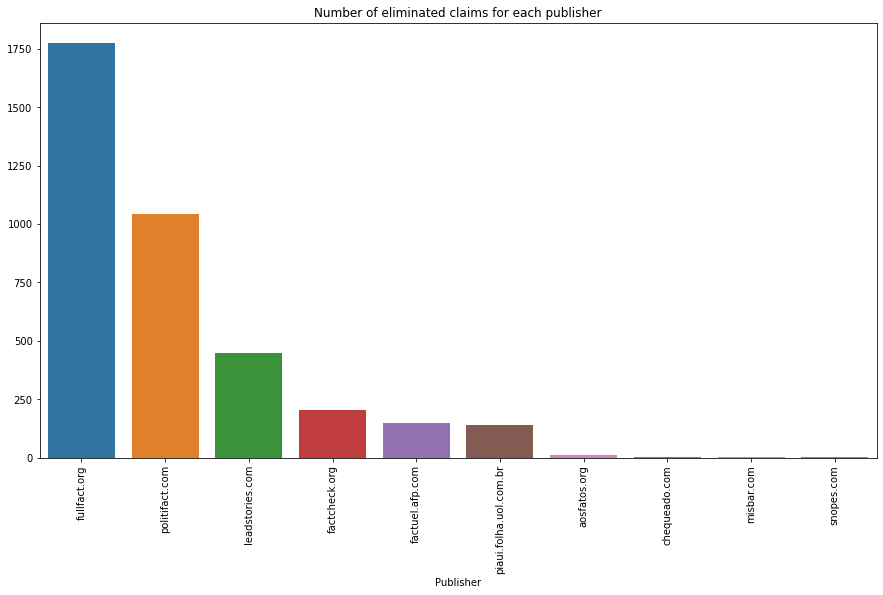

In [ ]:
plt.figure(figsize = (15,8))
plt.title("Number of eliminated claims for each publisher")
plt.xlabel('Publisher')
plt.xticks(rotation=90)
ax = sns.countplot(data=df_excluded, x='publisherSite', order = df_excluded['publisherSite'].value_counts().index)
ax.set(xlabel='Publisher', ylabel='')

Of the eliminated ones:
 - aosfatos.org, chequeado.com, misbar.com, piaui.folha.uol.com.br, snopes.com weren't rating those specific claims (either because impossible to check or because they were still working on them)
 - factcheck.org, factuel.afp.com, fullfact.org, leadstories.com were using comments rather than ratings, making it impossible to automate the process

### Update claims of pagellapolitica.it
These claims were scraped directly from the web pages

In [ ]:
link = "https://drive.google.com/file/d/1JszEFOjcr1W7AUwXMOpYn0uGnth88D9m/view?usp=sharing"
id = "1JszEFOjcr1W7AUwXMOpYn0uGnth88D9m" 
name = "pagellapolitica.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
df_pagella = pd.read_csv('pagellapolitica.csv')
print(df_pagella.info())
df_pagella.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1209 entries, 0 to 1208
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   claim          1200 non-null   object
 1   claimant       1199 non-null   object
 2   claimDate      1205 non-null   object
 3   url            1209 non-null   object
 4   reviewTitle    1202 non-null   object
 5   reviewDate     1207 non-null   object
 6   Rating         1209 non-null   object
 7   languageCode   1209 non-null   object
 8   publisherName  1209 non-null   object
 9   publisherSite  1209 non-null   object
 10  row            1209 non-null   int64 
 11  tot            1209 non-null   int64 
 12  is_successful  1209 non-null   int64 
 13  claimLink      1196 non-null   object
dtypes: int64(3), object(11)
memory usage: 132.4+ KB
None


claim  ...                                          claimLink
0  \n«Non possiamo nasconderci quello che in ques...  ...  http://www.senato.it/japp/bgt/showdoc/frame.js...
1  \n«L’ex tesoriere Pd Zanda e l’ex senatrice de...  ...  https://www.facebook.com/eliolannuttisenato/po...
2  \n«In Italia abbiamo un bicameralismo paritari...  ...  https://www.facebook.com/260257847775408/posts...
3  \n«Quando ero sindaco io ne ricevevo anche 2.6...  ...  https://www.huffingtonpost.it/entry/non-ce-alc...
4  \n«Tutti gli altri Paesi europei o hanno già r...  ...  https://www.facebook.com/salviniofficial/posts...

[5 rows x 14 columns]

In [ ]:
df_pagella = df_pagella[~df_pagella['claim'].isna()]
df_pagella['claim'] = df_pagella['claim'].apply(lambda row: row.replace('\n', ''))
df_pagella = df_pagella.drop(df_pagella.columns.difference(['claim', 'url', 'claimLink']), axis=1)
df_pagella = df_pagella.rename(columns = {'claim': 'scrapedClaim'})
print(df_pagella.info())
df_pagella.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1208
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   scrapedClaim  1200 non-null   object
 1   url           1200 non-null   object
 2   claimLink     1196 non-null   object
dtypes: object(3)
memory usage: 37.5+ KB
None


scrapedClaim  ...                                          claimLink
0  «Non possiamo nasconderci quello che in queste...  ...  http://www.senato.it/japp/bgt/showdoc/frame.js...
1  «L’ex tesoriere Pd Zanda e l’ex senatrice demo...  ...  https://www.facebook.com/eliolannuttisenato/po...
2  «In Italia abbiamo un bicameralismo paritario ...  ...  https://www.facebook.com/260257847775408/posts...
3  «Quando ero sindaco io ne ricevevo anche 2.600...  ...  https://www.huffingtonpost.it/entry/non-ce-alc...
4  «Tutti gli altri Paesi europei o hanno già ria...  ...  https://www.facebook.com/salviniofficial/posts...

[5 rows x 3 columns]

In [ ]:
def switchClaims(row):
  if not pd.isnull(row['scrapedClaim']):
    return row['scrapedClaim']
  return row['claim']

df_uniform = pd.merge(df_uniform, df_pagella, how='left', on=['url'])
df_uniform['claim'] = df_uniform.apply(switchClaims, axis=1)
df_uniform = df_uniform.drop(columns=['scrapedClaim'], axis=1)

In [ ]:
df_uniform[df_uniform['publisherSite'] == 'pagellapolitica.it'].head()

claim  ...                                          claimLink
25103  «Non possiamo nasconderci quello che in queste...  ...  http://www.senato.it/japp/bgt/showdoc/frame.js...
25104  «L’ex tesoriere Pd Zanda e l’ex senatrice demo...  ...  https://www.facebook.com/eliolannuttisenato/po...
25105  «In Italia abbiamo un bicameralismo paritario ...  ...  https://www.facebook.com/260257847775408/posts...
25106  «Quando ero sindaco io ne ricevevo anche 2.600...  ...  https://www.huffingtonpost.it/entry/non-ce-alc...
25107  «Tutti gli altri Paesi europei o hanno già ria...  ...  https://www.facebook.com/salviniofficial/posts...

[5 rows x 12 columns]

In [ ]:
df_uniform.head()

claim  ... claimLink
0                      Vandalism by Muslim in Sweden  ...       NaN
1   Two Muslim women fall into sewage drain in Delhi  ...       NaN
2                  दिल्ली में 2 महिलाएं गटर में गिरी  ...       NaN
3  Saddam Hussein's body looking the same as it d...  ...       NaN
4                   Hindu woman killed in love Jihad  ...       NaN

[5 rows x 12 columns]

### Update claims of Politifact.com
As seen in the section dedicated to Politifact.com, we had to retrieve again some of the information, like reviewTitle and reviewDate. We also need to merge all the info in a single dataset

In [ ]:
link = "https://drive.google.com/file/d/1OHh-YJ7VxFlr8njy_S_nleztILJebA1b/view?usp=sharing"
id = "1OHh-YJ7VxFlr8njy_S_nleztILJebA1b" 
name = "factcheck_politifact0.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1ktj7c_nqsEDc0w6nN2YknXM0mQ4KqYnE/view?usp=sharing"
id = "1ktj7c_nqsEDc0w6nN2YknXM0mQ4KqYnE" 
name = "factcheck_politifact1.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1HCLGZ5wG3RSEtVjMn-djX5K9ByjTqput/view?usp=sharing"
id = "1HCLGZ5wG3RSEtVjMn-djX5K9ByjTqput" 
name = "factcheck_politifact2.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1zj1QuUWeVZWA9xs2vqdmDWYXNZddEZD4/view?usp=sharing"
id = "1zj1QuUWeVZWA9xs2vqdmDWYXNZddEZD4" 
name = "factcheck_politifact3.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/11HhTXurCoaP6umB-lN-ZPpY6uro3JLZF/view?usp=sharing"
id = "11HhTXurCoaP6umB-lN-ZPpY6uro3JLZF" 
name = "factcheck_politifact4.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1VjnQlckiY0AFGVmd9THHb6NtDSG2_Gh1/view?usp=sharing"
id = "1VjnQlckiY0AFGVmd9THHb6NtDSG2_Gh1" 
name = "factcheck_politifact5.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1tVOIdhOb1RMHhrnskoNWp6ACUeEnWQMg/view?usp=sharing"
id = "1tVOIdhOb1RMHhrnskoNWp6ACUeEnWQMg" 
name = "factcheck_politifact6.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1NcY0jaIhOFxeF57TrsvoI6WRiZcW3u-J/view?usp=sharing"
id = "1NcY0jaIhOFxeF57TrsvoI6WRiZcW3u-J" 
name = "factcheck_politifact7.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/17bdShjsoZditnQNR6ZbaUTm5aL9U3aIy/view?usp=sharing"
id = "17bdShjsoZditnQNR6ZbaUTm5aL9U3aIy" 
name = "factcheck_politifact8.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
df_politifact = pd.DataFrame()
for i in range(0,9):
  df_politifact = pd.concat([df_politifact, pd.read_csv('factcheck_politifact0.csv')])

In [ ]:
print(df_politifact.info())
df_politifact.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15597 entries, 0 to 1732
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   claim          15597 non-null  object 
 1   claimant       15597 non-null  object 
 2   url            15597 non-null  object 
 3   reviewDate     15408 non-null  object 
 4   Rating         15597 non-null  object 
 5   languageCode   15597 non-null  object 
 6   publisherName  15597 non-null  object 
 7   publisherSite  15597 non-null  object 
 8   claimLink      0 non-null      float64
 9   UniformRating  15597 non-null  object 
 10  is_successful  15597 non-null  int64  
 11  reviewTitle    15597 non-null  object 
dtypes: float64(1), int64(1), object(10)
memory usage: 1.5+ MB
None


claim  ...                                        reviewTitle
0  Kamala Harris said, "I don't like Joe Biden an...  ...  \nNo evidence the Odessa shooter had a sticker...
1  Condoleezza Rice said, "If you are taught bitt...  ...  \nNo evidence the Odessa shooter had a sticker...
2  A coloring book that describes Joe Biden as "A...  ...  \nNo evidence the Odessa shooter had a sticker...
3  "In West Virginia alone, overdoses have increa...  ...  \nNo evidence the Odessa shooter had a sticker...
4  The United States is "the only major industria...  ...  \nNo evidence the Odessa shooter had a sticker...

[5 rows x 12 columns]

We need to adjust the reviewDate column

In [ ]:
df_politifact['reviewDate'] = df_politifact['reviewDate'].apply(lambda row: row if pd.isnull(row) else row[11:])
df_politifact['reviewDate'] = df_politifact['reviewDate'].apply(lambda row: row if pd.isnull(row) else row.split(", 20")[0] + ", 20" + row.split(", 20")[1][:2])
df_politifact['reviewDate'] = pd.to_datetime(df_politifact['reviewDate'])

In [ ]:
df_politifact.to_csv("factcheck_complete_politifact.csv", index=False)
save_file_to_drive("factcheck_complete_politifact.csv", "factcheck_complete_politifact.csv")

File ID: 1YzXKihpG4lQG-Ix8m4i6TbZEUVQSd-3f


{'id': '1YzXKihpG4lQG-Ix8m4i6TbZEUVQSd-3f'}

### Add article bodies
Finally we can merge this dataset with the article bodies

In [ ]:
publishers = ['Uol', 'vishvasnews', 'snopes', 'politicaestadao', 'poligrafo', 'pagellapolitica', 'newtral', \
             'misbar', 'leadstories', 'fullfact', 'factuel', 'factual', 'factly', 'factcheckORG', 'chequeado', \
             'checkyourfact', 'boomlive', 'boatos', 'aosfatos', 'altnews', 'AFPFactcheck']

#### Download articles from Google Drive

In [ ]:
link = "https://drive.google.com/file/d/1-U5Um5iiwBLYcmXCZ9U2mjsk7-X5H4NM/view?usp=sharing"
id = "1-U5Um5iiwBLYcmXCZ9U2mjsk7-X5H4NM"
name = "AFPFactcheck.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/18aarLMKA22u_RhiwgJZ11zOvJH1Ot4fQ/view?usp=sharing"
id = "18aarLMKA22u_RhiwgJZ11zOvJH1Ot4fQ"
name = "altnews.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1SKvpiFM5vcou_JPlaHhgji2dyfZRCU5b/view?usp=sharing"
id = "1SKvpiFM5vcou_JPlaHhgji2dyfZRCU5b"
name = "aosfatos.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1qtJ1dpyKJCAtGPVdljYOvOkWc0fU7BoY/view?usp=sharing"
id = "1qtJ1dpyKJCAtGPVdljYOvOkWc0fU7BoY"
name = "boatos.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/19p0TmrTp0RkBXF9m67Ar6MuE8BRS-1Pw/view?usp=sharing"
id = "19p0TmrTp0RkBXF9m67Ar6MuE8BRS-1Pw"
name = "boomlive.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1BPTA9QChgqopvU6IP1oA3HKcjMKkXDD9/view?usp=sharing"
id = "1BPTA9QChgqopvU6IP1oA3HKcjMKkXDD9"
name = "checkyourfact.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1fkeV35s9qIOl404N2_dnjCETAym4l-CX/view?usp=sharing"
id = "1fkeV35s9qIOl404N2_dnjCETAym4l-CX"
name = "chequeado.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1Zz2A1EEtwd1Nqfvnj8_o9J-gMkl_Vv1Q/view?usp=sharing"
id = "1Zz2A1EEtwd1Nqfvnj8_o9J-gMkl_Vv1Q"
name = "factcheckORG.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1tOHZPxg4Dmz61lsjD4EoKsoFwgOtxc3w/view?usp=sharing"
id = "1tOHZPxg4Dmz61lsjD4EoKsoFwgOtxc3w"
name = "factly.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1Yr4GgXGrBeaOpbUX4r3PaODLarPchGLf/view?usp=sharing"
id = "1Yr4GgXGrBeaOpbUX4r3PaODLarPchGLf"
name = "factual.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1YfaaC90j57Q9biP6orUdlJJ2ffnx0Czn/view?usp=sharing"
id = "1YfaaC90j57Q9biP6orUdlJJ2ffnx0Czn"
name = "factuel.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1dEJuFN2Lmj8T0ioI-K3GtfXBZGF_DBiJ/view?usp=sharing"
id = "1dEJuFN2Lmj8T0ioI-K3GtfXBZGF_DBiJ"
name = "fullfact.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1Sz3AHVjpBKIbyhABiBXhWI08Sq0BA0nb/view?usp=sharing"
id = "1Sz3AHVjpBKIbyhABiBXhWI08Sq0BA0nb"
name = "leadstories.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1y8Nix9bN4Mf4aLE67OMTXeWJeeBdjn3b/view?usp=sharing"
id = "1y8Nix9bN4Mf4aLE67OMTXeWJeeBdjn3b"
name = "misbar.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1aHRDcTadieFTQ8jZBwBCaAajtYrpZXcI/view?usp=sharing"
id = "1aHRDcTadieFTQ8jZBwBCaAajtYrpZXcI"
name = "newtral.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1V3I7_CL79v482uRTHYBdg8UHDxkZyXji/view?usp=sharing"
id = "1V3I7_CL79v482uRTHYBdg8UHDxkZyXji"
name = "pagellapolitica.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1H_T8ZhVwut9-LOHQoXwI_Ohi3pHbP6un/view?usp=sharing"
id = "1H_T8ZhVwut9-LOHQoXwI_Ohi3pHbP6un"
name = "poligrafo.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1gT-mcBwHGqvEPDs3-ePCzWK7a9q5IMT4/view?usp=sharing"
id = "1gT-mcBwHGqvEPDs3-ePCzWK7a9q5IMT4"
name = "politicaestadao.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1H7ItrlehVZ2zNzJSage5u8CRNN8VqoY1/view?usp=sharing"
id = "1H7ItrlehVZ2zNzJSage5u8CRNN8VqoY1"
name = "snopes.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1P-LUEk8m49jkLDxORDyldU2q31tDc8yq/view?usp=sharing"
id = "1P-LUEk8m49jkLDxORDyldU2q31tDc8yq"
name = "Uol.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1UbO7Vo1XckxW5X_LnGdOQTxXvgn4VuLZ/view?usp=sharing"
id = "1UbO7Vo1XckxW5X_LnGdOQTxXvgn4VuLZ"
name = "vishvasnews.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
for publisher in publishers:
  shutil.move("/content/" + publisher + ".txt", "/content/Articles/" + publisher + ".txt")

#### Download Politifact articles
Politifact articles are divided into 10 groups

In [ ]:
link = "https://drive.google.com/file/d/1CLCxEa_-bQsrD-RGXw4HIEXN66V9vtCp/view?usp=sharing"
id = "1CLCxEa_-bQsrD-RGXw4HIEXN66V9vtCp" 
name = "politifact0.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1nKe0-tU1UsIyheci60PhbQRVXHO-5cxP/view?usp=sharing"
id = "1nKe0-tU1UsIyheci60PhbQRVXHO-5cxP" 
name = "politifact1.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/10Pk1SQj-RPlQIOwUJGpBsuNm2AwkfKSL/view?usp=sharing"
id = "10Pk1SQj-RPlQIOwUJGpBsuNm2AwkfKSL" 
name = "politifact2.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1YupkSmkcP--XAC41ENyU1ZjWE0zTxjpE/view?usp=sharing"
id = "1YupkSmkcP--XAC41ENyU1ZjWE0zTxjpE" 
name = "politifact3.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "hhttps://drive.google.com/file/d/1LSWy__yvQVo6GjbmTqDptu1Kcx4cyuMs/view?usp=sharing"
id = "1LSWy__yvQVo6GjbmTqDptu1Kcx4cyuMs" 
name = "politifact4.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1fbncxkUJS4RbT-yum9NL1NO49AakZEoq/view?usp=sharing"
id = "1fbncxkUJS4RbT-yum9NL1NO49AakZEoq" 
name = "politifact5.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/15bRXN6NfghlZh7S8D2FtvOGjHS5ognzX/view?usp=sharing"
id = "15bRXN6NfghlZh7S8D2FtvOGjHS5ognzX" 
name = "politifact6.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1jn_evCecwJwnruj63UcTvIQ8boVbcg8r/view?usp=sharing"
id = "1jn_evCecwJwnruj63UcTvIQ8boVbcg8r" 
name = "politifact7.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1C7zTRynb7jgXu-CMRYfyjR2Z9kvtgrjt/view?usp=sharing"
id = "1C7zTRynb7jgXu-CMRYfyjR2Z9kvtgrjt" 
name = "politifact8.txt"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
for i in range(0,9):
  shutil.move("/content/politifact" + str(i) + ".txt", "/content/Articles/politifact" + str(i) + ".txt")

#### Join datasets
After importing the txt files, we create a pandas Dataframe with the info contained in them. Then we join the resulting dataset with the one created in the previous steps.

In [ ]:
import ast

article_infos = []
for publisher in publishers:

  #There was an issue with vishvasnews, so we need to skip this now
  if publisher == 'vishvasnews':
    continue

  #Read every file line by line, turn each line into a dictionary
  with open("./Articles/" + publisher + ".txt", "r") as f:
    line = f.readline()
    while line:
      try:
        article_info = ast.literal_eval(line) #Reads string as dictionary
        article_infos.append(article_info)
      except:
        print(line)
      line = f.readline()

In [ ]:
#Some of the rows have publisherName = nan; this causes the ast.literal_eval() function to crash
with open("./Articles/vishvasnews.txt", "r", encoding="utf-8") as f:
  line = f.readline()
  while line:
    try:
      article_info = ast.literal_eval(line)
    except:
      line = line.replace(': nan', ": 'vishvasnews'")
      article_info = ast.literal_eval(line)
    article_infos.append(article_info)
    line = f.readline()

Let's look for a moment at the resulting dataset: It has 41448 entries, of which 9 have a null claim value. Looking into those, we see that they're all from pagellapolitica.it and must have been a result of an incorrect scrape. We get rid of those. We can also get rid of some of the columns.

In [ ]:
df_articles = pd.DataFrame(article_infos)
print("Number of articles: ", len(df_articles))
print(df_articles.info())
df_articles.head()

Number of articles:  41448
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41448 entries, 0 to 41447
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   claim           41439 non-null  object
 1   url             41448 non-null  object
 2   lang            41448 non-null  object
 3   publisher_site  41448 non-null  object
 4   publisher_name  41448 non-null  object
 5   articleBody     41448 non-null  object
 6   imageUrl        41448 non-null  object
dtypes: object(7)
memory usage: 2.2+ MB
None


claim  ...                                           imageUrl
0  Esse KIT foi disponibilizado pelo GOVERNO FEDE...  ...  https://piaui.folha.uol.com.br/lupa/wp-content...
1  Usar máscara de pano protege você o tanto que ...  ...  https://piaui.folha.uol.com.br/lupa/wp-content...
2  “A justiça concluiu o Padre Robson é INOCENTE ...  ...  https://piaui.folha.uol.com.br/lupa/wp-content...
3  Califórnia aprovou nas duas casas legislativas...  ...  https://piaui.folha.uol.com.br/lupa/wp-content...
4  “Adélio Bispo é o único homicida brasileiro cu...  ...  https://piaui.folha.uol.com.br/lupa/wp-content...

[5 rows x 7 columns]

In [ ]:
df_articles = df_articles[~df_articles['claim'].isna()]
df_articles = df_articles.drop(df_articles.columns.difference(['claim', 'url', 'articleBody', 'imageUrl', 'publisher_site']), axis=1)

There's a slight discrepancy with the length of the other dataset (39393 entries) due to the elimination of those claims with an inadequate rating system.

In [ ]:
len(df_uniform)

39393

We can now join the two datasets. As a recap, we have:
 - df_articles: which contains 'claim', 'url', 'articleBody' and 'imageUrl'
 - df_uniform: which contains 'claim', 'claimant', 'claimDate', 'url', 'reviewTitle', 'reviewDate', 'Rating', 'languageCode', 'publisherName', 'publisherSite', 'RatingNew', 'claimLink'

 Join is performed on 'url' and 'claim' for publishers whose claims weren't modified in any part of this process, while it is performed only on 'url' if we had to modify the 'claim' column

In [ ]:
modified_publishers = ['pagellapolitica.it']

#We apply a left join, so all the rows of df_uniform will remain, while only the matching rows from df_Articles will be added 
#(If a row in df_uniform can't match, its remaining columns are classified 'NaN')
df_complete_no_modification = pd.merge(df_uniform[~df_uniform['publisherSite'].isin(modified_publishers)], df_articles, how='left', on=['claim', 'url'])
df_complete_w_modification = pd.merge(df_uniform[df_uniform['publisherSite'].isin(modified_publishers)], df_articles.drop(columns=['claim']), how='left', on=['url'])
df_complete = pd.concat([df_complete_no_modification, df_complete_w_modification])

df_complete = df_complete.drop(columns=['publisher_site'])
df_complete = df_complete.rename(columns={'RatingNew': 'UniformRating'})

In [ ]:
print("Length of the dataset: ", len(df_complete))
df_complete = df_complete.drop_duplicates() 
print("Length after removing duplicates: ", len(df_complete))
df_complete = df_complete[~df_complete['articleBody'].isna()]
print("Length after removing null article bodies: ", len(df_complete))
print(df_complete.info())
df_complete.head()

Length of the dataset:  40596
Length after removing duplicates:  39081
Length after removing null article bodies:  37235
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37235 entries, 0 to 2358
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   claim          37235 non-null  object
 1   claimant       30572 non-null  object
 2   claimDate      30593 non-null  object
 3   url            37235 non-null  object
 4   reviewTitle    37042 non-null  object
 5   reviewDate     36749 non-null  object
 6   Rating         37235 non-null  object
 7   languageCode   37235 non-null  object
 8   publisherName  35555 non-null  object
 9   publisherSite  37235 non-null  object
 10  UniformRating  37235 non-null  object
 11  claimLink      1440 non-null   object
 12  articleBody    37235 non-null  object
 13  imageUrl       37235 non-null  object
dtypes: object(14)
memory usage: 4.3+ MB
None


claim  ...                                           imageUrl
0                      Vandalism by Muslim in Sweden  ...  https://i2.wp.com/www.altnews.in/wp-content/up...
1   Two Muslim women fall into sewage drain in Delhi  ...  https://i1.wp.com/www.altnews.in/wp-content/up...
2                  दिल्ली में 2 महिलाएं गटर में गिरी  ...  https://i1.wp.com/www.altnews.in/hindi/wp-cont...
3  Saddam Hussein's body looking the same as it d...  ...  https://i2.wp.com/www.altnews.in/wp-content/up...
4                   Hindu woman killed in love Jihad  ...  https://i1.wp.com/www.altnews.in/wp-content/up...

[5 rows x 14 columns]

In [ ]:
df_complete.to_csv('factcheck_articles.csv', index=False)
save_file_to_drive("factcheck_articles.csv", 'factcheck_articles.csv')

File ID: 1MA21Yg21EHsoIE1MIkWO84I2k__MZOP3


{'id': '1MA21Yg21EHsoIE1MIkWO84I2k__MZOP3'}

#### Join Politifact claims
Politifact claims were subdivided and scraped in a different manner than all the other publisher, so we treat them separately

In [ ]:
#Politifact articles are divided into ten groups
article_infos = []
for i in range(0,9):

  #Read every file line by line, turn each line into a dictionary
  with open("./Articles/politifact" + str(i) + ".txt", "r") as f:
    line = f.readline()
    while line:
      try:
        article_info = ast.literal_eval(line) #Reads string as dictionary
        article_infos.append(article_info)
      except:
        print(line)
      line = f.readline()

In [ ]:
df_articles = pd.DataFrame(article_infos).drop_duplicates()
print("Number of articles: ", len(df_articles))
print(df_articles.info())
df_articles.head()

Number of articles:  15055
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15055 entries, 0 to 116022
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   claim           15055 non-null  object
 1   url             15055 non-null  object
 2   lang            15055 non-null  object
 3   publisher_site  15055 non-null  object
 4   publisher_name  15055 non-null  object
 5   articleBody     15055 non-null  object
 6   imageUrl        15055 non-null  object
dtypes: object(7)
memory usage: 940.9+ KB
None


claim  ...                                           imageUrl
0  Kamala Harris said, "I don't like Joe Biden an...  ...  https://static.politifact.com/CACHE/images/pol...
1  Condoleezza Rice said, "If you are taught bitt...  ...                                               None
2  A coloring book that describes Joe Biden as "A...  ...                                               None
3  "In West Virginia alone, overdoses have increa...  ...  https://static.politifact.com/CACHE/images/pol...
4  The United States is "the only major industria...  ...  https://static.politifact.com/CACHE/images/pol...

[5 rows x 7 columns]

In [ ]:
df_articles.to_csv('factcheck_articles_politifact.csv', index=False)
save_file_to_drive('factcheck_articles_politifact.csv', 'factcheck_articles_politifact.csv')

File ID: 1mdcV8Sh2aOxNqB0CKjmY6ttNpLuFrIf4


{'id': '1mdcV8Sh2aOxNqB0CKjmY6ttNpLuFrIf4'}

In [ ]:
link = "https://drive.google.com/file/d/1YzXKihpG4lQG-Ix8m4i6TbZEUVQSd-3f/view?usp=sharing"
id = "1YzXKihpG4lQG-Ix8m4i6TbZEUVQSd-3f" 
name = "factcheck_complete_politifact.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
df_polifact = pd.read_csv('factcheck_complete_politifact.csv')

In [ ]:
df_politifact_factcheck = pd.merge(df_politifact, df_articles, how="left", on=['claim'])

In [ ]:
print(df_politifact.info())
df_politifact_factcheck.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15597 entries, 0 to 1732
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   claim          15597 non-null  object        
 1   claimant       15597 non-null  object        
 2   url            15597 non-null  object        
 3   reviewDate     15408 non-null  datetime64[ns]
 4   Rating         15597 non-null  object        
 5   languageCode   15597 non-null  object        
 6   publisherName  15597 non-null  object        
 7   publisherSite  15597 non-null  object        
 8   claimLink      0 non-null      float64       
 9   UniformRating  15597 non-null  object        
 10  is_successful  15597 non-null  int64         
 11  reviewTitle    15597 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(9)
memory usage: 1.5+ MB
None


claim  ...                                           imageUrl
0  Kamala Harris said, "I don't like Joe Biden an...  ...  https://static.politifact.com/CACHE/images/pol...
1  Condoleezza Rice said, "If you are taught bitt...  ...                                               None
2  A coloring book that describes Joe Biden as "A...  ...                                               None
3  "In West Virginia alone, overdoses have increa...  ...  https://static.politifact.com/CACHE/images/pol...
4  The United States is "the only major industria...  ...  https://static.politifact.com/CACHE/images/pol...

[5 rows x 18 columns]

In [ ]:
df_politifact_factcheck = df_politifact_factcheck.drop(columns=['url_x']).rename(columns={'url_y':"url"})

In [ ]:
df_politifact_factcheck.to_csv('factcheck_articles_politifact.csv', index=False)
save_file_to_drive('factcheck_articles_politifact.csv', 'factcheck_articles_politifact.csv')

File ID: 1cP7g3-ANaLFUW7OXXZmYIojMDMpfBLIV


{'id': '1cP7g3-ANaLFUW7OXXZmYIojMDMpfBLIV'}

## Final dataset
Finally the dataset is ready, so we can perform some analysis on it

### Merge publishers with Politifact

In [ ]:
link = "https://drive.google.com/file/d/1cP7g3-ANaLFUW7OXXZmYIojMDMpfBLIV/view?usp=sharing"
id = "1cP7g3-ANaLFUW7OXXZmYIojMDMpfBLIV" 
name = "factcheck_articles_politifact.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
link = "https://drive.google.com/file/d/1MA21Yg21EHsoIE1MIkWO84I2k__MZOP3/view?usp=sharing"
id = "1MA21Yg21EHsoIE1MIkWO84I2k__MZOP3" 
name = "factcheck_articles.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
df_factcheck = pd.read_csv('factcheck_articles.csv')
df_factcheck_politifact = pd.read_csv('factcheck_articles_politifact.csv')
print(df_factcheck.info())
print(df_factcheck_politifact.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37235 entries, 0 to 37234
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   claim          37235 non-null  object
 1   claimant       30572 non-null  object
 2   claimDate      30593 non-null  object
 3   url            37235 non-null  object
 4   reviewTitle    37042 non-null  object
 5   reviewDate     36749 non-null  object
 6   Rating         37235 non-null  object
 7   languageCode   37235 non-null  object
 8   publisherName  35555 non-null  object
 9   publisherSite  37235 non-null  object
 10  UniformRating  37235 non-null  object
 11  claimLink      1440 non-null   object
 12  articleBody    37232 non-null  object
 13  imageUrl       37235 non-null  object
dtypes: object(14)
memory usage: 4.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15642 entries, 0 to 15641
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---

In [ ]:
df_factcheck_politifact = df_factcheck_politifact.drop(columns=['is_successful', 'lang', 'publisher_name', 'publisher_site'])
df_factcheck_politifact['claimDate'] = 'None'
df_final = pd.concat([df_factcheck, df_factcheck_politifact])

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52877 entries, 0 to 15641
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   claim          52877 non-null  object
 1   claimant       46214 non-null  object
 2   claimDate      46235 non-null  object
 3   url            52877 non-null  object
 4   reviewTitle    52684 non-null  object
 5   reviewDate     52202 non-null  object
 6   Rating         52877 non-null  object
 7   languageCode   52877 non-null  object
 8   publisherName  51197 non-null  object
 9   publisherSite  52877 non-null  object
 10  UniformRating  52877 non-null  object
 11  claimLink      1440 non-null   object
 12  articleBody    52847 non-null  object
 13  imageUrl       52877 non-null  object
dtypes: object(14)
memory usage: 6.1+ MB


In [ ]:
df_final.to_csv('final_factcheck_articles.csv', index=False)
save_file_to_drive('final_factcheck_articles.csv', 'final_factcheck_articles.csv')

File ID: 1x8n4QkP9izTnaYr8awm0sSDmRZYPkHXl


{'id': '1x8n4QkP9izTnaYr8awm0sSDmRZYPkHXl'}

### Analysis on the final dataset
Now that we have the complete dataset, we can perform some analysis on it

In [ ]:
link = "https://drive.google.com/file/d/1x8n4QkP9izTnaYr8awm0sSDmRZYPkHXl/view?usp=sharing"
id = "1x8n4QkP9izTnaYr8awm0sSDmRZYPkHXl" 
name = "final_factcheck_articles.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
df_final = pd.read_csv('final_factcheck_articles.csv')

In [ ]:
print(df_final.info())
df_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52877 entries, 0 to 52876
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   claim          52877 non-null  object
 1   claimant       46214 non-null  object
 2   claimDate      46235 non-null  object
 3   url            52877 non-null  object
 4   reviewTitle    52684 non-null  object
 5   reviewDate     52202 non-null  object
 6   Rating         52877 non-null  object
 7   languageCode   52877 non-null  object
 8   publisherName  51197 non-null  object
 9   publisherSite  52877 non-null  object
 10  UniformRating  52877 non-null  object
 11  claimLink      1440 non-null   object
 12  articleBody    52847 non-null  object
 13  imageUrl       52877 non-null  object
dtypes: object(14)
memory usage: 5.6+ MB
None


claim  ...                                           imageUrl
0                      Vandalism by Muslim in Sweden  ...  https://i2.wp.com/www.altnews.in/wp-content/up...
1   Two Muslim women fall into sewage drain in Delhi  ...  https://i1.wp.com/www.altnews.in/wp-content/up...
2                  दिल्ली में 2 महिलाएं गटर में गिरी  ...  https://i1.wp.com/www.altnews.in/hindi/wp-cont...
3  Saddam Hussein's body looking the same as it d...  ...  https://i2.wp.com/www.altnews.in/wp-content/up...
4                   Hindu woman killed in love Jihad  ...  https://i1.wp.com/www.altnews.in/wp-content/up...

[5 rows x 14 columns]

We can remove entries without ArticleBody (they were probably due to connection issues or similar)

In [ ]:
df_final = df_final[df_final['articleBody'].isna() == False]

Let's look for a deeper summary

In [ ]:
print("Length: ", len(df_final))
print("\n")
print("Columns: ", df_final.columns.tolist())
print("\n")
print("Oldest claim: ", df_final.sort_values(by='claimDate')['claimDate'][0:1].values, df_final[df_final['claimDate'] == '1970-01-01 00:00:03+00:00']['claim'].values)
print("\n")
print("Newest claim: ", df_final.sort_values(by='claimDate', ascending=False)['claimDate'][0:1].values, df_final[df_final['claimDate'] == '2109-07-01 00:00:00+00:00']['claim'].values)
print("\n")
print("Oldest review: ", df_final.sort_values(by='reviewDate')['reviewDate'][0:1].values, df_final[df_final['reviewDate'] == '1996-08-06 00:00:00+00:00']['claim'].values)
print("\n")
print("Newest review: ", df_final.sort_values(by='reviewDate', ascending=False)['reviewDate'][0:1].values, df_final[df_final['reviewDate'] == '2020-09-06 15:21:58+00:00']['claim'].values)
print("\n")
print("Unique languages: {0} -> {1}\n".format(len(df_final['languageCode'].unique()), df_final['languageCode'].unique().tolist()))
print("Unique publishers: {0} -> {1}\n".format(len(df_final['publisherSite'].unique()), df_final['publisherSite'].unique().tolist()))

Length:  52847


Columns:  ['claim', 'claimant', 'claimDate', 'url', 'reviewTitle', 'reviewDate', 'Rating', 'languageCode', 'publisherName', 'publisherSite', 'UniformRating', 'claimLink', 'articleBody', 'imageUrl']


Oldest claim:  ['1970-01-01 00:00:03+00:00'] ['«Secondo me la Tav va fatta. Anche perché costerebbe di più non farla che farla»\t']


Newest claim:  ['None'] ['Australia doubled its population without building a new power plant or a major water project']


Oldest review:  ['1996-08-06 00:00:00+00:00'] ["Disney animators drew Jessica Rabbit without underwear in a few frames of 'Who Framed Roger Rabbit.'"]


Newest review:  ['2020-09-06 15:21:58+00:00'] ['the image shows the stump of an ancient 10-mile tall tree']


Unique languages: 23 -> ['en', 'hi', 'te', 'ta', 'bn', 'gu', 'mr', 'ml', 'kn', 'pt', 'es', 'pt-pt', 'ar', 'fr', 'nl', 'id', 'si', 'th', 'zh', 'ur', 'pa', 'or', 'it']

Unique publishers: 21 -> ['altnews.in', 'aosfatos.org', 'boatos.org', 'boomlive.in', 'factuel.af

Some of the languages look minority and some can probably be merged (like pt and pt-pt). It could also be useful to add the language name on top of the code.

In [ ]:
df_final['dummy'] = 1
print("Number of articles per language\n")
df_final.groupby(by='languageCode').count()['dummy'].sort_values(ascending=False)

Number of articles per language



languageCode
en       30702
pt        9602
es        4147
hi        3312
it        1444
te        1036
fr         763
ar         560
ur         546
pa         533
mr          50
ml          37
bn          37
ta          34
gu          19
or          10
pt-pt        4
kn           3
th           3
id           2
nl           1
si           1
zh           1
Name: dummy, dtype: int64

In [ ]:
def translateLanguageCode(row):
  if row == 'en':
    return 'English'
  if row == 'pt':
    return 'Portuguese'
  if row == 'es':
    return 'Spanish'
  if row == 'hi':
    return 'Hindi'
  if row == 'it':
    return 'Italian'
  if row == 'te':
    return 'Telugu'
  if row == 'fr':
    return 'French'
  if row == 'ar':
    return 'Arabic'
  if row == 'ur':
    return 'Urdu'
  if row == 'pa':
    return 'Punjabi'
  if row == 'mr':
    return 'Marathi'
  if row == 'ml':
    return 'Malayam'
  if row == 'bn':
    return 'Bengali'
  if row == 'ta':
    return 'Tamil'
  if row == 'gu':
    return 'Gujarati'
  if row == 'or':
    return 'Oriya'
  if row == 'nl':
    return 'Dutch'

#Correct some of the language code info
def adjustLanguageCode(row):
  if row in ['zh', 'si', 'id']:
    return 'en'
  if row in ['th', 'kn']:
    return 'None'
  if row == 'pt-pt':
    return 'pt'
  return row

df_final['languageCode'] = df_final['languageCode'].apply(adjustLanguageCode)
df_final['language'] = df_final['languageCode'].apply(translateLanguageCode)

Now that the language info is more clear, we can remove entries with rarer languages that won't be particularly useful for modelling purposes.

In [ ]:
languages_to_keep = ['en', 'pt', 'es', 'hi', 'it', 'te', 'fr', 'ar', 'ur', 'pa']
df_minor_languages = df_final[~df_final['languageCode'].isin(languages_to_keep)]
df_final = df_final[df_final['languageCode'].isin(languages_to_keep)]
print("New total number of articles: ", len(df_final))
print("\nNumber of articles per language:\n")
df_final.groupby(by='language').count()['dummy'].sort_values(ascending=False)

New total number of articles:  52653

Number of articles per language:



language
English       30706
Portuguese     9606
Spanish        4147
Hindi          3312
Italian        1444
Telugu         1036
French          763
Arabic          560
Urdu            546
Punjabi         533
Name: dummy, dtype: int64

In [ ]:
df_minor_languages.info()
df_minor_languages.to_csv('minor_languages_factcheck.csv', index=False)
save_file_to_drive('minor_languages_factcheck.csv', 'minor_languages_factcheck.csv')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 319 to 35747
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   claim          194 non-null    object
 1   claimant       193 non-null    object
 2   claimDate      193 non-null    object
 3   url            194 non-null    object
 4   reviewTitle    194 non-null    object
 5   reviewDate     194 non-null    object
 6   Rating         194 non-null    object
 7   languageCode   194 non-null    object
 8   publisherName  31 non-null     object
 9   publisherSite  194 non-null    object
 10  UniformRating  194 non-null    object
 11  claimLink      0 non-null      object
 12  articleBody    194 non-null    object
 13  imageUrl       194 non-null    object
 14  dummy          194 non-null    int64 
 15  language       188 non-null    object
dtypes: int64(1), object(15)
memory usage: 25.8+ KB
File ID: 1lRxDaIx3lJEhD-XGduOOL5jTyK_qdJus


{'id': '1lRxDaIx3lJEhD-XGduOOL5jTyK_qdJus'}

Now some graphs

Text(0.5, 1.0, 'Number of articles\nper language')

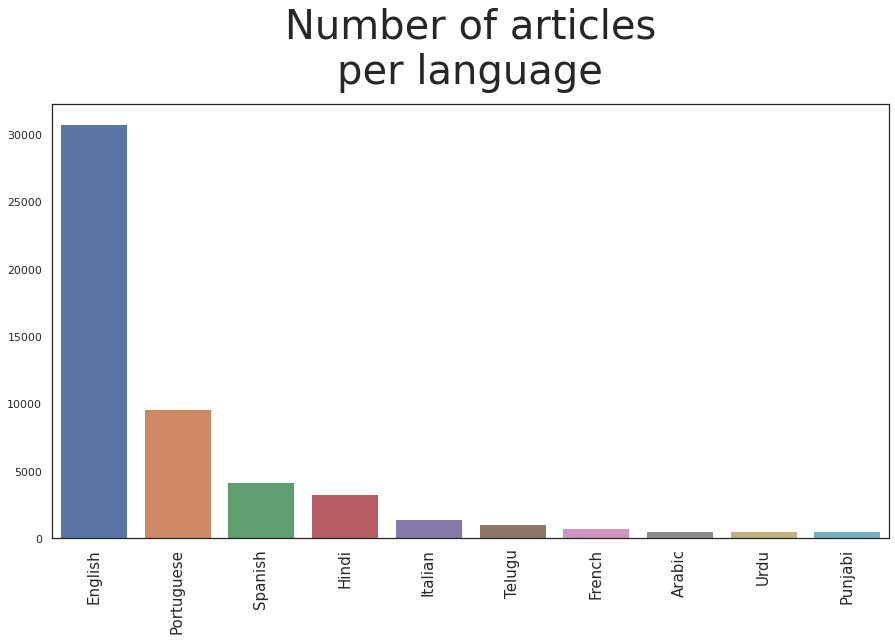

In [ ]:
sns.set(font_scale=1)
sns.set_style('white')
plt.figure(figsize = (15,8))
plt.title('Number of articles per language')
plt.xticks(rotation=90, fontsize=15)
g = sns.countplot(data=df_final, x='language', order = df_final['language'].value_counts().index[:12])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of articles\nper language', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Number of articles\nper publisher')

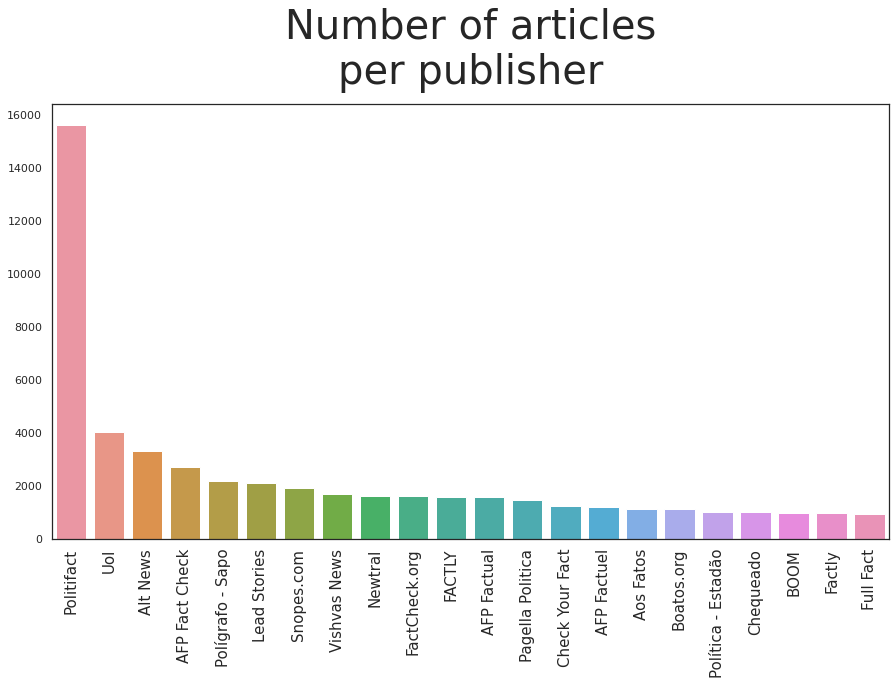

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=90, fontsize=15)
df_final['publisherNameLatinAlphabet'] = df_final['publisherName'].apply(lambda row: 'Vishvas News' if row == 'विश्वास न्यूज़ फैक्ट चेक' else row)
g = sns.countplot(data=df_final, x='publisherNameLatinAlphabet', order = df_final['publisherNameLatinAlphabet'].value_counts().index[:22])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of articles\nper publisher', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Number of articles\nper claimant')

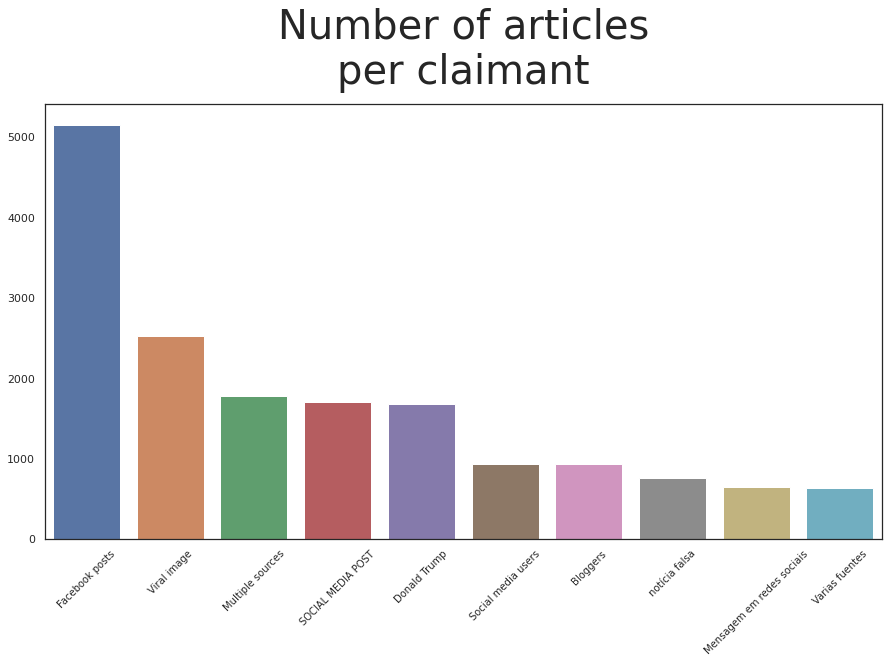

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
df_final['claimantLatinAlphabet'] = df_final['claimant'].apply(lambda row: 'Social media users' if row == 'सोशल मीडिया यूज़र्स' else row)
g = sns.countplot(data=df_final, x='claimantLatinAlphabet', order = df_final['claimantLatinAlphabet'].value_counts().index[:10])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of articles\nper claimant', fontsize = 40, pad=20)

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52653 entries, 0 to 52876
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   claim                       52653 non-null  object
 1   claimant                    45992 non-null  object
 2   claimDate                   46013 non-null  object
 3   url                         52653 non-null  object
 4   reviewTitle                 52460 non-null  object
 5   reviewDate                  51978 non-null  object
 6   Rating                      52653 non-null  object
 7   languageCode                52653 non-null  object
 8   publisherName               51136 non-null  object
 9   publisherSite               52653 non-null  object
 10  UniformRating               52653 non-null  object
 11  claimLink                   1440 non-null   object
 12  articleBody                 52653 non-null  object
 13  imageUrl                    52653 non-null  ob

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0.5, 1.0, 'Number of claims\nper year')

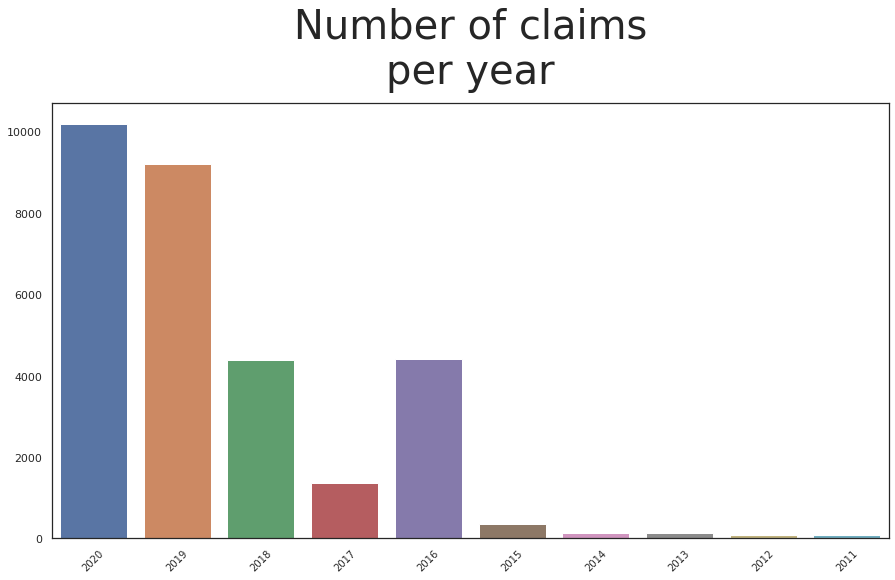

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
df_claimDate = df_final[(df_final['claimDate'].isna() == False) & (df_final['claimDate'] != 'None')]
df_claimDate['claimDate'] = pd.to_datetime(df_claimDate['claimDate'], utc=True)
df_claimDate['claimYear'] = df_claimDate['claimDate'].dt.year
df_claimDate = df_claimDate[df_claimDate['claimYear'].isna() == False]
df_claimDate['claimYear'] = df_claimDate['claimYear'].apply(lambda row: int(row))
g = sns.countplot(data=df_claimDate, x='claimYear', order = df_claimDate['claimYear'].value_counts().index[:10].sort_values(ascending=False))
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of claims\nper year', fontsize = 40, pad=20)

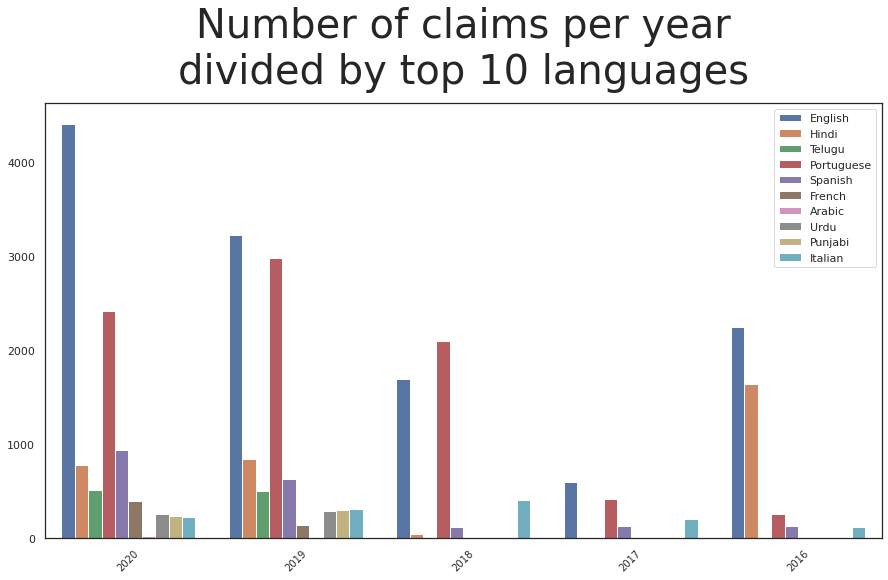

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
g = sns.countplot(data=df_claimDate[df_claimDate['languageCode'].isin(languages_to_keep)], x='claimYear', hue='language', order = df_claimDate['claimYear'].value_counts().index[:5].sort_values(ascending=False))
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of claims per year\ndivided by top 10 languages', fontsize = 40, pad=20)
g.legend( loc = 'upper right')

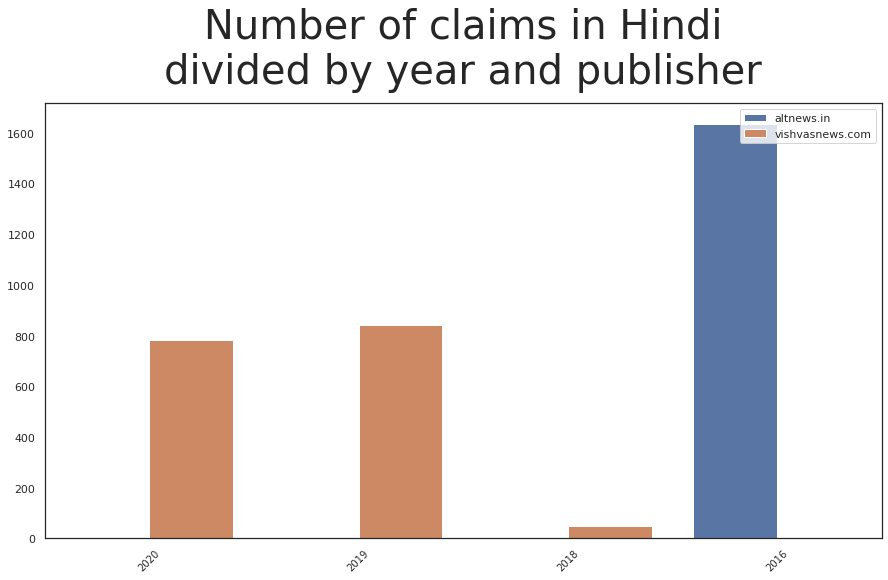

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
df_india_publisher = df_claimDate[(df_claimDate['languageCode'] == 'hi') & (df_claimDate['publisherSite'].isin(['altnews.in', 'vishvasnews.com']))]
g = sns.countplot(data=df_india_publisher, x='claimYear', hue='publisherSite', order = df_india_publisher['claimYear'].value_counts().index.sort_values(ascending=False))
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of claims in Hindi\ndivided by year and publisher', fontsize = 40, pad=20)
g.legend( loc = 'upper right')

No handles with labels found to put in legend.


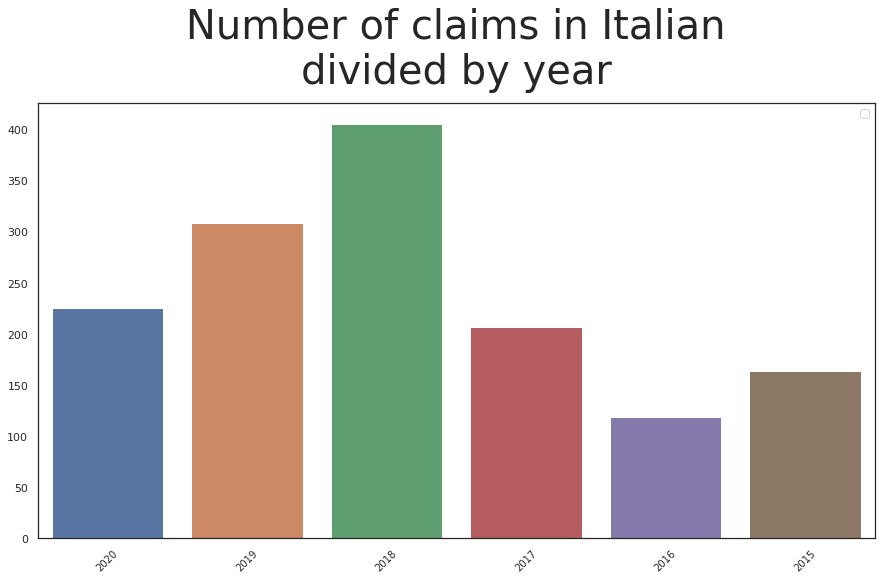

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
df_italy_publisher = df_claimDate[(df_claimDate['languageCode'] == 'it') & (df_claimDate['claimYear'].isin([2020,2019,2018,2017,2016,2015]))]
g = sns.countplot(data=df_italy_publisher, x='claimYear', order = df_italy_publisher['claimYear'].value_counts().index.sort_values(ascending=False))
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of claims in Italian\ndivided by year', fontsize = 40, pad=20)
g.legend( loc = 'upper right')

In [ ]:
df_final[df_final['publisherSite'] == 'altnews.in']['claimDate']

0       2016-06-20 00:00:00+00:00
1       2016-06-20 00:00:00+00:00
2       2016-06-20 00:00:00+00:00
3       2016-06-20 00:00:00+00:00
4       2016-06-20 00:00:00+00:00
                  ...            
3335    2016-06-20 00:00:00+00:00
3336    2016-06-20 00:00:00+00:00
3337    2016-06-20 00:00:00+00:00
3338    2016-06-20 00:00:00+00:00
3339    2016-06-20 00:00:00+00:00
Name: claimDate, Length: 3316, dtype: object

NameError: ignored

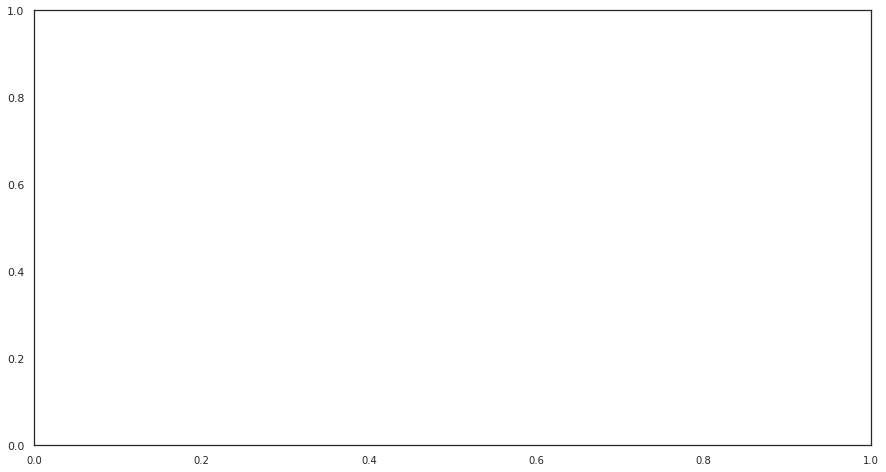

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(fontsize=10)
months_of_year = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df_claimDateIndia = df_claimDate[(df_claimDate['languageCode'] == 'hi') & (df_claimDate['claimYear'] == 2016)]
df_claimDate['claimMonth'] = df_claimDate['claimDate'].dt.month
df_claimDate = df_claimDate[df_claimDate['claimMonth'].isna() == False]
df_claimDate['claimMonth'] = df_claimDate['claimMonth'].apply(lambda row: months_of_year[int(row)-1])
g = sns.countplot(data=df_2016_India[df_2016_India['claimYear'] == 2016], x='claimMonth', order = months_of_year)
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of claims in 2016', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Number of articles\nper claimant')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2360 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2379 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2358 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2354 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2350 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 2368 missing from current font.
  font.set_text(s

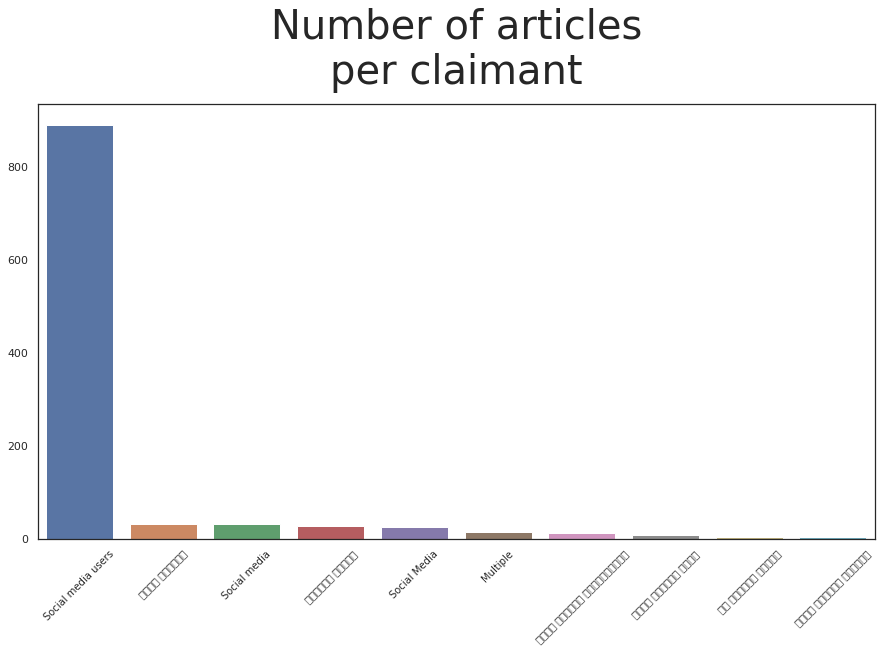

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
df_2016_India = df_claimDate[(df_claimDate['languageCode'] == 'hi') & (df_claimDate['claimYear'] == 2016)]
g = sns.countplot(data=df_2016_India[df_2016_India['claimYear'] == 2016], x='claimantLatinAlphabet', order = df_2016_India['claimantLatinAlphabet'].value_counts().index[:10])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of articles\nper claimant', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


Text(0.5, 1.0, 'Number of reviews\nper year')

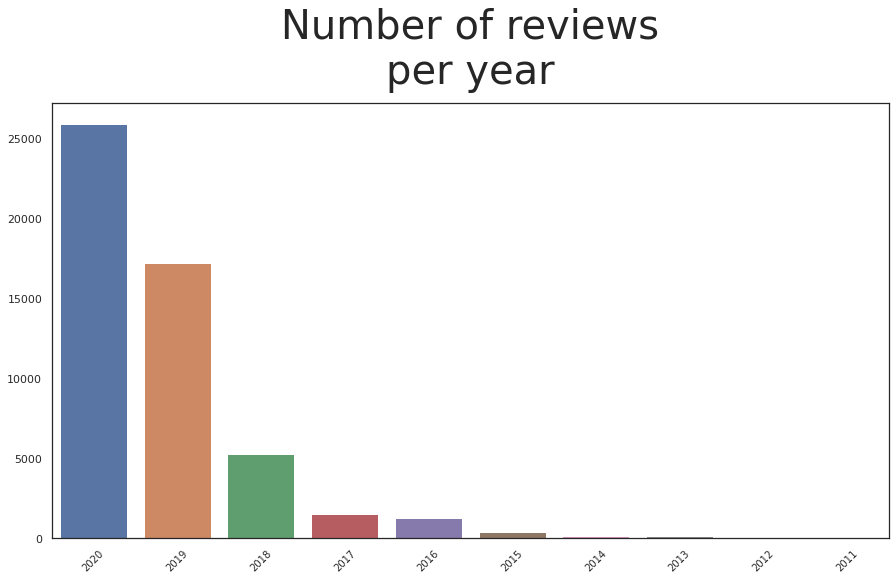

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
df_reviewDate = df_final[(df_final['reviewDate'].isna() == False) & (df_final['reviewDate'] != 'None')]
df_reviewDate['reviewDate'] = pd.to_datetime(df_reviewDate['reviewDate'], utc=True)
df_reviewDate['reviewYear'] = df_reviewDate['reviewDate'].dt.year
df_reviewDate = df_reviewDate[df_reviewDate['reviewYear'].isna() == False]
df_reviewDate['reviewYear'] = df_reviewDate['reviewYear'].apply(lambda row: int(row))
g = sns.countplot(data=df_reviewDate, x='reviewYear', order = df_reviewDate['reviewYear'].value_counts().index[:10].sort_values(ascending=False))
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of reviews\nper year', fontsize = 40, pad=20)

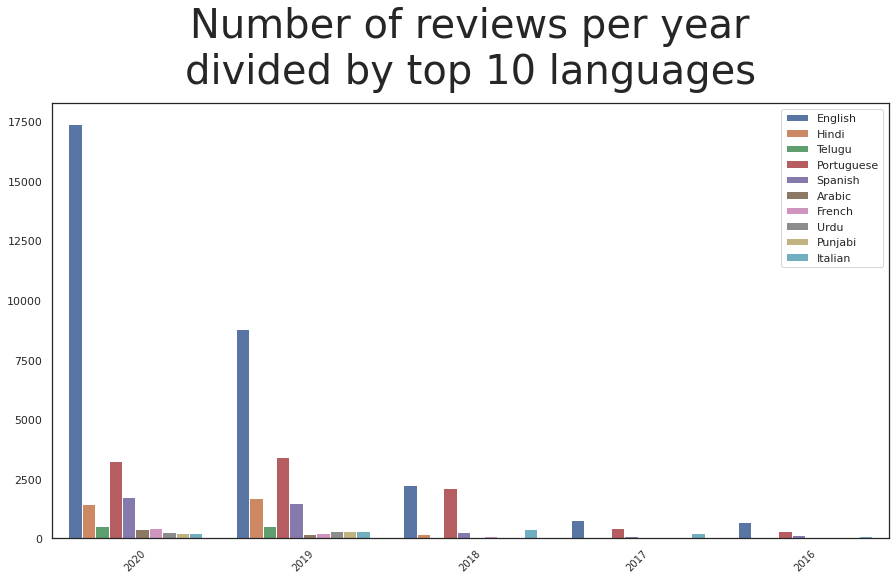

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=45, fontsize=10)
g = sns.countplot(data=df_reviewDate[df_reviewDate['languageCode'].isin(languages_to_keep)], x='reviewYear', hue='language', order = df_reviewDate['reviewYear'].value_counts().index[:5].sort_values(ascending=False))
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of reviews per year\ndivided by top 10 languages', fontsize = 40, pad=20)
g.legend( loc = 'upper right')

In [ ]:
df_final.columns

Index(['claim', 'claimant', 'claimDate', 'url', 'reviewTitle', 'reviewDate',
       'Rating', 'languageCode', 'publisherName', 'publisherSite',
       'UniformRating', 'claimLink', 'articleBody', 'imageUrl', 'dummy',
       'language', 'publisherNameLatinAlphabet', 'claimantLatinAlphabet'],
      dtype='object')

Text(0.5, 1.0, 'Number of articles\nper rating')

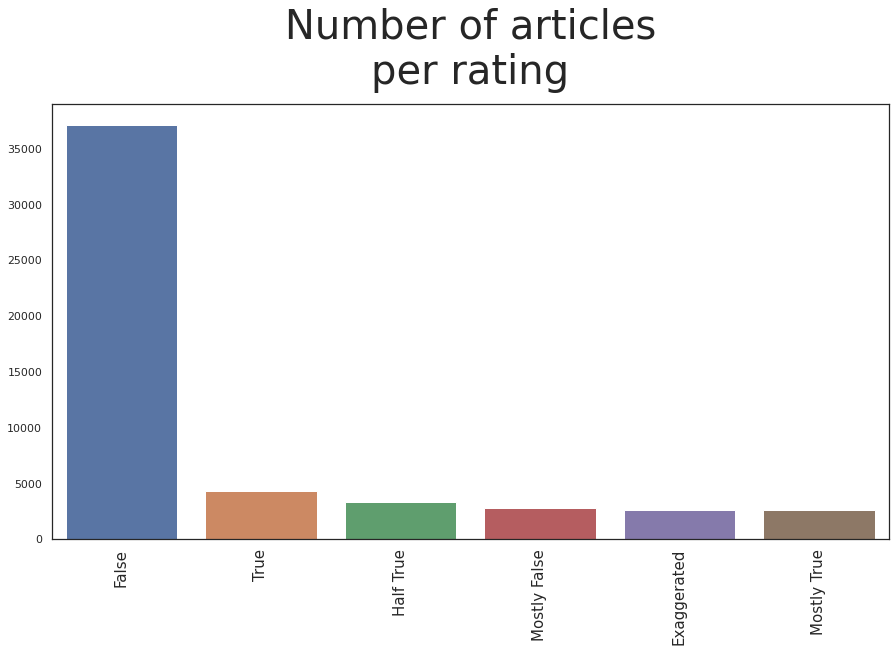

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=90, fontsize=15)
df_final['UniformRatingGraph'] = df_final['UniformRating'].apply(lambda row: 'Half True' if row == 'Half True or Out of Context' else row)
g = sns.countplot(data=df_final, x='UniformRatingGraph', order = df_final['UniformRatingGraph'].value_counts().index[:10])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of articles\nper rating', fontsize = 40, pad=20)

In [ ]:
df_final['UniformRating'].unique()

array(['False', 'Half True or Out of Context', 'Mostly False',
       'Mostly True', 'True', 'Exaggerated'], dtype=object)

Text(0.5, 1.0, 'Ratings')

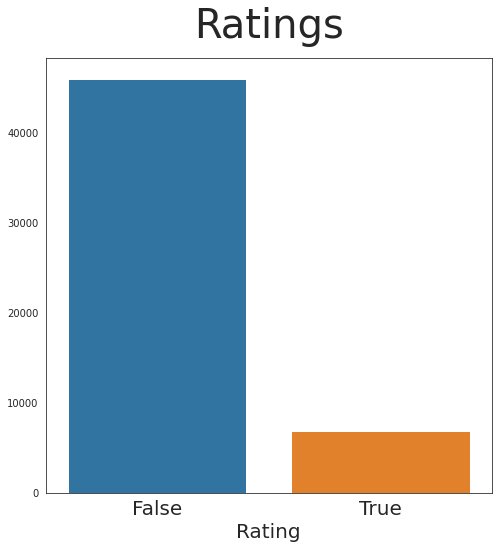

In [ ]:
plt.figure(figsize = (8,8))
plt.xticks(fontsize=20)
sns.set_style('white')
df_final['UniformRatingGraph'] = df_final['UniformRating'].apply(lambda row: 'True' if row in ['True', 'Mostly True'] else 'False')
g = sns.countplot(data=df_final, x='UniformRatingGraph', order = df_final['UniformRatingGraph'].value_counts().index[:10])
g.set_xlabel('Rating', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Ratings', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Simplified rating divided by language')

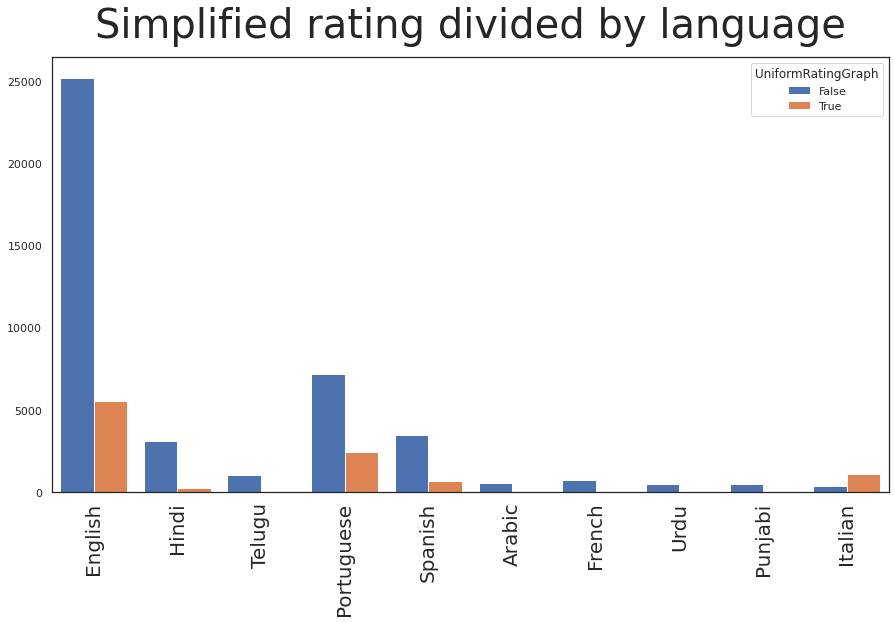

In [ ]:
plt.figure(figsize = (15,8))
plt.xticks(rotation=90, fontsize=20)
g = sns.countplot(data=df_final, x='language', hue='UniformRatingGraph', palette='deep', saturation=1.0)
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Simplified rating divided by language', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Claim Length')

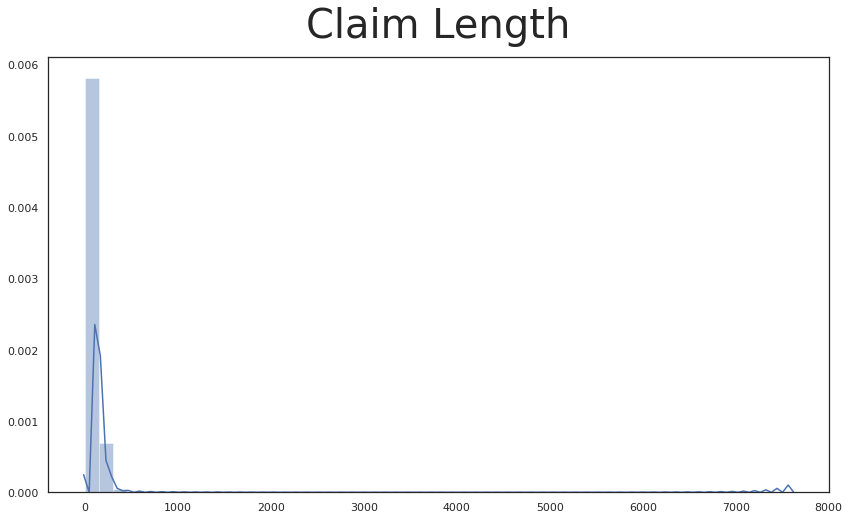

In [ ]:
plt.figure(figsize = (14,8))
df_final['claimLength'] = df_final['claim'].apply(len)
g = sns.distplot(df_final['claimLength'])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Claim Length', fontsize = 40, pad=20)

Some of the claims are way too long, probably due to some problems during the scraping. We can simply cut the ones over 400 characters long, that are only 221

In [ ]:
CLAIM_LENGTH_THRESHOLD = 400
cut = len(df_final[df_final['claimLength'] > CLAIM_LENGTH_THRESHOLD])
perc = cut * 100 / len(df_final)
print("Claims more than {0} characters long: {1} ({2:.2f}%)".format(CLAIM_LENGTH_THRESHOLD, cut, perc))
df_final = df_final[df_final['claimLength'] < CLAIM_LENGTH_THRESHOLD]

Claims more than 400 characters long: 221 (0.42%)


NameError: ignored

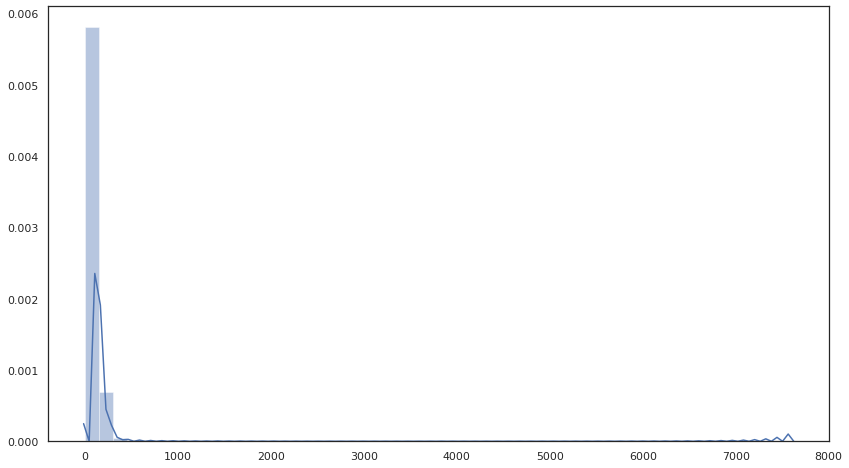

In [ ]:
plt.figure(figsize = (14,8))
df_final['claimLength'] = df_final['claim'].apply(len)
g = sns.distplot(df_final['claimLength'])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Claim Length (below {0} characters)'.format(CLAIM_LENGTH_THRESHOLD), fontsize = 40, pad=20)

Text(0.5, 1.0, 'Number of words in claims')

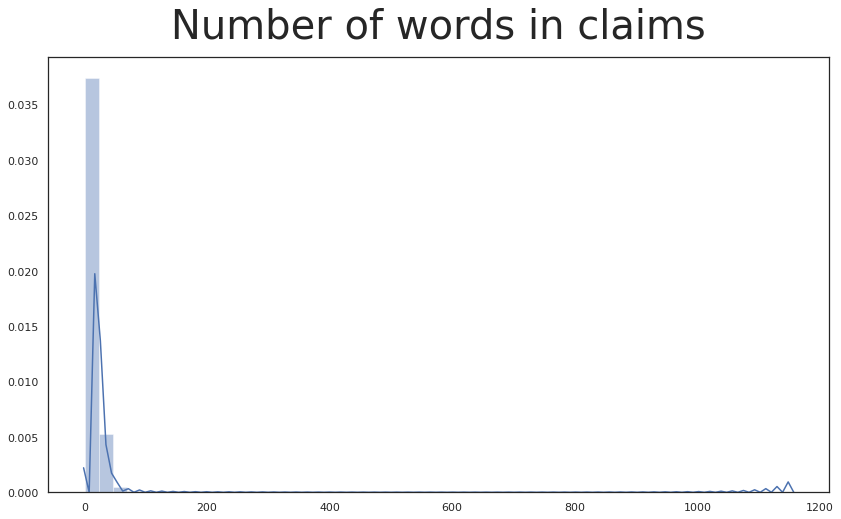

In [ ]:
df_final['claimNumWords'] = df_final['claim'].apply(lambda row: len(row.split(' ')))
plt.figure(figsize = (14,8))
g = sns.distplot(df_final['claimNumWords'])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of words in claims', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Article Length')

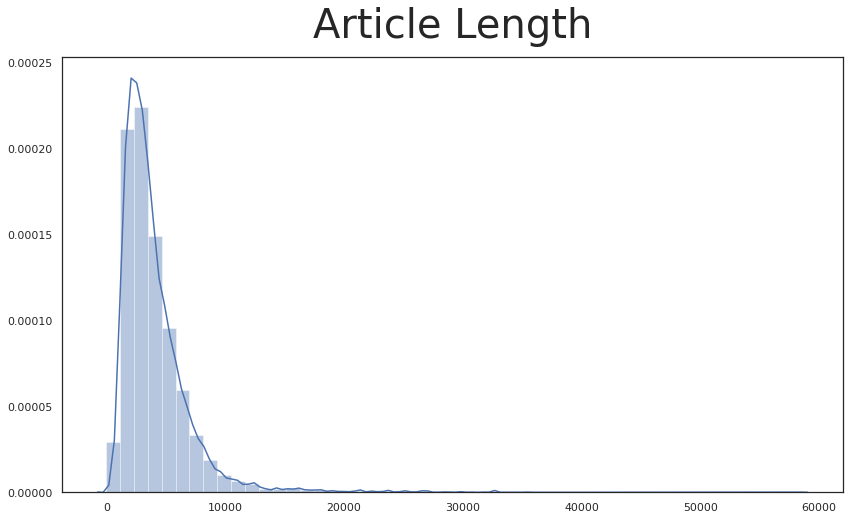

In [ ]:
plt.figure(figsize = (14,8))
df_final['articleLength'] = df_final['articleBody'].apply(len)
g = sns.distplot(df_final['articleLength'])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Article Length', fontsize = 40, pad=20)

In [ ]:
df_final['articleLength'].describe()

count    52653.000000
mean      4027.105198
std       2975.123277
min          1.000000
25%       2212.000000
50%       3284.000000
75%       4970.000000
max      58303.000000
Name: articleLength, dtype: float64

In [ ]:
df_final[df_final['articleLength'] > 58000]['url'].tolist()

['https://www.aosfatos.org/noticias/o-que-o-presidente-falou-do-coronavirus-e-o-que-e-fato/']

In this case the situation is opposite from before. There are some articles that had some problems during the scraping and can be recognized by having low character count. We can easily remove those by putting a 200 minimum character threshold

In [ ]:
ARTICLE_LENGTH_THRESHOLD = 200
cut = len(df_final[df_final['articleLength'] < ARTICLE_LENGTH_THRESHOLD])
perc = cut * 100 / len(df_final)
print("Articles less than {0} characters long: {1} ({2:.2f}%)".format(ARTICLE_LENGTH_THRESHOLD, cut, perc))
df_final = df_final[df_final['articleLength'] > ARTICLE_LENGTH_THRESHOLD]

Articles less than 200 characters long: 12 (0.02%)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Article Length (above 200 characters)')

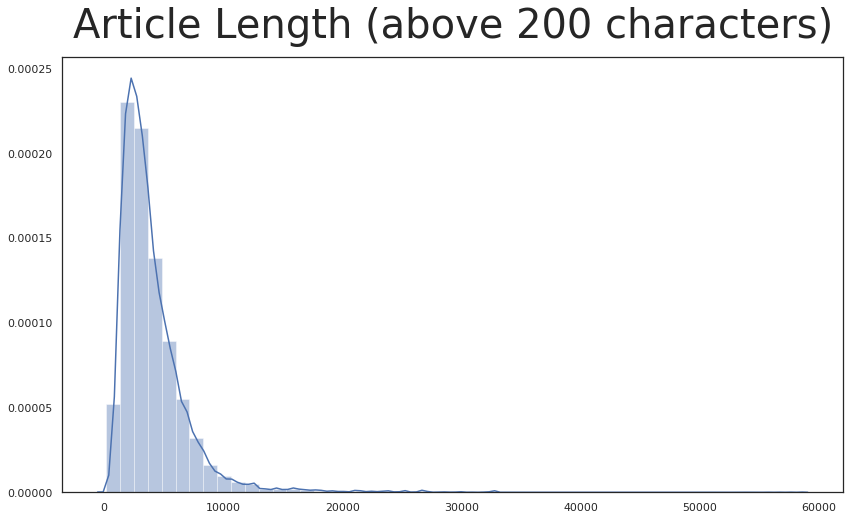

In [ ]:
plt.figure(figsize = (14,8))
df_final['articleLength'] = df_final['articleBody'].apply(len)
g = sns.distplot(df_final['articleLength'])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Article Length (above 200 characters)', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Article Length (focus below 10000 characters)')

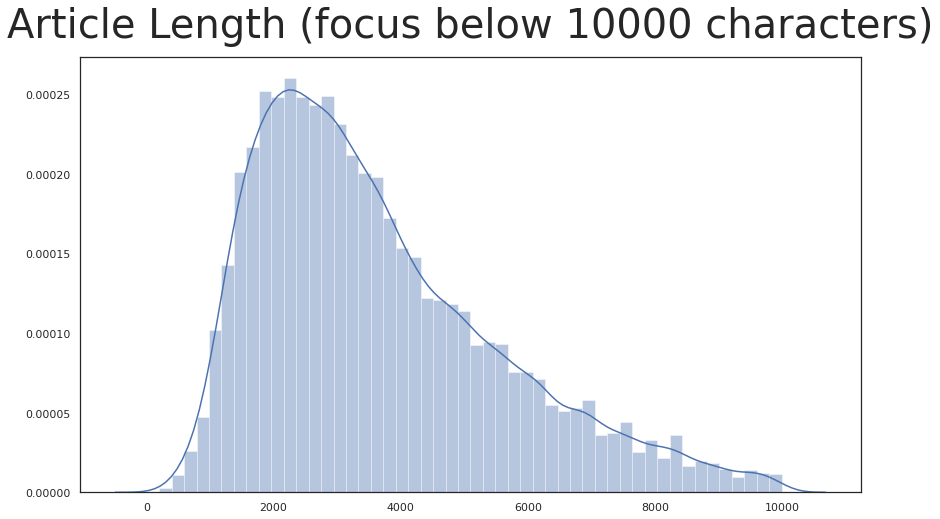

In [ ]:
plt.figure(figsize = (14,8))
g = sns.distplot(df_final[df_final['articleLength'] < 10000]['articleLength'])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Article Length (focus below 10000 characters)', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Article Length')

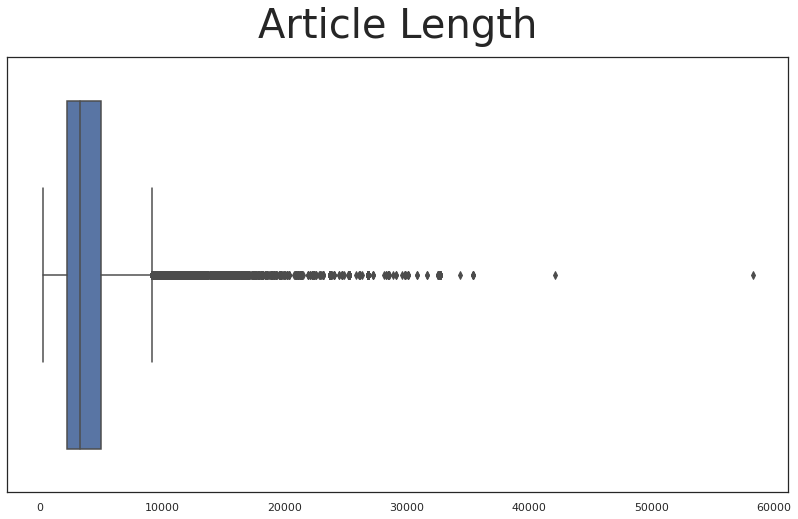

In [ ]:
plt.figure(figsize = (14,8))
g = sns.boxplot(df_final['articleLength'])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Article Length', fontsize = 40, pad=20)

Text(0.5, 1.0, 'Article Length')

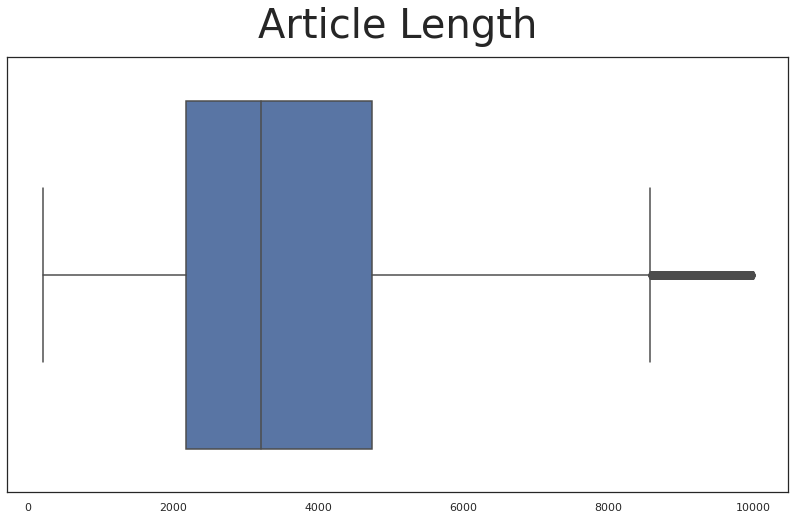

In [ ]:
plt.figure(figsize = (14,8))
g = sns.boxplot(df_final[df_final['articleLength']  < 10000]['articleLength'])
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Article Length', fontsize = 40, pad=20)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Number of words in articles')

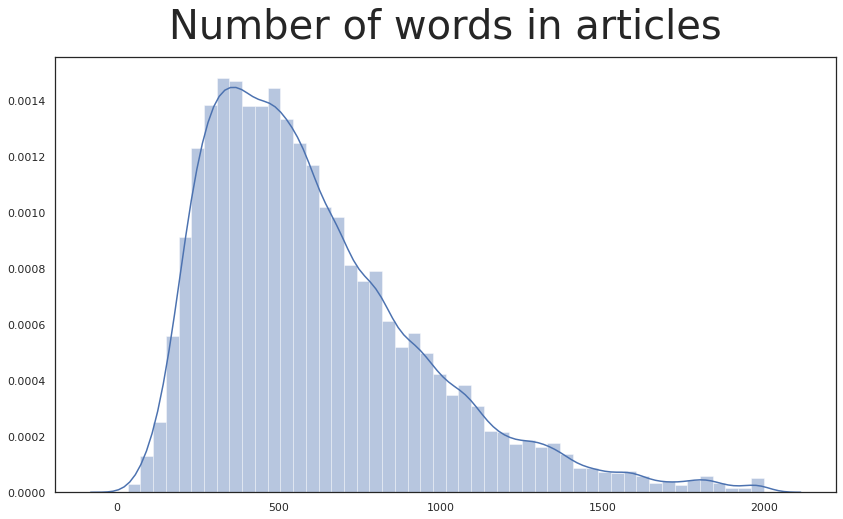

In [ ]:
df_final['articleNumWords'] = df_final['articleBody'].apply(lambda row: len(row.split(' ')))
plt.figure(figsize = (14,8))
g = sns.distplot(df_final[df_final['articleNumWords'] < 2000]['articleNumWords'], bins=50)
g.set_xlabel('', fontsize = 20)
g.set_ylabel('', fontsize = 20)
g.set_title('Number of words in articles', fontsize = 40, pad=20)

In [ ]:
df_final['articleNumWords'].describe()

count    52641.000000
mean       654.753785
std        474.225994
min         35.000000
25%        363.000000
50%        545.000000
75%        807.000000
max       9377.000000
Name: articleNumWords, dtype: float64

In [ ]:
df_final['articleLength'].describe()

count    52641.000000
mean      4028.006497
std       2974.863187
min        202.000000
25%       2213.000000
50%       3285.000000
75%       4970.000000
max      58303.000000
Name: articleLength, dtype: float64

Let's now give a look at the most used words. We will be using only english articles to make it easier.

In [ ]:
import collections
import nltk
nltk.download('stopwords')
en_stops = set(nltk.corpus.stopwords.words('english'))
pt_stops = set(nltk.corpus.stopwords.words('portuguese'))
it_stops = set(nltk.corpus.stopwords.words('italian'))
fr_stops = set(nltk.corpus.stopwords.words('french'))
es_stops = set(nltk.corpus.stopwords.words('spanish'))
tot_stops = en_stops.union(pt_stops).union(it_stops).union(fr_stops).union(es_stops)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#Collect all claims together
all_claims_en = " ".join(df_final[df_final['languageCode'] == 'en']['claim'].tolist())
all_claims_pt = " ".join(df_final[df_final['languageCode'] == 'pt']['claim'].tolist())
all_claims_it = " ".join(df_final[df_final['languageCode'] == 'it']['claim'].tolist())
all_claims_fr = " ".join(df_final[df_final['languageCode'] == 'fr']['claim'].tolist())
all_claims_es = " ".join(df_final[df_final['languageCode'] == 'es']['claim'].tolist())
all_claims_tot = " ".join(df_final[df_final['languageCode'].isin(['en','pt','it','fr','es'])]['claim'].tolist())

pattern = r"\W"

#Count words in all_claims that are not stopwords
def countwords(all_claims, stopwords):
  wordcount = collections.defaultdict(int)
  for word in all_claims.lower().split():
      word = re.sub(pattern, '', word)
      if word not in stopwords:
          wordcount[word] += 1
  return wordcount

wordcount_en = countwords(all_claims_en, en_stops)
wordcount_pt = countwords(all_claims_pt, pt_stops)
wordcount_it = countwords(all_claims_it, it_stops)
wordcount_fr = countwords(all_claims_fr, fr_stops)
wordcount_es = countwords(all_claims_es, es_stops)
wordcount_tot = countwords(all_claims_tot, tot_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc_en = sorted(wordcount_en.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_pt = sorted(wordcount_pt.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_it = sorted(wordcount_it.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_fr = sorted(wordcount_fr.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_es = sorted(wordcount_es.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_tot = sorted(wordcount_tot.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc, language):
  print("Most common words in {0}:\n".format(language))
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered_en = filter_mc(mc_en, 'English')
mc_filtered_pt = filter_mc(mc_pt, 'Portuguese')
mc_filtered_it = filter_mc(mc_it, 'Italian')
mc_filtered_fr = filter_mc(mc_fr, 'French')
mc_filtered_es = filter_mc(mc_es, 'Spanish')
mc_filtered_tot = filter_mc(mc_tot, 'Total')

How many top words do you wish to print?30
The most common 30 words are:

Most common words in English:

trump : 2602
says : 2580
shows : 2434
coronavirus : 2407
people : 2259
president : 2153
covid19 : 1820
us : 1684
video : 1503
said : 1499
donald : 1404
photo : 1369
new : 1207
state : 926
claims : 905
biden : 885
police : 840
joe : 836
one : 788
years : 783
million : 775
states : 773
would : 768
obama : 739
bill : 706
house : 697
man : 677
health : 657
2020 : 628
year : 625


Most common words in Portuguese:

brasil : 744
bolsonaro : 705
redes : 698
sociais : 688
r : 500
governo : 480
publicação : 474
anos : 448
mil : 419
presidente : 399
milhões : 386
lula : 382
ser : 374
pessoas : 334
vai : 292
contra : 287
hoje : 285
covid19 : 277
paulo : 274
dia : 272
todos : 256
pt : 254
rio : 249
sobre : 233
ano : 229
coronavírus : 225
país : 224
vídeo : 223
agora : 222
mundo : 221


Most common words in Italian:

min : 401
euro : 195
mila : 192
governo : 182
miliardi : 179
italia : 178
oggi :

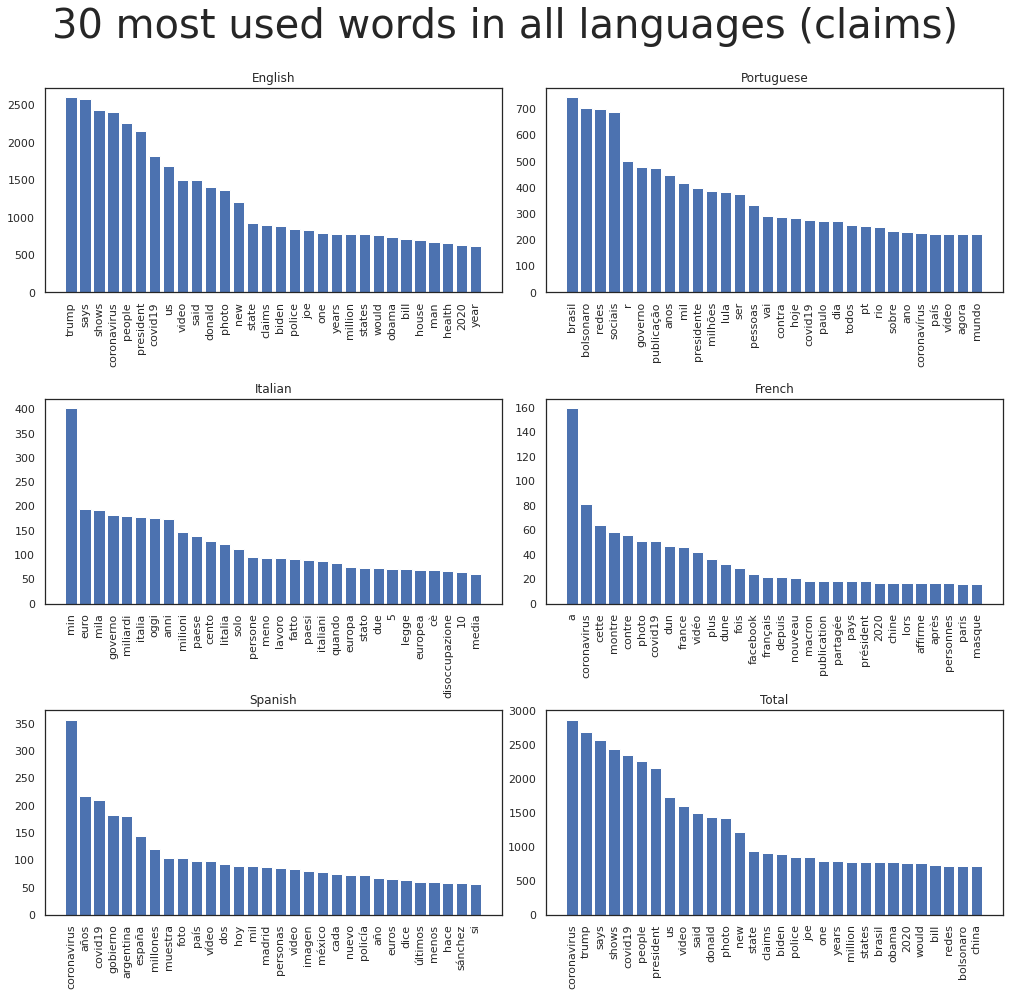

In [ ]:
def drawBarPlot(axs, row, column, mc_filtered, title):
  names = list(mc_filtered.keys())
  values = list(mc_filtered.values())
  axs[row, column].bar(range(len(mc_filtered)),values,tick_label=names)
  axs[row, column].set_title(title)
  axs[row, column].tick_params(axis='x', labelrotation=90)

fig, axs = plt.subplots(3,2, figsize=(14,14))
#plt.title('{0} most used words in all languages'.format(to_print))
fig.suptitle('{0} most used words in all languages (claims)'.format(to_print), fontsize=40)
drawBarPlot(axs, 0, 0, mc_filtered_en, 'English')
drawBarPlot(axs, 0, 1, mc_filtered_pt, 'Portuguese')
drawBarPlot(axs, 1, 0, mc_filtered_it, 'Italian')
drawBarPlot(axs, 1, 1, mc_filtered_fr, 'French')
drawBarPlot(axs, 2, 0, mc_filtered_es, 'Spanish')
drawBarPlot(axs, 2, 1, mc_filtered_tot, 'Total')

fig.tight_layout(pad=0.5)
fig.subplots_adjust(top=0.9)

plt.show()

In [ ]:
#Collect all articles together
all_articles_en = " ".join(df_final[df_final['languageCode'] == 'en']['articleBody'].tolist())
all_articles_pt = " ".join(df_final[df_final['languageCode'] == 'pt']['articleBody'].tolist())
all_articles_it = " ".join(df_final[df_final['languageCode'] == 'it']['articleBody'].tolist())
all_articles_fr = " ".join(df_final[df_final['languageCode'] == 'fr']['articleBody'].tolist())
all_articles_es = " ".join(df_final[df_final['languageCode'] == 'es']['articleBody'].tolist())
all_articles_tot = " ".join(df_final[df_final['languageCode'].isin(['en','pt','it','fr','es'])]['articleBody'].tolist())

#Count words
wordcount_en = countwords(all_articles_en, en_stops)
wordcount_pt = countwords(all_articles_pt, pt_stops)
wordcount_it = countwords(all_articles_it, it_stops)
wordcount_fr = countwords(all_articles_fr, fr_stops)
wordcount_es = countwords(all_articles_es, es_stops)
wordcount_tot = countwords(all_articles_tot, tot_stops)

#Decide how many words to print
to_print = int(input("How many top words do you wish to print?"))
print("The most common {0} words are:\n".format(to_print))

#Sorts the the values in decreasing order and prints the first "to_print".
mc_en = sorted(wordcount_en.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_pt = sorted(wordcount_pt.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_it = sorted(wordcount_it.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_fr = sorted(wordcount_fr.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_es = sorted(wordcount_es.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]
mc_tot = sorted(wordcount_tot.items(), key=lambda k_v: k_v[1], reverse=True)[:to_print+1]

#Creates a dictionary to make the plots later
def filter_mc(mc, language):
  print("Most common words in {0}:\n".format(language))
  mc_filtered = {}
  for word, count in mc:
    if word != '':
      print(word, ":", count)
      mc_filtered[word] = count
  print("\n")
  return mc_filtered

mc_filtered_en = filter_mc(mc_en, 'English')
mc_filtered_pt = filter_mc(mc_pt, 'Portuguese')
mc_filtered_it = filter_mc(mc_it, 'Italian')
mc_filtered_fr = filter_mc(mc_fr, 'French')
mc_filtered_es = filter_mc(mc_es, 'Spanish')
mc_filtered_tot = filter_mc(mc_tot, 'Total')

How many top words do you wish to print?30
The most common 30 words are:

Most common words in English:

said : 87111
post : 59937
news : 57430
facebook : 48902
people : 48545
trump : 47268
us : 45711
also : 45285
would : 41792
claim : 41145
one : 38357
video : 37080
new : 34244
state : 31711
health : 30934
president : 30574
false : 29178
states : 28948
coronavirus : 27403
found : 26927
shared : 23887
rate : 23826
may : 23315
social : 22947
according : 22640
image : 22623
media : 22356
covid19 : 22129
made : 22015
two : 20872


Most common words in Portuguese:

dia : 26780
sobre : 23237
governo : 21148
r : 18691
brasil : 18633
bolsonaro : 17041
ano : 16375
mil : 15459
ser : 14382
segundo : 13874
presidente : 13557
anos : 13300
milhões : 13037
federal : 12675
paulo : 12381
pessoas : 11389
ainda : 11203
dados : 11134
candidato : 10997
número : 10907
janeiro : 10863
acordo : 10684
2018 : 10661
projeto : 10643
estado : 10637
entrevista : 10593
nacional : 10113
rio : 9701
2017 : 9491
país :

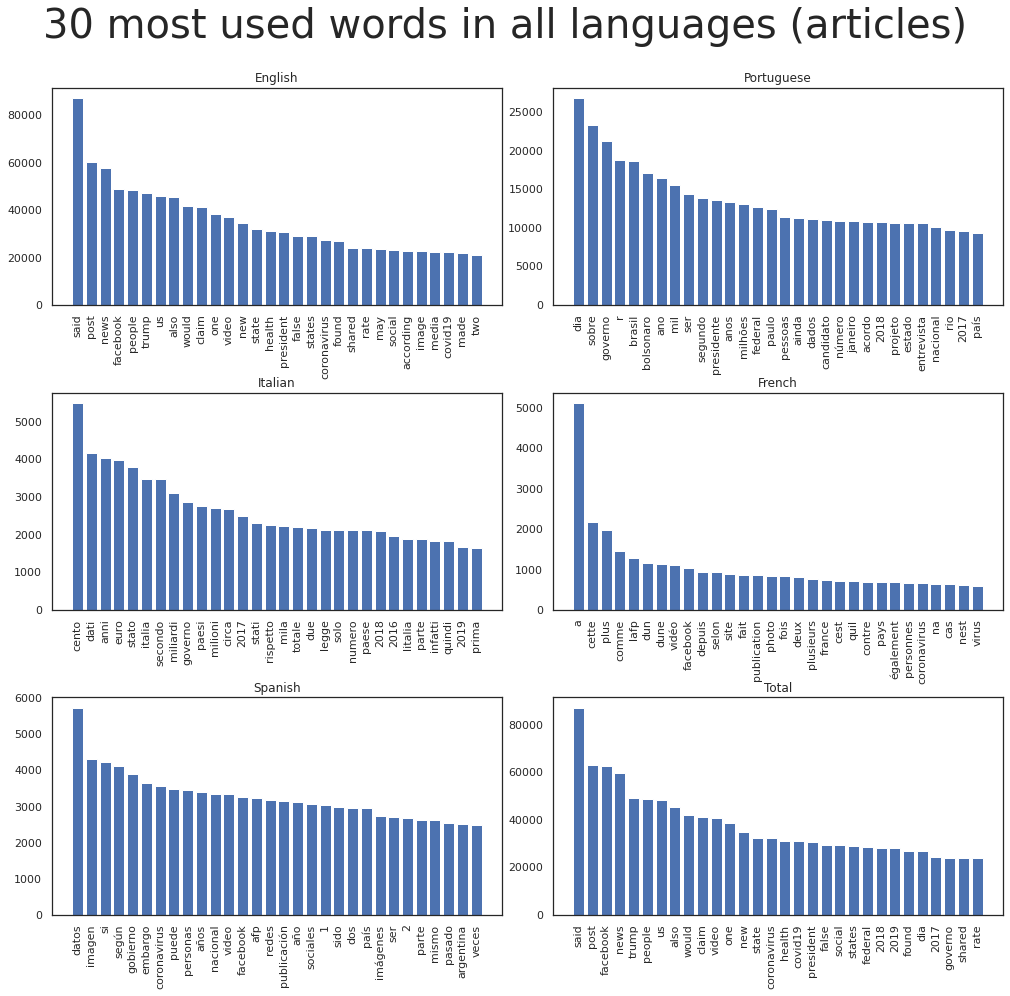

In [ ]:
def drawBarPlot(axs, row, column, mc_filtered, title):
  names = list(mc_filtered.keys())
  values = list(mc_filtered.values())
  axs[row, column].bar(range(len(mc_filtered)),values,tick_label=names)
  axs[row, column].set_title(title)
  axs[row, column].tick_params(axis='x', labelrotation=90)

fig, axs = plt.subplots(3,2, figsize=(14,14))
fig.suptitle('{0} most used words in all languages (articles)'.format(to_print), fontsize=40)
drawBarPlot(axs, 0, 0, mc_filtered_en, 'English')
drawBarPlot(axs, 0, 1, mc_filtered_pt, 'Portuguese')
drawBarPlot(axs, 1, 0, mc_filtered_it, 'Italian')
drawBarPlot(axs, 1, 1, mc_filtered_fr, 'French')
drawBarPlot(axs, 2, 0, mc_filtered_es, 'Spanish')
drawBarPlot(axs, 2, 1, mc_filtered_tot, 'Total')

fig.tight_layout(pad=0.5)
fig.subplots_adjust(top=0.9)

plt.show()

In [ ]:
def removeStopWords(row, stopwords):
  words_list = row.split(' ')
  word_clean = []
  for word in words_list:
    if word not in stopwords:
      word_clean.append(word)
  return ' '.join(word_clean)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

to_print = int(input("How many top bigrams do you wish to print?"))
print("The {0} most common words are:\n".format(to_print))

#Get most common bigrams
common_words_en = get_top_n_bigram(df_final[df_final['languageCode'] == 'en']['claim'].apply(lambda row: removeStopWords(row, en_stops)), to_print)
common_words_pt = get_top_n_bigram(df_final[df_final['languageCode'] == 'pt']['claim'].apply(lambda row: removeStopWords(row, en_stops)), to_print)
common_words_it = get_top_n_bigram(df_final[df_final['languageCode'] == 'it']['claim'].apply(lambda row: removeStopWords(row, en_stops)), to_print)
common_words_fr = get_top_n_bigram(df_final[df_final['languageCode'] == 'fr']['claim'].apply(lambda row: removeStopWords(row, en_stops)), to_print)
common_words_es = get_top_n_bigram(df_final[df_final['languageCode'] == 'es']['claim'].apply(lambda row: removeStopWords(row, en_stops)), to_print)
common_words_tot = get_top_n_bigram(df_final[df_final['languageCode'].isin(['en', 'pt', 'it', 'fr', 'es'])]['claim'].apply(lambda row: removeStopWords(row, en_stops)), to_print)

#Organize info for the graph
def organizeInfoGraph(common_words, lang):
  print("Most common bigrams in {0}\n".format(lang))
  graph_info = {}
  for word, freq in common_words:
      print(word, freq)
      graph_info[word] = freq
  print("\n")
  return graph_info

graph_info_en = organizeInfoGraph(common_words_en, 'English')
graph_info_pt = organizeInfoGraph(common_words_pt, 'Portuguese')
graph_info_it = organizeInfoGraph(common_words_it, 'Italian')
graph_info_fr = organizeInfoGraph(common_words_fr, 'French')
graph_info_es = organizeInfoGraph(common_words_es, 'Spanish')
graph_info_tot = organizeInfoGraph(common_words_tot, 'Total')


How many top bigrams do you wish to print?20
The 20 most common words are:

Most common bigrams in English

covid 19 1816
donald trump 1351
photo shows 861
joe biden 780
video shows 728
president donald 659
nancy pelosi 516
president trump 423
united states 419
new york 360
barack obama 312
bernie sanders 301
image shows 292
hillary clinton 288
says photo 244
white house 237
novel coronavirus 224
social security 213
photograph shows 212
george floyd 200


Most common bigrams in Portuguese

redes sociais 671
nas redes 586
covid 19 273
mais de 262
são paulo 225
milhões de 203
de um 185
todos os 153
em publicação 149
que não 145
de janeiro 142
de uma 142
se que 140
uma publicação 139
rio de 129
de são 122
circular nas 116
sociais uma 113
que se 112
número de 111


Most common bigrams in Italian

per cento 127
milioni di 114
di euro 102
miliardi di 80
ci sono 75
per il 72
il governo 54
in italia 53
più di 49
con il 43
il nostro 41
con la 41
il primo 41
di lavoro 40
ha fatto 39
per la 38
qu

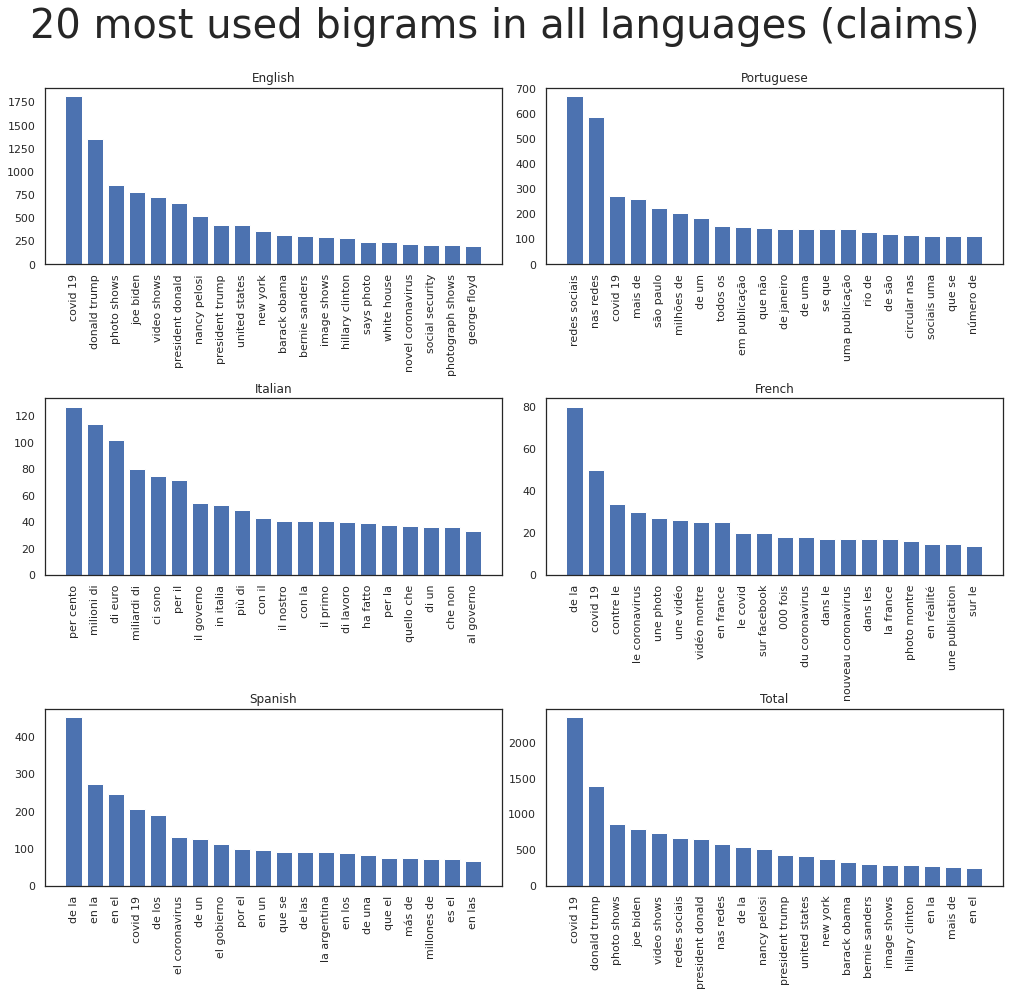

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(14,14))
fig.suptitle('{0} most used bigrams in all languages (claims)'.format(to_print), fontsize=40)
drawBarPlot(axs, 0, 0, graph_info_en, 'English')
drawBarPlot(axs, 0, 1, graph_info_pt, 'Portuguese')
drawBarPlot(axs, 1, 0, graph_info_it, 'Italian')
drawBarPlot(axs, 1, 1, graph_info_fr, 'French')
drawBarPlot(axs, 2, 0, graph_info_es, 'Spanish')
drawBarPlot(axs, 2, 1, graph_info_tot, 'Total')

fig.tight_layout(pad=0.5)
fig.subplots_adjust(top=0.9)

plt.show()

In [ ]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

to_print = int(input("How many top bigrams do you wish to print?"))
print("The {0} most common words are:\n".format(to_print))

#Get most common bigrams
common_words_en = get_top_n_bigram(df_final[df_final['languageCode'] == 'en']['articleBody'].apply(lambda row: removeStopWords(row, en_stops)), to_print)
common_words_pt = get_top_n_bigram(df_final[df_final['languageCode'] == 'pt']['articleBody'].apply(lambda row: removeStopWords(row, en_stops)), to_print)
common_words_it = get_top_n_bigram(df_final[df_final['languageCode'] == 'it']['articleBody'].apply(lambda row: removeStopWords(row, en_stops)), to_print)
common_words_fr = get_top_n_bigram(df_final[df_final['languageCode'] == 'fr']['articleBody'].apply(lambda row: removeStopWords(row, en_stops)), to_print)
common_words_es = get_top_n_bigram(df_final[df_final['languageCode'] == 'es']['articleBody'].apply(lambda row: removeStopWords(row, en_stops)), to_print)
common_words_tot = get_top_n_bigram(df_final[df_final['languageCode'].isin(['en', 'pt', 'it', 'fr', 'es'])]['articleBody'].apply(lambda row: removeStopWords(row, en_stops)), to_print)

#Organize info for the graph
def organizeInfoGraph(common_words, lang):
  print("Most common bigrams in {0}\n".format(lang))
  graph_info = {}
  for word, freq in common_words:
      print(word, freq)
      graph_info[word] = freq
  print("\n")
  return graph_info

graph_info_en = organizeInfoGraph(common_words_en, 'English')
graph_info_pt = organizeInfoGraph(common_words_pt, 'Portuguese')
graph_info_it = organizeInfoGraph(common_words_it, 'Italian')
graph_info_fr = organizeInfoGraph(common_words_fr, 'French')
graph_info_es = organizeInfoGraph(common_words_es, 'Spanish')
graph_info_tot = organizeInfoGraph(common_words_tot, 'Total')

How many top bigrams do you wish to print?20
The 20 most common words are:

Most common bigrams in English

covid 19 24110
facebook post 17820
social media 15761
we rate 13226
united states 12074
new york 11425
donald trump 11319
the post 9289
fake news 8747
false news 8382
efforts combat 8264
partnership facebook 8217
news feed 8185
combat false 8181
news misinformation 8177
feed read 8127
read partnership 8127
part facebook 8121
flagged part 8118
misinformation news 8064


Most common bigrams in Portuguese

são paulo 10965
acordo com 9536
de janeiro 9507
de um 8397
em entrevista 8291
de são 8024
que não 7884
da república 7874
mais de 7647
de 2018 7453
de acordo 7384
de uma 7302
jair bolsonaro 7261
milhões de 7042
redes sociais 6908
covid 19 6376
número de 6292
rio de 6267
dia de 5728
de que 5631


Most common bigrams in Italian

per cento 5449
per il 2517
di euro 2278
miliardi di 1785
di un 1643
il verdetto 1518
milioni di 1515
che il 1382
per la 1327
il numero 1053
numero di 1017
ch

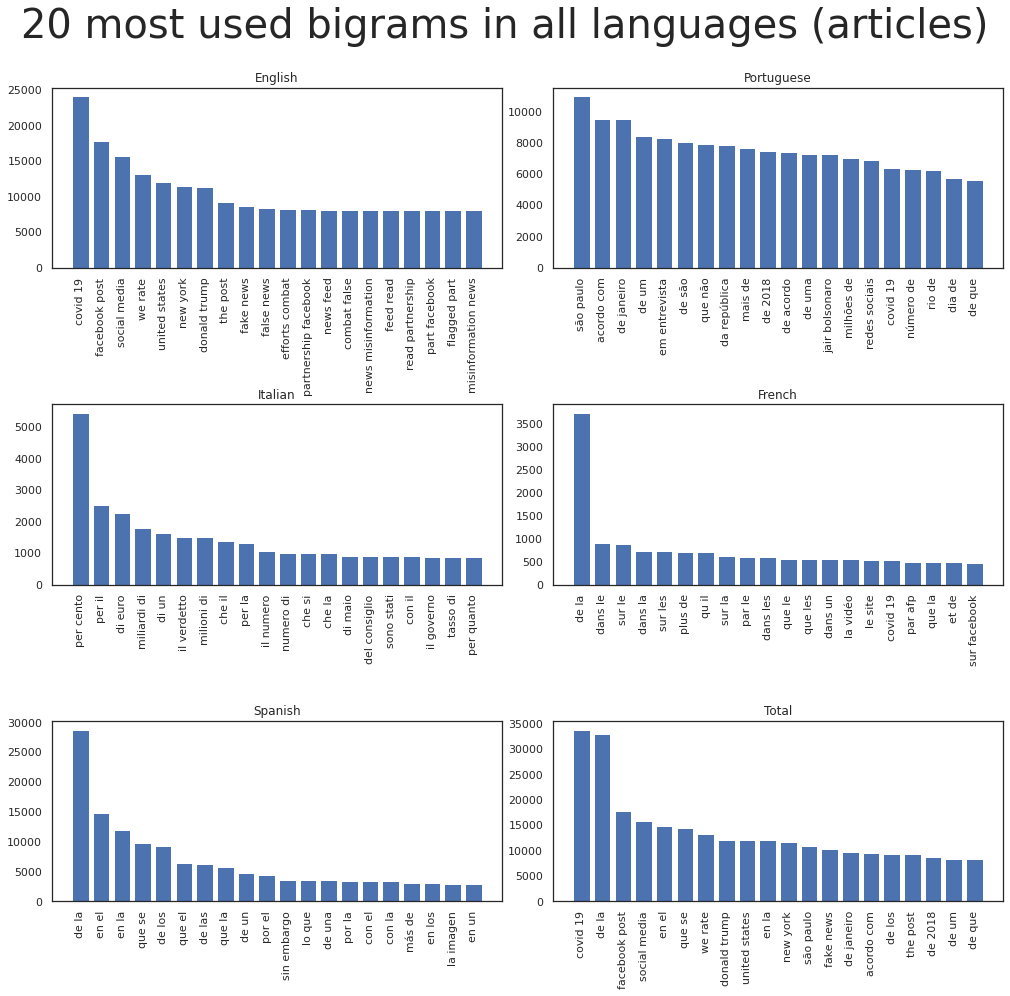

In [ ]:
fig, axs = plt.subplots(3,2, figsize=(14,14))
fig.suptitle('{0} most used bigrams in all languages (articles)'.format(to_print), fontsize=40)
drawBarPlot(axs, 0, 0, graph_info_en, 'English')
drawBarPlot(axs, 0, 1, graph_info_pt, 'Portuguese')
drawBarPlot(axs, 1, 0, graph_info_it, 'Italian')
drawBarPlot(axs, 1, 1, graph_info_fr, 'French')
drawBarPlot(axs, 2, 0, graph_info_es, 'Spanish')
drawBarPlot(axs, 2, 1, graph_info_tot, 'Total')

fig.tight_layout(pad=0.5)
fig.subplots_adjust(top=0.9)

plt.show()

In [ ]:
df_final.to_csv('clean_final_factcheck_articles.csv', index=False)
save_file_to_drive('clean_final_factcheck_articles.csv', 'clean_final_factcheck_articles.csv')

File ID: 1CWpJGqP3CHC1v2-N5YCGddz7C-4m2L3b


{'id': '1CWpJGqP3CHC1v2-N5YCGddz7C-4m2L3b'}

In [ ]:
link = "https://drive.google.com/file/d/1CWpJGqP3CHC1v2-N5YCGddz7C-4m2L3b/view?usp=sharing"
id = "1CWpJGqP3CHC1v2-N5YCGddz7C-4m2L3b" 
name = "clean_final_factcheck_articles.csv"
downloaded = drive.CreateFile({'id': id}) 
downloaded.GetContentFile(name)  

In [ ]:
df_final = pd.read_csv('clean_final_factcheck_articles.csv')
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52420 entries, 0 to 52419
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Unnamed: 0                  52420 non-null  int64 
 1   claim                       52420 non-null  object
 2   claimant                    45797 non-null  object
 3   claimDate                   45851 non-null  object
 4   url                         52420 non-null  object
 5   reviewTitle                 52227 non-null  object
 6   reviewDate                  51746 non-null  object
 7   Rating                      52420 non-null  object
 8   languageCode                52420 non-null  object
 9   publisherName               50906 non-null  object
 10  publisherSite               52420 non-null  object
 11  UniformRating               52420 non-null  object
 12  claimLink                   1401 non-null   object
 13  articleBody                 52420 non-null  ob

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_final[df_final['publisherName'].isna()]['publisherSite'].unique()

array(['vishvasnews.com'], dtype=object)

## TO DO
 - factual.afp.com is sometimes giving infos in a language and articles in another, or is giving the wrong info on the article's language (sometimes gives claim in one language and article in another). This should be checked
 - poligrafo.sapo.pt have the issue that claims are cut in half; should scrape them again to retrieve the complete sentence
 - Check that the scraped articles correspond to the actual articles
 - Some of the image urls need website prefix
 - Find claimDate of Politifact
 - Adjust claimant column